In [2]:
import os
import sys
from datetime import datetime, timedelta
import logging
import pickle
import time
from dataclasses import dataclass, field
from enum import Enum
from typing import Any, Dict, List, Optional, Set, Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import unicodedata
from dotenv import load_dotenv

# Add project root to sys.path
current_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(current_dir, '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

# Verify sys.path
# print("Current sys.path:", sys.path)

from src.data_processing.nst_scraper import nst_on_ice_scraper, nst_team_on_ice_scraper
from src.db.nhl_db_utils import update_player_db, check_last_update, get_player_full_name, insert_player_data
from src.db.the_odds_db_utils import get_team_moneyline_odds
from src.data_processing.team_utils import get_most_recent_game_id, get_fullname_by_tricode
from src.data_processing.game_utils import get_game_boxscore, display_boxscore
from src.data_processing.pbp_utils import get_matchup_games
from src.data_processing.player_utils import fetch_player_data

from src.entities.lineup import Lineup, Player, Position

from dotenv import load_dotenv

pd.set_option('display.max_columns', None)
np.set_printoptions(legacy='1.25')

In [3]:
today_datetime= datetime.now()
yesterday_datetime = today_datetime - timedelta(days=1, hours=6) # UTC offset
yesterday = yesterday_datetime.strftime('%Y-%m-%d')
yesterday

'2025-01-30'

In [4]:
# Load environment variables from .env file
load_dotenv()

db_prefix = 'NHL_DB_'

In [5]:
# Check the last update time of the players database
last_update = check_last_update(db_prefix)

INFO:src.db.base_utils:Database connection established.
INFO:src.db.nhl_db_utils:Last database update was on: 2025-01-30
INFO:src.db.base_utils:Database connection closed.


In [6]:
# Convert last_update to datetime
last_update_dt = datetime.strptime(last_update, '%Y-%m-%d')
today_dt = datetime.strptime(today_datetime.strftime('%Y-%m-%d'), '%Y-%m-%d')
yesterday_dt = datetime.strptime(yesterday, '%Y-%m-%d')

# Only update if last update was before yesterday
if last_update_dt not in [today_dt, yesterday_dt]:
    # Update the player database from last update to yesterday
    update_player_db(last_update, yesterday, db_prefix, skip_existing=True)
else:
    print(f"No need to update the player database. Last update was on: {last_update}")


No need to update the player database. Last update was on: 2025-01-30


In [7]:
def get_skater_stats(lineup: Lineup, player_stats_df: pd.DataFrame, filter: Optional[str] = None) -> pd.DataFrame:
    """
    Gets stats for players in the lineup, maintaining lineup order.
    
    Args:
        lineup (Lineup): The lineup containing players
        player_stats_df (pd.DataFrame): DataFrame with player statistics
        filter (str, optional): Type of filter to apply on the stats.
        Defaults to None, which keeps all stats. If 'shots', only shot-related statistics are kept.
        
    Returns:
        pd.DataFrame: Player statistics ordered according to lineup positions
    """
    # Apply filter if specified
    if filter == 'shots':
        # Define shot-related columns to keep
        shot_columns = ['player', 'team', 'position', 'gp', 'toi', 'toi/gp','shots/60', 'icf/60', 'iff/60'] 
        player_stats_df = player_stats_df[shot_columns]
    
    # Create ordered list of players (forwards then defense)
    players = []
    # Add forwards in order
    players.extend([p for p in lineup.forwards if p])
    # Add defense in order 
    players.extend([p for p in lineup.defense if p])
    
    # Create ordered list of player names
    player_names = [player.name for player in players]
    
    # Filter stats and reorder to match lineup order
    stats_df = player_stats_df[player_stats_df['player'].isin(player_names)]
    
    # Create ordering dictionary mapping names to their position in lineup
    name_to_position = {name: idx for idx, name in enumerate(player_names)}
    
    # Sort stats DataFrame based on lineup order and reset index
    stats_df = stats_df.assign(
        lineup_order=stats_df['player'].map(name_to_position)
    ).sort_values('lineup_order').drop('lineup_order', axis=1).reset_index(drop=True)
    
    # Add 'b2b' column to the right of 'position'
    stats_df.insert(stats_df.columns.get_loc('position') + 1, 'b2b', lineup.back_to_back)
    
    return stats_df

In [8]:
def get_goalie_stats(lineup: Lineup, goalie_stats_df: pd.DataFrame) -> pd.DataFrame:
    """
    Gets stats for goalies in the lineup, maintaining lineup order.
    
    Args:
        lineup (Lineup): The lineup containing goalies
        goalie_stats_df (pd.DataFrame): DataFrame with goalie statistics
        
    Returns:
        pd.DataFrame: Goalie statistics ordered according to lineup positions
    """
    # Create ordered list of goalies
    goalies = [goalie for goalie in lineup.goalies if goalie]
    goalie_names = [goalie.name for goalie in goalies]
    
    # Filter stats and reorder to match lineup order
    stats_df = goalie_stats_df[goalie_stats_df['player'].isin(goalie_names)]
    
    # Create ordering dictionary mapping names to their position in lineup
    name_to_position = {name: idx for idx, name in enumerate(goalie_names)}
    
    # Sort stats DataFrame based on lineup order and reset index
    return stats_df.assign(
        lineup_order=stats_df['player'].map(name_to_position)
    ).sort_values('lineup_order').drop('lineup_order', axis=1).reset_index(drop=True)

In [9]:
def extract_team_lineup(team: str, reference_date: Optional[str] = None) -> Lineup:
    """
    Gets stats for goalies in the lineup, maintaining lineup order.
    
    Args:
        team (str): The three-letter team code (e.g., 'TOR').
        reference_date (Optional[str]): The reference date in 'YYYY-MM-DD' format. Defaults to yesterday's date.
    
    Returns:
        Lineup: A `Lineup` object containing the team's players from the most recent game.
    
    Raises:
        ValueError: If no recent game is found for the team or if the team is not part of the retrieved game.
    """
    # Step 1: Determine the reference date
    if reference_date is None:
        today_datetime = datetime.now()
        yesterday_datetime = today_datetime - timedelta(days=1, hours=6)  # Adjust for UTC offset if necessary
        reference_date = yesterday_datetime.strftime('%Y-%m-%d')

    # Step 2: Retrieve the most recent game ID for the team
    game_id, back_to_back = get_most_recent_game_id(team, reference_date)
    if game_id is None:
        raise ValueError(f"No recent game found for team '{team}' before {reference_date}.")

    # Print the game_id
    print(f"Game ID: {game_id}")

    # Step 3: Fetch the game boxscore data
    game_data = get_game_boxscore(game_id, clean=False)

    # Step 4: Process the boxscore to obtain skaters and goalies
    away_skaters, away_goalies, home_skaters, home_goalies = display_boxscore(game_data)

    # Extract team abbreviations to determine if the team is home or away
    away_team_code = game_data.get('awayTeam', {}).get('abbrev')
    home_team_code = game_data.get('homeTeam', {}).get('abbrev')

    if not away_team_code or not home_team_code:
        raise ValueError("Team abbreviations not found in game data.")

    if team.upper() == away_team_code.upper():
        team_side = 'Away'
        skaters = away_skaters
        goalies = away_goalies
    elif team.upper() == home_team_code.upper():
        team_side = 'Home'
        skaters = home_skaters
        goalies = home_goalies
    elif team.upper() == 'UTA':
        # Since UTA did not exist in the previous season, match with ARI
        if 'ARI' == away_team_code.upper():
            team_side = 'Away'
            skaters = away_skaters
            goalies = away_goalies
        elif 'ARI' == home_team_code.upper():
            team_side = 'Home'
            skaters = home_skaters
            goalies = home_goalies
        else:
            raise ValueError(f"Team '{team}' not found in game ID {game_id}.")
    else:
        raise ValueError(f"Team '{team}' not found in game ID {game_id}.")

    # Step 5: Construct the Lineup object
    lineup = Lineup(name=f"{team.upper()} Lineup from Game {game_id}")
    print(f"Back to back: {back_to_back}")
    lineup.back_to_back = back_to_back  # Assign back_to_back to the Lineup

    # Add Skaters to the Lineup
    for _, skater in skaters.iterrows():
        try:
            position_enum = Position(skater['position'])  # Convert to Position Enum
        except ValueError:
            print(f"Invalid position '{skater['position']}' for player '{skater['name']}'. Skipping.")
            continue
        
        name = get_player_full_name(skater['playerId'], db_prefix, suppress_log=True)
        # If player's name is None, fetch the player's information and store it
        if name is None:
            player_data = fetch_player_data(skater['playerId'])
            if player_data:
                insert_player_data(player_data, 'NHL_DB_')
            name = get_player_full_name(skater['playerId'], db_prefix, suppress_log=True)
        
        player = Player(
            player_id=skater['playerId'],
            name=name,
            team=team.upper(),
            position=position_enum
        )

        # Add player to the appropriate category in the lineup
        if player.position.category == 'F':
            try:
                empty_slot = next(i for i, p in enumerate(lineup.forwards) if p is None)
                lineup.add_forward(player, empty_slot)
            except StopIteration:
                # Attempt to add a new forward slot
                try:
                    lineup.adjust_slots('forwards', delta=1)
                    empty_slot = len(lineup.forwards) - 1
                    lineup.add_forward(player, empty_slot)
                    print(f"Added a new forward slot. Total forwards: {len(lineup.forwards)}.")
                except ValueError as e:
                    print(f"Cannot adjust forward slots: {e}. Skipping player '{player.name}'.")
        elif player.position.category == 'D':
            try:
                empty_slot = next(i for i, p in enumerate(lineup.defense) if p is None)
                lineup.add_defense(player, empty_slot)
            except StopIteration:
                # Attempt to add a new defense slot
                try:
                    lineup.adjust_slots('defense', delta=1)
                    empty_slot = len(lineup.defense) - 1
                    lineup.add_defense(player, empty_slot)
                    print(f"Added a new defense slot. Total defensemen: {len(lineup.defense)}.")
                except ValueError as e:
                    print(f"Cannot adjust defense slots: {e}. Skipping player '{player.name}'.")
        else:
            print(f"Player '{player.name}' has an unrecognized category '{player.position.category}'. Skipping.")

    # Add Goalies to the Lineup
    for _, goalie in goalies.iterrows():
        player = Player(
            player_id=goalie['playerId'],
            name=get_player_full_name(goalie['playerId'], db_prefix, suppress_log=True),
            team=team.upper(),
            position=Position.G
        )
        try:
            empty_slot = next(i for i, p in enumerate(lineup.goalies) if p is None)
            lineup.set_goalie(player, empty_slot)
        except StopIteration:
            print(f"No available goalie slot to add player '{player.name}'.")

    return lineup
# chicago_lineup = extract_team_lineup('CHI', '2024-11-21')

In [10]:
def calculate_min_percentage(df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculates the average time on ice per game as a percentage of total game time (60 minutes).
    
    Args:
        df (pd.DataFrame): DataFrame containing 'toi' and 'gp' columns
        
    Returns:
        pd.DataFrame: Original DataFrame with new 'min%' column added
    """
    df_copy = df.copy()
    df_copy['min%'] = (df_copy['toi'] / df_copy['gp'] / 300 * 100).round(2)
    return df_copy

# # Apply the function to lineup_player_stats
# lineup_player_stats = calculate_min_percentage(lineup_player_stats)
# lineup_player_stats

def sum_min_percentage(df: pd.DataFrame) -> float:
    """
    Calculates the sum of the 'min%' column in the given DataFrame.
    
    Args:
        df (pd.DataFrame): DataFrame containing the 'min%' column.
        
    Returns:
        float: The total sum of the 'min%' values.
        
    Raises:
        KeyError: If the 'min%' column is not present in the DataFrame.
    """
    if 'min%' not in df.columns:
        raise KeyError("The DataFrame does not contain a 'min%' column.")
    
    total_min_percentage = df['min%'].sum()
    return total_min_percentage

# Example usage:
# total_min_percentage = sum_min_percentage(lineup_player_stats)
# print(f"Total min%: {total_min_percentage}")

def calculate_adj_min(df: pd.DataFrame, total_min_percentage: float) -> None:
    """
    Calculates the adjusted minimum (adj_min) for each player based on their min% and the total min%.
    
    The formula used is:
        adj_min = (min% / total_min_percentage) * 300
    
    Args:
        df (pd.DataFrame): DataFrame containing the 'min%' column.
        total_min_percentage (float): The total sum of the 'min%' column.
        
    Raises:
        KeyError: If the 'min%' column is not present in the DataFrame.
        ValueError: If total_min_percentage is not a positive number.
    """
    if 'min%' not in df.columns:
        raise KeyError("The DataFrame does not contain a 'min%' column.")
    
    if total_min_percentage <= 0:
        raise ValueError("total_min_percentage must be a positive number.")
    
    # Calculate and append the 'adj_min' column
    df['adj_min'] = ((df['min%'] / total_min_percentage) * 300).round(2)

# # Example usage:
# calculate_adj_min(lineup_player_stats, total_min_percentage)
# print(lineup_player_stats[['player', 'min%', 'adj_min']])

In [11]:
# Define file paths to load the model and transformer
model_filepath = '../models/polynomial_model_degree_1.pkl'
poly_filepath = '../models/polynomial_features_degree_1.pkl'

# Load the regression model
with open(model_filepath, 'rb') as model_file:
    loaded_model = pickle.load(model_file)
print(f"Model loaded from {model_filepath}")

# Load the PolynomialFeatures transformer
with open(poly_filepath, 'rb') as poly_file:
    loaded_poly = pickle.load(poly_file)
print(f"PolynomialFeatures transformer loaded from {poly_filepath}")

# Function to make predictions using the loaded model and transformer
def predict_gpm(new_ixg60_value, model, poly, x_col='ixg60'):
    """
    Predicts 'gpm' using the loaded model and polynomial transformer.
    
    Parameters:
        new_ixg60_value (float): The new ixg60 value for prediction.
        model (RegressionResults): The loaded regression model.
        poly (PolynomialFeatures): The loaded polynomial features transformer.
        x_col (str): The name of the independent variable column. Defaults to 'ixg60'.
        
    Returns:
        predicted_gpm (float): The predicted gpm value.
    """
    # Prepare the input data
    X_new = np.array([[new_ixg60_value]])
    X_new_poly = poly.transform(X_new)
    X_new_poly_const = sm.add_constant(X_new_poly, has_constant='add')
    
    # Create DataFrame with appropriate column names
    feature_names = ['const'] + poly.get_feature_names_out([x_col]).tolist()
    new_data = pd.DataFrame(X_new_poly_const, columns=feature_names)
    
    # Predict
    predicted_gpm = model.predict(new_data)
    return predicted_gpm.iloc[0]

# Example: Predicting 'gpm' for a new ixg60 value
# new_ixg60_value = 50
# predicted_gpm = predict_gpm(new_ixg60_value, loaded_model, loaded_poly)
# print(f"Predicted GPM for ixg60={new_ixg60_value}: {predicted_gpm:.4f}")

Model loaded from ../models/polynomial_model_degree_1.pkl
PolynomialFeatures transformer loaded from ../models/polynomial_features_degree_1.pkl


In [12]:
# Function to predict GPM for each player and add it to the DataFrame
def add_gpm_to_lineup(lineup_df, model, poly):
    """
    Adds a 'gpm' column to the lineup_player_stats DataFrame using the predict_gpm function.
    
    Args:
        lineup_df (pd.DataFrame): DataFrame containing 'ixg/60' column.
        model: Loaded regression model.
        poly: Loaded PolynomialFeatures transformer.
        
    Returns:
        pd.DataFrame: Updated DataFrame with 'gpm' column added.
    """
    # Define a helper function to handle potential missing or invalid values
    def safe_predict(ixg_60):
        if pd.isna(ixg_60):
            return np.nan
        try:
            return predict_gpm(ixg_60, model, poly)
        except Exception as e:
            print(f"Error predicting GPM for ixg_60={ixg_60}: {e}")
            return np.nan
    
    # Apply the predict_gpm function to each 'ixg/60' value
    lineup_df['gpm'] = lineup_df['ixg/60'].apply(safe_predict)
    return lineup_df

# # Apply the function to add 'gpm' to your DataFrame
# lineup_player_stats = add_gpm_to_lineup(lineup_player_stats, loaded_model, loaded_poly)

# # Display the updated DataFrame with 'gpm'
# print(lineup_player_stats[['player', 'ixg/60', 'gpm']])

In [13]:
def calculate_x_goals(lineup_stats_df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculates 'x_goals' by multiplying 'gpm' with 'adj_min' for each player.
    
    Args:
        lineup_stats_df (pd.DataFrame): DataFrame containing 'gpm' and 'adj_min' columns.
        
    Returns:
        pd.DataFrame: DataFrame with the new 'x_goals' column added.
        
    Raises:
        KeyError: If 'gpm' or 'adj_min' columns are not present in the DataFrame.
        TypeError: If 'gpm' or 'adj_min' contain non-numeric data.
    """
    # Check if required columns exist
    required_columns = {'gpm', 'adj_min'}
    missing_columns = required_columns - set(lineup_stats_df.columns)
    if missing_columns:
        raise KeyError(f"The DataFrame is missing the following required columns: {', '.join(missing_columns)}")
    
    # Check if 'gpm' and 'adj_min' are numeric
    if not pd.api.types.is_numeric_dtype(lineup_stats_df['gpm']):
        raise TypeError("'gpm' column must be numeric.")
    if not pd.api.types.is_numeric_dtype(lineup_stats_df['adj_min']):
        raise TypeError("'adj_min' column must be numeric.")
    
    # Calculate 'x_goals'
    lineup_stats_df = lineup_stats_df.copy()
    lineup_stats_df['x_goals'] = lineup_stats_df['gpm'] * lineup_stats_df['adj_min']
    
    return lineup_stats_df

In [14]:
def calculate_goalie_adjustment(goalie_stats_df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculate goalie adjustment using multiple weighted metrics.
    
    Combines high-danger, medium-danger, and low-danger save percentages
    with additional factors like rebound control and rush defense.
    """
    # Define weights for different components
    WEIGHTS = {
        'hdsv%': 0.40,  # High-danger saves most important
        'mdsv%': 0.25,  # Medium-danger saves
        'ldsv%': 0.15,  # Low-danger saves
        'rebound_control': 0.10,  # Rebound control
        'rush_defense': 0.10   # Rush defense
    }
    
    # Calculate league averages
    league_avg_hdsv = goalie_stats_df['hdsv%'].mean()
    league_avg_mdsv = goalie_stats_df['mdsv%'].mean()
    league_avg_ldsv = goalie_stats_df['ldsv%'].mean()
    league_avg_rebounds = goalie_stats_df['rebound_attempts_against/60'].mean()
    league_avg_rush = goalie_stats_df['rush_attempts_against/60'].mean()
    
    # Calculate individual components
    goalie_stats_df['hd_component'] = (goalie_stats_df['hdsv%'] / league_avg_hdsv) * WEIGHTS['hdsv%']
    goalie_stats_df['md_component'] = (goalie_stats_df['mdsv%'] / league_avg_mdsv) * WEIGHTS['mdsv%']
    goalie_stats_df['ld_component'] = (goalie_stats_df['ldsv%'] / league_avg_ldsv) * WEIGHTS['ldsv%']
    
    # Rebound control (inverse since lower is better)
    goalie_stats_df['rebound_component'] = (league_avg_rebounds / goalie_stats_df['rebound_attempts_against/60']) * WEIGHTS['rebound_control']
    
    # Rush defense (inverse since lower is better)
    goalie_stats_df['rush_component'] = (league_avg_rush / goalie_stats_df['rush_attempts_against/60']) * WEIGHTS['rush_defense']
    
    # Calculate final adjustment (multiply by 100 to get percentage)
    goalie_stats_df['adj%'] = (goalie_stats_df['hd_component'] + 
                              goalie_stats_df['md_component'] + 
                              goalie_stats_df['ld_component'] + 
                              goalie_stats_df['rebound_component'] + 
                              goalie_stats_df['rush_component']) * 100
    
    return goalie_stats_df

In [15]:
def calculate_recent_performance_adjustment(goalie_stats_df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculate goalie adjustment with emphasis on recent performance using games played.
    
    Combines save percentage metrics with recent performance indicators,
    weighted by games played to account for sample size.
    """
    # Calculate confidence factor based on games played
    max_gp = goalie_stats_df['gp'].max()
    goalie_stats_df['confidence_factor'] = goalie_stats_df['gp'] / max_gp
    
    # Calculate base performance metrics
    league_avg_sv = goalie_stats_df['sv%'].mean()
    league_avg_gsaa60 = goalie_stats_df['gsaa/60'].mean()
    league_avg_xg60 = goalie_stats_df['xg_against/60'].mean()
    
    # Calculate components with confidence weighting
    goalie_stats_df['sv_component'] = (goalie_stats_df['sv%'] / league_avg_sv) * goalie_stats_df['confidence_factor']
    
    # GSAA component (scaled and centered around 1)
    goalie_stats_df['gsaa_component'] = (1 + (goalie_stats_df['gsaa/60'] - league_avg_gsaa60)) * goalie_stats_df['confidence_factor']
    
    # Expected goals component (inverse since lower is better)
    goalie_stats_df['xg_component'] = (league_avg_xg60 / goalie_stats_df['xg_against/60']) * goalie_stats_df['confidence_factor']
    
    # Calculate final adjustment
    goalie_stats_df['adj%'] = ((goalie_stats_df['sv_component'] * 0.4 + 
                               goalie_stats_df['gsaa_component'] * 0.3 + 
                               goalie_stats_df['xg_component'] * 0.3) * 100)
    
    return goalie_stats_df

In [16]:
def calculate_shot_quality_adjustment(goalie_stats_df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculate goalie adjustment based on performance against different shot qualities
    and distances, with consideration for shot volume.
    """
    # Calculate shot quality ratios
    goalie_stats_df['hd_ratio'] = goalie_stats_df['hd_shots_against/60'] / goalie_stats_df['shots_against/60']
    goalie_stats_df['md_ratio'] = goalie_stats_df['md_shots_against/60'] / goalie_stats_df['shots_against/60']
    goalie_stats_df['ld_ratio'] = goalie_stats_df['ld_shots_against/60'] / goalie_stats_df['shots_against/60']
    
    # Calculate distance-adjusted save percentage
    goalie_stats_df['dist_factor'] = goalie_stats_df['avg._shot_distance'] / goalie_stats_df['avg._goal_distance']
    
    # Calculate quality-adjusted save percentage
    goalie_stats_df['quality_sv%'] = (
        (goalie_stats_df['hdsv%'] * goalie_stats_df['hd_ratio'] * 1.5) +
        (goalie_stats_df['mdsv%'] * goalie_stats_df['md_ratio'] * 1.0) +
        (goalie_stats_df['ldsv%'] * goalie_stats_df['ld_ratio'] * 0.5)
    ) * goalie_stats_df['dist_factor']
    
    # Calculate league average quality-adjusted save percentage
    league_avg_quality_sv = goalie_stats_df['quality_sv%'].mean()
    
    # Calculate final adjustment
    goalie_stats_df['adj%'] = (goalie_stats_df['quality_sv%'] / league_avg_quality_sv) * 100
    
    return goalie_stats_df

In [17]:
def calculate_combined_adjustment(goalie_stats_df: pd.DataFrame) -> pd.DataFrame:
    """
    Combines multiple adjustment approaches into a single metric.
    """
    # Calculate all three adjustments
    df1 = calculate_goalie_adjustment(goalie_stats_df.copy())
    df2 = calculate_recent_performance_adjustment(goalie_stats_df.copy())
    df3 = calculate_shot_quality_adjustment(goalie_stats_df.copy())
    
    # Combine adjustments with weights
    goalie_stats_df['adj%'] = (
        df1['adj%'] * 0.4 +  # Weight for multi-metric approach
        df2['adj%'] * 0.3 +  # Weight for recent performance
        df3['adj%'] * 0.3    # Weight for shot quality
    )
    
    return goalie_stats_df

In [18]:
def calculate_xg_against_adj_percentage(lineup_goalie_stats, goalie_avg_xg_against_per_60):
    """
    Calculate the expected goals against adjusted percentage.
    """
    lineup_goalie_stats['adj%'] = (lineup_goalie_stats['xg_against/60'] / goalie_avg_xg_against_per_60) * 100
    return lineup_goalie_stats

In [19]:
def predict_lineup_xgoals(input_date: str, team: str, model, poly, last_n: int = None, player_stats_df: pd.DataFrame=None, goalie_stats_df: pd.DataFrame=None) -> pd.DataFrame:
    """
    Predicts expected goals (xgoals) for a team's lineup using player metrics and regression model.
    Processes the team's lineup for a given date and predicts GPM for each player.
    This function performs the following steps:
        1. Calls `nst_on_ice_scraper` for the input date minus one day.
        2. Extracts the team's lineup using `extract_team_lineup`.
        3. Retrieves skater statistics with `get_skater_stats`.
        4. Calculates `min%` using `calculate_min_percentage`.
        5. Computes `adj_min` using `calculate_adj_min`.
        6. Determines `ixg_per_60` using `calculate_ixg_per_60`.
        7. Predicts `gpm` using the loaded polynomial regression model.
        8. Calculcates x_goals by multiplying gpm by adj_min    
    Args:
        input_date (str): The reference date in 'YYYY-MM-DD' format.
        team (str): The three-letter team code (e.g., 'TOR').
        model: Loaded regression model.
        poly: Loaded PolynomialFeatures transformer.
        
    Returns:
        pd.DataFrame: Updated DataFrame with calculated metrics and predicted GPM.
    
    Raises:
        ValueError: If any step in the data processing pipeline fails.
    """

    try:
        # Step 1: Calculate the date minus one day
        reference_datetime = datetime.strptime(input_date, '%Y-%m-%d') - timedelta(days=1)
        reference_date_str = reference_datetime.strftime('%Y-%m-%d')
        print(f"Fetching data for reference date: {reference_date_str}")

        # Step 1b: If player_stats_df is not provided, fetch them
        if player_stats_df is None or player_stats_df.empty:
            player_stats_df = nst_on_ice_scraper(
                startdate='',
                enddate=reference_date_str,
                sit='all',
                last_n=last_n,
                rate='y'
            )
            print("Player and goalie statistics fetched successfully.")
        else:
            print("Player and goalie statistics already provided.")

        if goalie_stats_df is None or goalie_stats_df.empty:
            goalie_stats_df = nst_on_ice_scraper(
                startdate='',
                enddate=reference_date_str,
                sit='all'
                pos='G',
                rate='y',
                stdoi='g',
                last_n=last_n
            )
            print("Goalie statistics fetched successfully.")
        else:
            print("Goalie statistics already provided.")

        # Step 3: Extract team lineup for the input date and team
        lineup = extract_team_lineup(team, input_date)
        print(f"Lineup extracted for team {team} on {input_date}.")

        # Step 4: Get skater statistics for the lineup
        lineup_skater_stats = get_skater_stats(lineup, player_stats_df)

        # Step 5: Calculate min%
        lineup_skater_stats = calculate_min_percentage(lineup_skater_stats)

        # Step 6: Calculate adj_min
        total_min_percentage = sum_min_percentage(lineup_skater_stats)
        calculate_adj_min(lineup_skater_stats, total_min_percentage)

        # Step 7: Predict gpm using the polynomial regression model
        lineup_skater_stats = add_gpm_to_lineup(lineup_skater_stats, model, poly)

        # Step 8: Calculate x_goals
        lineup_skater_stats = calculate_x_goals(lineup_skater_stats)

        # Step 9: Get goalie stats for the lineup
        lineup_goalie_stats = get_goalie_stats(lineup, goalie_stats_df)
        
        # Step 10: Calculate league average xg_against_per_60
        goalie_avg_xg_against_per_60 = goalie_stats_df['xg_against/60'].mean()

        lineup_goalie_stats = calculate_xg_against_adj_percentage(lineup_goalie_stats, goalie_avg_xg_against_per_60)
        
        return lineup_skater_stats, lineup_goalie_stats

    except Exception as e:
        print(f"An error occurred during processing: {e}")
        raise

# lineup = predict_lineup_xgoals('2025-01-24', 'WPG', loaded_model, loaded_poly)
# lineup

In [20]:
# import glob
# csv_files = glob.glob('*2025-01-24.csv')
# df_list = [pd.read_csv(file) for file in csv_files]
# combined_df = pd.concat(df_list, ignore_index=True)
# combined_df.to_csv('combined_2025-01-24.csv', index=False)

In [21]:
def load_models(model_filepath='../models/polynomial_model_degree_1.pkl',
               poly_filepath='../models/polynomial_features_degree_1.pkl'):
    """
    Loads the regression model and PolynomialFeatures transformer from the specified file paths.

    Args:
        model_filepath (str): Path to the saved regression model pickle file.
        poly_filepath (str): Path to the saved PolynomialFeatures transformer pickle file.

    Returns:
        tuple: A tuple containing the loaded regression model and PolynomialFeatures transformer.

    Raises:
        FileNotFoundError: If either of the specified files does not exist.
        pickle.UnpicklingError: If there is an error unpickling the files.
    """
    try:
        # Load the regression model
        with open(model_filepath, 'rb') as model_file:
            loaded_model = pickle.load(model_file)
        print(f"Model loaded from {model_filepath}")

        # Load the PolynomialFeatures transformer
        with open(poly_filepath, 'rb') as poly_file:
            loaded_poly = pickle.load(poly_file)
        print(f"PolynomialFeatures transformer loaded from {poly_filepath}")

        return loaded_model, loaded_poly

    except FileNotFoundError as fnf_error:
        print(f"Error: {fnf_error}")
        raise
    except pickle.UnpicklingError as pickle_error:
        print(f"Error loading pickle files: {pickle_error}")
        raise
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        raise

# Example usage
# Load the models using the new function
# loaded_model, loaded_poly = load_models()

# # Call the function with desired date and team
# input_date = '2024-12-02'
# team = 'TOR'
# lineup_skater_stats, lineup_goalie_stats = predict_lineup_xgoals(input_date, team, loaded_model, loaded_poly)

In [22]:
def calculate_predicted_goals(matchups_df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculate predicted goals by multiplying x_goals with opposing team's goalie adjustment percentage.
    
    Args:
        matchups_df: DataFrame containing x_goals and adj% columns from process_matchups_for_date
        
    Returns:
        DataFrame with added predicted goals columns
    """
    # Convert percentages to multipliers (e.g. 105% -> 1.05)
    matchups_df = matchups_df.copy()
    matchups_df['a_adj%'] = matchups_df['a_adj%'] / 100
    matchups_df['h_adj%'] = matchups_df['h_adj%'] / 100
    
    # Calculate predicted goals
    matchups_df['a_pred_goals'] = matchups_df['a_x_goals'] * matchups_df['h_adj%']
    matchups_df['h_pred_goals'] = matchups_df['h_x_goals'] * matchups_df['a_adj%']
    
    return matchups_df

In [23]:
def calculate_win_probabilities(matchups_df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculate home and away win probabilities based on predicted goals.
    
    Args:
        matchups_df (pd.DataFrame): DataFrame containing 'home_pred_goals' and 'away_pred_goals'.
    
    Returns:
        pd.DataFrame: DataFrame with added 'home_win_prob' and 'away_win_prob' columns, and selected columns.
    """
    HIA = 0.28 # home ice advantage
    HOME = matchups_df['h_pred_goals']
    AWAY = matchups_df['a_pred_goals']
    
    matchups_df['h_win_prob'] = 1 / (1 + np.exp((-(HIA + HOME - AWAY) / 1.318)))
    matchups_df['a_win_prob'] = 1 - matchups_df['h_win_prob']
    
    return matchups_df[[
        'date', 'game_id', 'away', 'home', 'a_b2b', 'h_b2b',
        'a_x_goals', 'a_adj%', 'h_x_goals', 'h_adj%', 
        'a_pred_goals', 'h_pred_goals',
        'a_win_prob', 'h_win_prob'
    ]]

In [24]:
def process_matchups_for_date(
    input_date: str,
    model,
    poly,
    sportsbook: Optional[str] = None,
    last_n: int = None
) -> pd.DataFrame:
    """
    Processes all matchup games for a given date by extracting team lineups, their statistics,
    predicting expected goals, and optionally retrieving team moneyline odds from a specified sportsbook.
    
    Args:
        input_date (str): The reference date in 'YYYY-MM-DD' format.
        model: Loaded regression model.
        poly: Loaded PolynomialFeatures transformer.
        sportsbook (str, optional): The name of the sportsbook to retrieve moneyline odds from.
        last_n (int, optional): Number of last games to consider for stats. Defaults to None.
    
    Returns:
        pd.DataFrame: A DataFrame with calculated metrics, predicted goals, win probabilities,
                      and optionally moneyline odds.
    """
    try:
        # Step 1: Calculate the date minus one day
        reference_datetime = datetime.strptime(input_date, '%Y-%m-%d') - timedelta(days=1)
        reference_date_str = reference_datetime.strftime('%Y-%m-%d')
        print(f"Fetching data for reference date: {reference_date_str}")

        # Step 2: Call nst_on_ice_scraper for player and goalie stats
        player_stats_df = nst_on_ice_scraper(
            startdate='',
            enddate=reference_date_str,
            rate='y',
            last_n=last_n,
            lines='single'
        )
        goalie_stats_df = nst_on_ice_scraper(
            startdate='',
            enddate=reference_date_str,
            pos='G',
            rate='y',
            stdoi='g',
            last_n=last_n,
            lines='single'
        )
        print("Player and goalie statistics fetched successfully.")

        # Step 3: Get matchup games
        temp_data = get_matchup_games(input_date, input_date)
        game_ids = temp_data.get('game_ids', {}).get('id', [])
        game_dates = temp_data.get('game_ids', {}).get('date', [])

        if not game_ids:
            print(f"No games found for the date {input_date}.")
            return pd.DataFrame()

        results = []

        # Step 4: Process each game
        for game_id, game_date in zip(game_ids, game_dates):
            print(f"\nProcessing Game ID: {game_id} on Date: {game_date}")

            # Get the cleaned boxscore
            boxscore = get_game_boxscore(game_id, clean=True)
            away = boxscore.get('away_team')
            home = boxscore.get('home_team')

            if not away or not home:
                print(f"Could not extract teams for Game ID: {game_id}. Skipping.")
                continue

            print(f"Away Team: {away}, Home Team: {home}")

            # Process lineups and calculate stats for both teams
            away_skater_stats, away_goalie_stats = predict_lineup_xgoals(
                game_date, away, model, poly, last_n=last_n, player_stats_df=player_stats_df, goalie_stats_df=goalie_stats_df
            )
            home_skater_stats, home_goalie_stats = predict_lineup_xgoals(
                game_date, home, model, poly, last_n=last_n, player_stats_df=player_stats_df, goalie_stats_df=goalie_stats_df
            )

            # Extract b2b information from the skater stats
            a_b2b = away_skater_stats['b2b'].iloc[0] if not away_skater_stats.empty else np.nan
            h_b2b = home_skater_stats['b2b'].iloc[0] if not home_skater_stats.empty else np.nan

            # Calculate team metrics
            a_x_goals = away_skater_stats['x_goals'].sum()
            a_adj_percentage = away_goalie_stats.iloc[0]['adj%'] if not away_goalie_stats.empty else np.nan
            h_x_goals = home_skater_stats['x_goals'].sum()
            h_adj_percentage = home_goalie_stats.iloc[0]['adj%'] if not home_goalie_stats.empty else np.nan

            # Get moneyline odds if sportsbook is specified
            a_odds = np.nan
            h_odds = np.nan
            if sportsbook:
                a_odds_list = get_team_moneyline_odds(away, game_date, sportsbook)
                if a_odds_list:
                    a_odds = a_odds_list[0]['price']
                
                h_odds_list = get_team_moneyline_odds(home, game_date, sportsbook)
                if h_odds_list:
                    h_odds = h_odds_list[0]['price']

            # Store results, including b2b information
            results.append({
                'date': game_date,
                'game_id': game_id,
                'away': away,
                'home': home,
                'a_b2b': a_b2b,           # Added away_b2b
                'h_b2b': h_b2b,           # Added home_b2b
                'a_x_goals': a_x_goals,
                'a_adj%': a_adj_percentage,
                'h_x_goals': h_x_goals,
                'h_adj%': h_adj_percentage,
                'a_ml_odds': a_odds,
                'h_ml_odds': h_odds
            })

        # Convert results to DataFrame
        results_df = pd.DataFrame(results)
        
        if not results_df.empty:
            # Store moneyline odds before calculations if they exist
            moneyline_cols = ['a_ml_odds', 'h_ml_odds']
            odds_data = None
            if sportsbook and all(col in results_df.columns for col in moneyline_cols):
                odds_data = results_df[moneyline_cols].copy()

            # Calculate predicted goals and win probabilities
            results_df = calculate_predicted_goals(results_df)
            results_df = calculate_win_probabilities(results_df)
            
            # Restore moneyline odds if they existed
            if odds_data is not None:
                results_df[moneyline_cols] = odds_data
            
            # Define columns based on whether sportsbook was provided
            columns = [
                'date', 'game_id', 'away', 'home',
                'a_b2b', 'h_b2b',                # Included b2b columns
                'a_x_goals', 'a_adj%', 'h_x_goals', 'h_adj%',
                'a_pred_goals', 'h_pred_goals',
                'a_win_prob', 'h_win_prob'
            ]
            
            # Only include moneyline columns if sportsbook was provided and odds exist
            if odds_data is not None:
                columns.extend(moneyline_cols)
            
            # Reorder columns
            results_df = results_df[columns]

        print("\nAll matchups processed successfully.")
        return results_df

    except Exception as e:
        print(f"An error occurred during processing: {e}")
        raise

# matchups = process_matchups_for_date('2024-12-08', loaded_model, loaded_poly, last_n=15)
# matchups

In [30]:
goalie_stats_df = pd.read_csv('goalie_stats_df(2).csv')

In [31]:
calculate_goalie_adjustment(goalie_stats_df)[['player', 'adj%']].sort_values(by='adj%', ascending=False)

,player,adj%
30,Ville Husso,inf
24,Pheonix Copley,inf
29,Ilya Sorokin,126.817544
1,Jonathan Quick,121.761234
5,Jake Allen,121.592916
...,...,...
39,Ivan Fedotov,86.423246
70,Dennis Hildeby,85.859065
68,Aleksei Kolosov,84.583341
62,Mads Sogaard,76.565550


In [27]:
calculate_recent_performance_adjustment(goalie_stats_df)[['player', 'adj%']].sort_values(by='adj%', ascending=False)

,player,adj%
16,Andrei Vasilevskiy,122.034979
19,Connor Hellebuyck,120.465123
53,Jeremy Swayman,113.064782
18,Anthony Stolarz,112.794859
56,Lukas Dostal,111.761455
...,...,...
70,Dennis Hildeby,5.985370
22,Tristan Jarry,4.158970
31,Kaapo Kahkonen,-0.437354
62,Mads Sogaard,-2.782436


In [29]:
calculate_shot_quality_adjustment(goalie_stats_df)[['player', 'adj%']].sort_values(by='adj%', ascending=False)

TypeError: unsupported operand type(s) for /: 'float' and 'str'

In [23]:
# Load the models using the existing load_models function
loaded_model, loaded_poly = load_models()

# Define the input parameters
input_date = '2024-11-08'
sportsbook = 'fanduel'  # Optional: specify the sportsbook name

# Call the updated process_matchups_for_date function with sportsbook
matchups = process_matchups_for_date(
    input_date=input_date,
    model=loaded_model,
    poly=loaded_poly,
    sportsbook=sportsbook,  # Provide the sportsbook name or omit if not needed
    last_n=30
)

# Display the resulting DataFrame
matchups

Model loaded from ../models/polynomial_model_degree_1.pkl
PolynomialFeatures transformer loaded from ../models/polynomial_features_degree_1.pkl
Fetching data for reference date: 2024-11-07
Player and goalie statistics fetched successfully.

Processing Game ID: 2024020220 on Date: 2024-11-08
Away Team: DET, Home Team: TOR
Fetching data for reference date: 2024-11-07
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020206
Back to back: 0
Added player 'Vladimir Tarasenko' to Forwards slot 1.
Added player 'Andrew Copp' to Forwards slot 2.
Added player 'Lucas Raymond' to Forwards slot 3.
Added player 'Michael Rasmussen' to Forwards slot 4.
Added player 'Christian Fischer' to Forwards slot 5.
Added player 'J.T. Compher' to Forwards slot 6.
Added player 'Jonatan Berggren' to Forwards slot 7.
Added player 'Dylan Larkin' to Forwards slot 8.
Added player 'Patrick Kane' to Forwards slot 9.
Added player 'Joe Veleno' to Forwards slot 10.
Added player '

INFO:root:Retrieving moneyline odds for team: DET, date: 2024-11-08, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-11-08
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 4 events from the database for date 2024-11-08.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: TOR, date: 2024-11-08, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-11-08
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres


Added player 'Morgan Rielly' to Defense slot 5.
Added player 'Oliver Ekman-Larsson' to Defense slot 6.
Added player 'Anthony Stolarz' to Goalies slot 1.
Added player 'Joseph Woll' to Goalies slot 2.
Lineup extracted for team TOR on 2024-11-08.


INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 4 events from the database for date 2024-11-08.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.



Processing Game ID: 2024020221 on Date: 2024-11-08
Away Team: PIT, Home Team: WSH
Fetching data for reference date: 2024-11-07
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020214
Back to back: 1
Added player 'Michael Bunting' to Forwards slot 1.
Added player 'Drew O'Connor' to Forwards slot 2.
Added player 'Jesse Puljujarvi' to Forwards slot 3.
Added player 'Cody Glass' to Forwards slot 4.
Added player 'Lars Eller' to Forwards slot 5.
Added player 'Blake Lizotte' to Forwards slot 6.
Added player 'Valtteri Puustinen' to Forwards slot 7.
Added player 'Noel Acciari' to Forwards slot 8.
Added player 'Rickard Rakell' to Forwards slot 9.
Added player 'Evgeni Malkin' to Forwards slot 10.
Added player 'Anthony Beauvillier' to Forwards slot 11.
Added player 'Sidney Crosby' to Forwards slot 12.
Added player 'Ryan Shea' to Defense slot 1.
Added player 'Matt Grzelcyk' to Defense slot 2.
Added player 'Ryan Graves' to Defense slot 3.
Added player '

INFO:root:Retrieving moneyline odds for team: PIT, date: 2024-11-08, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-11-08
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection


Added player 'Alexander Alexeyev' to Defense slot 2.
Added player 'Rasmus Sandin' to Defense slot 3.
Added player 'Martin Fehervary' to Defense slot 4.
Added player 'Trevor van Riemsdyk' to Defense slot 5.
Added player 'John Carlson' to Defense slot 6.
Added player 'Logan Thompson' to Goalies slot 1.
Added player 'Charlie Lindgren' to Goalies slot 2.
Lineup extracted for team WSH on 2024-11-08.


INFO:root:Retrieved 4 events from the database for date 2024-11-08.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: WSH, date: 2024-11-08, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-11-08
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 4 events from the database for date 2024-11-08.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.



Processing Game ID: 2024020222 on Date: 2024-11-08
Away Team: MIN, Home Team: ANA
Fetching data for reference date: 2024-11-07
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020219
Back to back: 1
Added player 'Matt Boldy' to Forwards slot 1.
Added player 'Yakov Trenin' to Forwards slot 2.
Added player 'Joel Eriksson Ek' to Forwards slot 3.
Added player 'Marcus Foligno' to Forwards slot 4.
Added player 'Marat Khusnutdinov' to Forwards slot 5.
Added player 'Marco Rossi' to Forwards slot 6.
Added player 'Mats Zuccarello' to Forwards slot 7.
Added player 'Ryan Hartman' to Forwards slot 8.
Added player 'Frederick Gaudreau' to Forwards slot 9.
Added player 'Marcus Johansson' to Forwards slot 10.
Added player 'Jakub Lauko' to Forwards slot 11.
Added player 'Kirill Kaprizov' to Forwards slot 12.
Added player 'Jake Middleton' to Defense slot 1.
Added player 'Brock Faber' to Defense slot 2.
Added player 'Zach Bogosian' to Defense slot 3.
Added p

KeyboardInterrupt: 

In [76]:
def process_matchups_for_date_range(
    start_date: str,
    end_date: str,
    model,
    poly,
    sportsbook: Optional[str] = None,
    last_n: int = None
) -> pd.DataFrame:
    """
    Processes matchup data for each date within the specified range.

    Args:
        start_date (str): The start date in 'YYYY-MM-DD' format.
        end_date (str): The end date in 'YYYY-MM-DD' format.
        model: Loaded regression model.
        poly: Loaded PolynomialFeatures transformer.
        sportsbook (str, optional): The name of the sportsbook to retrieve moneyline odds from.
        last_n (int, optional): Number of last games to consider for stats. Defaults to None.

    Returns:
        pd.DataFrame: Aggregated DataFrame containing matchup data for all dates in the range.

    Raises:
        ValueError: If the date format is incorrect or if start_date is after end_date.
    """
    from datetime import datetime, timedelta

    # Validate date formats
    try:
        start_dt = datetime.strptime(start_date, '%Y-%m-%d')
        end_dt = datetime.strptime(end_date, '%Y-%m-%d')
    except ValueError as ve:
        raise ValueError("start_date and end_date must be in 'YYYY-MM-DD' format.") from ve

    if start_dt > end_dt:
        raise ValueError("start_date must be earlier than or equal to end_date.")

    # Initialize list to hold DataFrames for each date
    all_matchups = []

    current_date = start_dt
    while current_date <= end_dt:
        date_str = current_date.strftime('%Y-%m-%d')
        print(f"\nProcessing matchups for date: {date_str}")

        try:
            daily_matchups = process_matchups_for_date(
                input_date=date_str,
                model=model,
                poly=poly,
                sportsbook=sportsbook,
                last_n=last_n
            )

            if not daily_matchups.empty:
                all_matchups.append(daily_matchups)
                print(f"Successfully processed matchups for {date_str}.")
            else:
                print(f"No matchups found for {date_str}.")

        except Exception as e:
            print(f"Failed to process matchups for {date_str}: {e}")

        # Move to the next day
        current_date += timedelta(days=1)

    # Concatenate all DataFrames
    if all_matchups:
        aggregated_df = pd.concat(all_matchups, ignore_index=True)
        print("\nAll matchups processed successfully.")
        return aggregated_df
    else:
        print("No matchups were processed.")
        return pd.DataFrame()

In [77]:
# Define the date range
start_date = '2024-12-01'
end_date = '2024-12-31'

# Specify the sportsbook if needed
sportsbook = 'fanduel'  # Change to desired sportsbook or set to None

# Call the function with the date range
aggregated_matchups = process_matchups_for_date_range(
    start_date=start_date,
    end_date=end_date,
    model=loaded_model,
    poly=loaded_poly,
    sportsbook=sportsbook,
    last_n=30
)

# Display the aggregated DataFrame
aggregated_matchups.head()


Processing matchups for date: 2024-12-01
Fetching data for reference date: 2024-11-30
Player and goalie statistics fetched successfully.

Processing Game ID: 2024020388 on Date: 2024-12-01
Away Team: VAN, Home Team: DET
Fetching data for reference date: 2024-11-30
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020364
Back to back: 0
Added player 'Brock Boeser' to Forwards slot 1.
Added player 'Conor Garland' to Forwards slot 2.
Added player 'Danton Heinen' to Forwards slot 3.
Added player 'Nils Hoglander' to Forwards slot 4.
Added player 'Pius Suter' to Forwards slot 5.
Added player 'Elias Pettersson' to Forwards slot 6.
Added player 'Kiefer Sherwood' to Forwards slot 7.
Added player 'Teddy Blueger' to Forwards slot 8.
Added player 'Aatu Raty' to Forwards slot 9.
Added player 'Max Sasson' to Forwards slot 10.
Added player 'Jake DeBrusk' to Forwards slot 11.
Added player 'Dakota Joshua' to Forwards slot 12.
Added player 'Carson Soucy' to

INFO:root:Retrieving moneyline odds for team: VAN, date: 2024-12-01, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-01
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 5 events from the database for date 2024-12-01.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: DET, date: 2024-12-01, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-01
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection


Added player 'Cam Talbot' to Goalies slot 2.
Lineup extracted for team DET on 2024-12-01.


INFO:root:Retrieved 5 events from the database for date 2024-12-01.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.



Processing Game ID: 2024020389 on Date: 2024-12-01
Away Team: MTL, Home Team: BOS
Fetching data for reference date: 2024-11-30
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020376
Back to back: 1
Added player 'Brendan Gallagher' to Forwards slot 1.
Added player 'Cole Caufield' to Forwards slot 2.
Added player 'Nick Suzuki' to Forwards slot 3.
Added player 'Alex Newhook' to Forwards slot 4.
Added player 'Josh Anderson' to Forwards slot 5.
Added player 'Juraj Slafkovsky' to Forwards slot 6.
Added player 'Christian Dvorak' to Forwards slot 7.
Added player 'Joel Armia' to Forwards slot 8.
Added player 'Emil Heineman' to Forwards slot 9.
Added player 'Jake Evans' to Forwards slot 10.
Added player 'Kirby Dach' to Forwards slot 11.
Added player 'Joshua Roy' to Forwards slot 12.
Added player 'Mike Matheson' to Defense slot 1.
Added player 'Kaiden Guhle' to Defense slot 2.
Added player 'Lane Hutson' to Defense slot 3.
Added player 'Justin Barro

INFO:root:Retrieving moneyline odds for team: MTL, date: 2024-12-01, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-01
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 5 events from the database for date 2024-12-01.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: BOS, date: 2024-12-01, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-01
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres


Added player 'Jeremy Swayman' to Goalies slot 1.
Added player 'Joonas Korpisalo' to Goalies slot 2.
Lineup extracted for team BOS on 2024-12-01.


INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 5 events from the database for date 2024-12-01.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.



Processing Game ID: 2024020390 on Date: 2024-12-01
Away Team: CBJ, Home Team: CHI
Fetching data for reference date: 2024-11-30
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020368
Back to back: 0
Added player 'Cole Sillinger' to Forwards slot 1.
Added player 'Sean Kuraly' to Forwards slot 2.
Added player 'Dmitri Voronkov' to Forwards slot 3.
Added player 'Justin Danforth' to Forwards slot 4.
Added player 'Adam Fantilli' to Forwards slot 5.
Added player 'James van Riemsdyk' to Forwards slot 6.
Added player 'Sean Monahan' to Forwards slot 7.
Added player 'Mathieu Olivier' to Forwards slot 8.
Added player 'Zachary Aston-Reese' to Forwards slot 9.
Added player 'Kevin Labanc' to Forwards slot 10.
Added player 'Kirill Marchenko' to Forwards slot 11.
Added player 'Kent Johnson' to Forwards slot 12.
Added player 'Jake Christiansen' to Defense slot 1.
Added player 'Zach Werenski' to Defense slot 2.
Added player 'Ivan Provorov' to Defense slot 3

INFO:root:Retrieving moneyline odds for team: CBJ, date: 2024-12-01, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-01
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 5 events from the database for date 2024-12-01.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: CHI, date: 2024-12-01, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-01
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres


Added player 'Louis Crevier' to Defense slot 4.
Added player 'Alex Vlasic' to Defense slot 5.
Added player 'TJ Brodie' to Defense slot 6.
Added player 'Petr Mrazek' to Goalies slot 1.
Added player 'Arvid Soderblom' to Goalies slot 2.
Lineup extracted for team CHI on 2024-12-01.


INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 5 events from the database for date 2024-12-01.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.



Processing Game ID: 2024020391 on Date: 2024-12-01
Away Team: WPG, Home Team: DAL
Fetching data for reference date: 2024-11-30
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020374
Back to back: 0
Added player 'Vladislav Namestnikov' to Forwards slot 1.
Added player 'Alex Iafallo' to Forwards slot 2.
Added player 'Gabriel Vilardi' to Forwards slot 3.
Added player 'Rasmus Kupari' to Forwards slot 4.
Added player 'Adam Lowry' to Forwards slot 5.
Added player 'Mason Appleton' to Forwards slot 6.
Added player 'Nikolaj Ehlers' to Forwards slot 7.
Added player 'Morgan Barron' to Forwards slot 8.
Added player 'Mark Scheifele' to Forwards slot 9.
Added player 'Nino Niederreiter' to Forwards slot 10.
Added player 'Kyle Connor' to Forwards slot 11.
Added player 'Cole Perfetti' to Forwards slot 12.
Added player 'Dylan DeMelo' to Defense slot 1.
Added player 'Neal Pionk' to Defense slot 2.
Added player 'Haydn Fleury' to Defense slot 3.
Added player

INFO:root:Retrieving moneyline odds for team: WPG, date: 2024-12-01, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-01
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 5 events from the database for date 2024-12-01.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres


Added player 'Alexander Petrovic' to Defense slot 4.
Added player 'Ilya Lyubushkin' to Defense slot 5.
Added player 'Thomas Harley' to Defense slot 6.
Added player 'Casey DeSmith' to Goalies slot 1.
Added player 'Jake Oettinger' to Goalies slot 2.
Lineup extracted for team DAL on 2024-12-01.


INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: DAL, date: 2024-12-01, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-01
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 5 events from the database for date 2024-12-01.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.



Processing Game ID: 2024020392 on Date: 2024-12-01
Away Team: OTT, Home Team: ANA
Fetching data for reference date: 2024-11-30
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020382
Back to back: 1
Added player 'Brady Tkachuk' to Forwards slot 1.
Added player 'Josh Norris' to Forwards slot 2.
Added player 'Shane Pinto' to Forwards slot 3.
Added player 'Tim Stützle' to Forwards slot 4.
Added player 'Drake Batherson' to Forwards slot 5.
Added player 'Michael Amadio' to Forwards slot 6.
Added player 'Claude Giroux' to Forwards slot 7.
Added player 'Zack Ostapchuk' to Forwards slot 8.
Added player 'Cole Reinhardt' to Forwards slot 9.
Added player 'Ridly Greig' to Forwards slot 10.
Added player 'Noah Gregor' to Forwards slot 11.
Added player 'Adam Gaudette' to Forwards slot 12.
Added player 'Nick Jensen' to Defense slot 1.
Added player 'Travis Hamonic' to Defense slot 2.
Added player 'Jacob Bernard-Docker' to Defense slot 3.
Added player 'Tyl

INFO:root:Retrieving moneyline odds for team: OTT, date: 2024-12-01, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-01
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection


Added player 'Lukas Dostal' to Goalies slot 1.
Added player 'John Gibson' to Goalies slot 2.
Lineup extracted for team ANA on 2024-12-01.


INFO:root:Retrieved 5 events from the database for date 2024-12-01.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: ANA, date: 2024-12-01, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-01
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 5 events from the database for date 2024-12-01.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.



All matchups processed successfully.
Successfully processed matchups for 2024-12-01.

Processing matchups for date: 2024-12-02
Fetching data for reference date: 2024-12-01
Player and goalie statistics fetched successfully.

Processing Game ID: 2024020393 on Date: 2024-12-02
Away Team: NJD, Home Team: NYR
Fetching data for reference date: 2024-12-01
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020379
Back to back: 0
Added player 'Stefan Noesen' to Forwards slot 1.
Added player 'Nico Hischier' to Forwards slot 2.
Added player 'Shane Bowers' to Forwards slot 3.
Added player 'Ondrej Palat' to Forwards slot 4.
Added player 'Kurtis MacDermid' to Forwards slot 5.
Added player 'Timo Meier' to Forwards slot 6.
Added player 'Justin Dowling' to Forwards slot 7.
Added player 'Paul Cotter' to Forwards slot 8.
Added player 'Erik Haula' to Forwards slot 9.
Added player 'Jesper Bratt' to Forwards slot 10.
Added player 'Jack Hughes' to Forwards slot 1

INFO:root:Retrieving moneyline odds for team: NJD, date: 2024-12-02, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-02
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 3 events from the database for date 2024-12-02.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection


Added player 'Igor Shesterkin' to Goalies slot 1.
Added player 'Jonathan Quick' to Goalies slot 2.
Lineup extracted for team NYR on 2024-12-02.


INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: NYR, date: 2024-12-02, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-02
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 3 events from the database for date 2024-12-02.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.



Processing Game ID: 2024020394 on Date: 2024-12-02
Away Team: CHI, Home Team: TOR
Fetching data for reference date: 2024-12-01
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020390
Back to back: 1
Added player 'Ryan Donato' to Forwards slot 1.
Added player 'Craig Smith' to Forwards slot 2.
Added player 'Jason Dickinson' to Forwards slot 3.
Added player 'Nick Foligno' to Forwards slot 4.
Added player 'Philipp Kurashev' to Forwards slot 5.
Added player 'Tyler Bertuzzi' to Forwards slot 6.
Added player 'Taylor Hall' to Forwards slot 7.
Added player 'Lukas Reichel' to Forwards slot 8.
Added player 'Patrick Maroon' to Forwards slot 9.
Added player 'Teuvo Teravainen' to Forwards slot 10.
Added player 'Ilya Mikheyev' to Forwards slot 11.
Added player 'Connor Bedard' to Forwards slot 12.
Added player 'Connor Murphy' to Defense slot 1.
Added player 'Alec Martinez' to Defense slot 2.
Added player 'Wyatt Kaiser' to Defense slot 3.
Added player 'Lo

INFO:root:Retrieving moneyline odds for team: CHI, date: 2024-12-02, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-02
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 3 events from the database for date 2024-12-02.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: TOR, date: 2024-12-02, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-02
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres


Added player 'Anthony Stolarz' to Goalies slot 1.
Added player 'Joseph Woll' to Goalies slot 2.
Lineup extracted for team TOR on 2024-12-02.


INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 3 events from the database for date 2024-12-02.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.



Processing Game ID: 2024020395 on Date: 2024-12-02
Away Team: DAL, Home Team: UTA
Fetching data for reference date: 2024-12-01
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020391
Back to back: 1
Added player 'Oskar Bäck' to Forwards slot 1.
Added player 'Jamie Benn' to Forwards slot 2.
Added player 'Colin Blackwell' to Forwards slot 3.
Added player 'Sam Steel' to Forwards slot 4.
Added player 'Jason Robertson' to Forwards slot 5.
Added player 'Mavrik Bourque' to Forwards slot 6.
Added player 'Roope Hintz' to Forwards slot 7.
Added player 'Mason Marchment' to Forwards slot 8.
Added player 'Wyatt Johnston' to Forwards slot 9.
Added player 'Evgenii Dadonov' to Forwards slot 10.
Added player 'Tyler Seguin' to Forwards slot 11.
Added player 'Matt Duchene' to Forwards slot 12.
Added player 'Miro Heiskanen' to Defense slot 1.
Added player 'Nils Lundkvist' to Defense slot 2.
Added player 'Esa Lindell' to Defense slot 3.
Added player 'Alexande

INFO:root:Retrieving moneyline odds for team: DAL, date: 2024-12-02, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-02
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 3 events from the database for date 2024-12-02.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: UTA, date: 2024-12-02, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-02
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 3 events from the databas

Added player 'Karel Vejmelka' to Goalies slot 2.
Lineup extracted for team UTA on 2024-12-02.

All matchups processed successfully.
Successfully processed matchups for 2024-12-02.

Processing matchups for date: 2024-12-03
Fetching data for reference date: 2024-12-02
Player and goalie statistics fetched successfully.

Processing Game ID: 2024020396 on Date: 2024-12-03
Away Team: DET, Home Team: BOS
Fetching data for reference date: 2024-12-02
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020388
Back to back: 0
Added player 'Vladimir Tarasenko' to Forwards slot 1.
Added player 'Tyler Motte' to Forwards slot 2.
Added player 'Andrew Copp' to Forwards slot 3.
Added player 'Lucas Raymond' to Forwards slot 4.
Added player 'Michael Rasmussen' to Forwards slot 5.
Added player 'Christian Fischer' to Forwards slot 6.
Added player 'J.T. Compher' to Forwards slot 7.
Added player 'Jonatan Berggren' to Forwards slot 8.
Added player 'Dylan Larkin' to F

INFO:root:Retrieving moneyline odds for team: DET, date: 2024-12-03, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-03
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 10 events from the database for date 2024-12-03.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: BOS, date: 2024-12-03, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-03
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection


Added player 'Joonas Korpisalo' to Goalies slot 2.
Lineup extracted for team BOS on 2024-12-03.


INFO:root:Retrieved 10 events from the database for date 2024-12-03.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.



Processing Game ID: 2024020397 on Date: 2024-12-03
Away Team: COL, Home Team: BUF
Fetching data for reference date: 2024-12-02
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020385
Back to back: 0
Added player 'Valeri Nichushkin' to Forwards slot 1.
Added player 'Chris Wagner' to Forwards slot 2.
Added player 'Parker Kelly' to Forwards slot 3.
Added player 'Logan O'Connor' to Forwards slot 4.
Added player 'Nathan MacKinnon' to Forwards slot 5.
Added player 'Casey Mittelstadt' to Forwards slot 6.
Added player 'Nikolai Kovalenko' to Forwards slot 7.
Added player 'Artturi Lehkonen' to Forwards slot 8.
Added player 'Ivan Ivan' to Forwards slot 9.
Added player 'Nikita Prishchepov' to Forwards slot 10.
Added player 'Joel Kiviranta' to Forwards slot 11.
Added player 'Mikko Rantanen' to Forwards slot 12.
Added player 'John Ludvig' to Defense slot 1.
Added player 'Devon Toews' to Defense slot 2.
Added player 'Cale Makar' to Defense slot 3.
Added

INFO:root:Retrieving moneyline odds for team: COL, date: 2024-12-03, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-03
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 10 events from the database for date 2024-12-03.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: BUF, date: 2024-12-03, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-03
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 10 events from the datab

Added player 'Connor Clifton' to Defense slot 5.
Added player 'Jacob Bryson' to Defense slot 6.
Added player 'Ukko-Pekka Luukkonen' to Goalies slot 1.
Added player 'James Reimer' to Goalies slot 2.
Lineup extracted for team BUF on 2024-12-03.


INFO:root:Completed retrieving moneyline odds.



Processing Game ID: 2024020398 on Date: 2024-12-03
Away Team: NYI, Home Team: MTL
Fetching data for reference date: 2024-12-02
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020383
Back to back: 0
Added player 'Maxim Tsyplakov' to Forwards slot 1.
Added player 'Simon Holmstrom' to Forwards slot 2.
Added player 'Bo Horvat' to Forwards slot 3.
Added player 'Matt Martin' to Forwards slot 4.
Added player 'Hudson Fasching' to Forwards slot 5.
Added player 'Kyle Palmieri' to Forwards slot 6.
Added player 'Oliver Wahlstrom' to Forwards slot 7.
Added player 'Anders Lee' to Forwards slot 8.
Added player 'Brock Nelson' to Forwards slot 9.
Added player 'Kyle MacLean' to Forwards slot 10.
Added player 'Casey Cizikas' to Forwards slot 11.
Added player 'Ryan Pulock' to Defense slot 1.
Added player 'Noah Dobson' to Defense slot 2.
Added player 'Scott Mayfield' to Defense slot 3.
Added player 'Dennis Cholowski' to Defense slot 4.
Added player 'Alexande

INFO:root:Retrieving moneyline odds for team: NYI, date: 2024-12-03, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-03
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 10 events from the database for date 2024-12-03.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection


Added player 'Cayden Primeau' to Goalies slot 1.
Added player 'Sam Montembeault' to Goalies slot 2.
Lineup extracted for team MTL on 2024-12-03.


INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: MTL, date: 2024-12-03, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-03
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 10 events from the database for date 2024-12-03.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.



Processing Game ID: 2024020399 on Date: 2024-12-03
Away Team: FLA, Home Team: PIT
Fetching data for reference date: 2024-12-02
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020377
Back to back: 0
Added player 'Sam Bennett' to Forwards slot 1.
Added player 'A.J. Greer' to Forwards slot 2.
Added player 'Sam Reinhart' to Forwards slot 3.
Added player 'Anton Lundell' to Forwards slot 4.
Added player 'Aleksander Barkov' to Forwards slot 5.
Added player 'Evan Rodrigues' to Forwards slot 6.
Added player 'Matthew Tkachuk' to Forwards slot 7.
Added player 'Carter Verhaeghe' to Forwards slot 8.
Added player 'Mackie Samoskevich' to Forwards slot 9.
Added player 'Eetu Luostarinen' to Forwards slot 10.
Added player 'Jesper Boqvist' to Forwards slot 11.
Added player 'Tomas Nosek' to Forwards slot 12.
Added player 'Aaron Ekblad' to Defense slot 1.
Added player 'Dmitry Kulikov' to Defense slot 2.
Added player 'Adam Boqvist' to Defense slot 3.
Added pl

INFO:root:Retrieving moneyline odds for team: FLA, date: 2024-12-03, sportsbook: fanduel


Added player 'Ryan Shea' to Defense slot 1.
Added player 'Matt Grzelcyk' to Defense slot 2.
Added player 'Marcus Pettersson' to Defense slot 3.
Added player 'Owen Pickering' to Defense slot 4.
Added player 'Kris Letang' to Defense slot 5.
Added player 'Erik Karlsson' to Defense slot 6.
Added player 'Tristan Jarry' to Goalies slot 1.
Added player 'Alex Nedeljkovic' to Goalies slot 2.
Lineup extracted for team PIT on 2024-12-03.


INFO:root:Retrieving NHL events from DB for date: 2024-12-03
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 10 events from the database for date 2024-12-03.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: PIT, date: 2024-12-03, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-03
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 10 events from the database for date 2024-12-03.
INFO:src.db.base_utils:Attempting connection with: host=localhos


Processing Game ID: 2024020400 on Date: 2024-12-03
Away Team: SJS, Home Team: WSH
Fetching data for reference date: 2024-12-02
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020387
Back to back: 0
Added player 'Will Smith' to Forwards slot 1.
Added player 'Nico Sturm' to Forwards slot 2.
Added player 'Klim Kostin' to Forwards slot 3.
Added player 'Luke Kunin' to Forwards slot 4.
Added player 'Fabian Zetterlund' to Forwards slot 5.
Added player 'Alexander Wennberg' to Forwards slot 6.
Added player 'Ty Dellandrea' to Forwards slot 7.
Added player 'Ethan Cardwell' to Forwards slot 8.
Added player 'Mikael Granlund' to Forwards slot 9.
Added player 'Macklin Celebrini' to Forwards slot 10.
Added player 'William Eklund' to Forwards slot 11.
Added player 'Tyler Toffoli' to Forwards slot 12.
Added player 'Henry Thrun' to Defense slot 1.
Added player 'Cody Ceci' to Defense slot 2.
Added player 'Timothy Liljegren' to Defense slot 3.
Added player '

INFO:root:Retrieving moneyline odds for team: SJS, date: 2024-12-03, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-03
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection


Added player 'Rasmus Sandin' to Defense slot 3.
Added player 'Martin Fehervary' to Defense slot 4.
Added player 'Trevor van Riemsdyk' to Defense slot 5.
Added player 'John Carlson' to Defense slot 6.
Added player 'Logan Thompson' to Goalies slot 1.
Added player 'Charlie Lindgren' to Goalies slot 2.
Lineup extracted for team WSH on 2024-12-03.


INFO:root:Retrieved 10 events from the database for date 2024-12-03.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: WSH, date: 2024-12-03, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-03
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 10 events from the database for date 2024-12-03.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.



Processing Game ID: 2024020401 on Date: 2024-12-03
Away Team: SEA, Home Team: CAR
Fetching data for reference date: 2024-12-02
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020387
Back to back: 0
Added player 'Matty Beniers' to Forwards slot 1.
Added player 'Tye Kartye' to Forwards slot 2.
Added player 'Brandon Tanev' to Forwards slot 3.
Added player 'Jaden Schwartz' to Forwards slot 4.
Added player 'Jared McCann' to Forwards slot 5.
Added player 'Eeli Tolvanen' to Forwards slot 6.
Added player 'Oliver Bjorkstrand' to Forwards slot 7.
Added player 'Ryan Winterton' to Forwards slot 8.
Added player 'Yanni Gourde' to Forwards slot 9.
Added player 'Shane Wright' to Forwards slot 10.
Added player 'Mitchell Stephens' to Forwards slot 11.
Added player 'Andre Burakovsky' to Forwards slot 12.
Added player 'Will Borgen' to Defense slot 1.
Added player 'Adam Larsson' to Defense slot 2.
Added player 'Jamie Oleksiak' to Defense slot 3.
Added player

INFO:root:Retrieving moneyline odds for team: SEA, date: 2024-12-03, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-03
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres


Added player 'Brent Burns' to Defense slot 4.
Added player 'Sean Walker' to Defense slot 5.
Added player 'Jaccob Slavin' to Defense slot 6.
Added player 'Spencer Martin' to Goalies slot 1.
Added player 'Yaniv Perets' to Goalies slot 2.
Lineup extracted for team CAR on 2024-12-03.


INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 10 events from the database for date 2024-12-03.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: CAR, date: 2024-12-03, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-03
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 10 events from the database for date 2024-12-03.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.



Processing Game ID: 2024020402 on Date: 2024-12-03
Away Team: VAN, Home Team: MIN
Fetching data for reference date: 2024-12-02
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020388
Back to back: 0
Added player 'Brock Boeser' to Forwards slot 1.
Added player 'Conor Garland' to Forwards slot 2.
Added player 'Danton Heinen' to Forwards slot 3.
Added player 'Nils Hoglander' to Forwards slot 4.
Added player 'Pius Suter' to Forwards slot 5.
Added player 'Elias Pettersson' to Forwards slot 6.
Added player 'Kiefer Sherwood' to Forwards slot 7.
Added player 'Teddy Blueger' to Forwards slot 8.
Added player 'Aatu Raty' to Forwards slot 9.
Added player 'Max Sasson' to Forwards slot 10.
Added player 'Jake DeBrusk' to Forwards slot 11.
Added player 'Dakota Joshua' to Forwards slot 12.
Added player 'Carson Soucy' to Defense slot 1.
Added player 'Erik Brannstrom' to Defense slot 2.
Added player 'Quinn Hughes' to Defense slot 3.
Added player 'Noah Juuls

INFO:root:Retrieving moneyline odds for team: VAN, date: 2024-12-03, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-03
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 10 events from the database for date 2024-12-03.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: MIN, date: 2024-12-03, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-03
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 10 events from the datab


Processing Game ID: 2024020403 on Date: 2024-12-03
Away Team: STL, Home Team: WPG
Fetching data for reference date: 2024-12-02
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020381
Back to back: 0
Added player 'Alexandre Texier' to Forwards slot 1.
Added player 'Brayden Schenn' to Forwards slot 2.
Added player 'Radek Faksa' to Forwards slot 3.
Added player 'Alexey Toropchenko' to Forwards slot 4.
Added player 'Robert Thomas' to Forwards slot 5.
Added player 'Brandon Saad' to Forwards slot 6.
Added player 'Jordan Kyrou' to Forwards slot 7.
Added player 'Jake Neighbours' to Forwards slot 8.
Added player 'Oskar Sundqvist' to Forwards slot 9.
Added player 'Mathieu Joseph' to Forwards slot 10.
Added player 'Zack Bolduc' to Forwards slot 11.
Added player 'Dylan Holloway' to Forwards slot 12.
Added player 'Philip Broberg' to Defense slot 1.
Added player 'Ryan Suter' to Defense slot 2.
Added player 'Matthew Kessel' to Defense slot 3.
Added play

INFO:root:Retrieving moneyline odds for team: STL, date: 2024-12-03, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-03
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 10 events from the database for date 2024-12-03.
INFO:root:Retrieving moneyline odds for team: WPG, date: 2024-12-03, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-03
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 10 events from the database for date 2024-12-03.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection


Added player 'Connor Hellebuyck' to Goalies slot 2.
Lineup extracted for team WPG on 2024-12-03.
No games found for team St. Louis Blues on 2024-12-03.


INFO:root:Completed retrieving moneyline odds.



Processing Game ID: 2024020404 on Date: 2024-12-03
Away Team: CBJ, Home Team: CGY
Fetching data for reference date: 2024-12-02
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020390
Back to back: 0
Added player 'Cole Sillinger' to Forwards slot 1.
Added player 'Sean Kuraly' to Forwards slot 2.
Added player 'Dmitri Voronkov' to Forwards slot 3.
Added player 'Justin Danforth' to Forwards slot 4.
Added player 'Adam Fantilli' to Forwards slot 5.
Added player 'James van Riemsdyk' to Forwards slot 6.
Added player 'Sean Monahan' to Forwards slot 7.
Added player 'Mathieu Olivier' to Forwards slot 8.
Added player 'Zachary Aston-Reese' to Forwards slot 9.
Added player 'Kevin Labanc' to Forwards slot 10.
Added player 'Kirill Marchenko' to Forwards slot 11.
Added player 'Kent Johnson' to Forwards slot 12.
Added player 'Jake Christiansen' to Defense slot 1.
Added player 'Zach Werenski' to Defense slot 2.
Added player 'Ivan Provorov' to Defense slot 3

INFO:root:Retrieving moneyline odds for team: CBJ, date: 2024-12-03, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-03
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 10 events from the database for date 2024-12-03.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres


Added player 'MacKenzie Weegar' to Defense slot 4.
Added player 'Daniil Miromanov' to Defense slot 5.
Added player 'Brayden Pachal' to Defense slot 6.
Added player 'Dustin Wolf' to Goalies slot 1.
Added player 'Dan Vladar' to Goalies slot 2.
Lineup extracted for team CGY on 2024-12-03.


INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: CGY, date: 2024-12-03, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-03
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 10 events from the database for date 2024-12-03.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.



Processing Game ID: 2024020405 on Date: 2024-12-03
Away Team: EDM, Home Team: VGK
Fetching data for reference date: 2024-12-02
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020385
Back to back: 0
Added player 'Drake Caggiula' to Forwards slot 1.
Added player 'Derek Ryan' to Forwards slot 2.
Added player 'Mattias Janmark' to Forwards slot 3.
Added player 'Adam Henrique' to Forwards slot 4.
Added player 'Connor Brown' to Forwards slot 5.
Added player 'Leon Draisaitl' to Forwards slot 6.
Added player 'Kasperi Kapanen' to Forwards slot 7.
Added player 'Jeff Skinner' to Forwards slot 8.
Added player 'Corey Perry' to Forwards slot 9.
Added player 'Vasily Podkolzin' to Forwards slot 10.
Added player 'Ryan Nugent-Hopkins' to Forwards slot 11.
Added player 'Connor McDavid' to Forwards slot 12.
Added player 'Evan Bouchard' to Defense slot 1.
Added player 'Mattias Ekholm' to Defense slot 2.
Added player 'Darnell Nurse' to Defense slot 3.
Added pl

INFO:root:Retrieving moneyline odds for team: EDM, date: 2024-12-03, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-03
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 10 events from the database for date 2024-12-03.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: VGK, date: 2024-12-03, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-03
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 10 events from the datab

Added player 'Adin Hill' to Goalies slot 1.
Added player 'Ilya Samsonov' to Goalies slot 2.
Lineup extracted for team VGK on 2024-12-03.

All matchups processed successfully.
Successfully processed matchups for 2024-12-03.

Processing matchups for date: 2024-12-04
Fetching data for reference date: 2024-12-03
Player and goalie statistics fetched successfully.

Processing Game ID: 2024020406 on Date: 2024-12-04
Away Team: NSH, Home Team: TOR
Fetching data for reference date: 2024-12-03
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020384
Back to back: 0
Added player 'Filip Forsberg' to Forwards slot 1.
Added player 'Colton Sissons' to Forwards slot 2.
Added player 'Gustav Nyquist' to Forwards slot 3.
Added player 'Mark Jankowski' to Forwards slot 4.
Added player 'Cole Smith' to Forwards slot 5.
Added player 'Fedor Svechkov' to Forwards slot 6.
Added player 'Zachary L'Heureux' to Forwards slot 7.
Added player 'Luke Evangelista' to Forwards

INFO:root:Retrieving moneyline odds for team: NSH, date: 2024-12-04, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-04
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 4 events from the database for date 2024-12-04.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection


Added player 'Morgan Rielly' to Defense slot 4.
Added player 'Philippe Myers' to Defense slot 5.
Added player 'Oliver Ekman-Larsson' to Defense slot 6.
Added player 'Anthony Stolarz' to Goalies slot 1.
Added player 'Joseph Woll' to Goalies slot 2.
Lineup extracted for team TOR on 2024-12-04.


INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: TOR, date: 2024-12-04, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-04
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 4 events from the database for date 2024-12-04.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.



Processing Game ID: 2024020407 on Date: 2024-12-04
Away Team: BOS, Home Team: CHI
Fetching data for reference date: 2024-12-03
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020396
Back to back: 1
Added player 'Trent Frederic' to Forwards slot 1.
Added player 'Charlie Coyle' to Forwards slot 2.
Added player 'Pavel Zacha' to Forwards slot 3.
Added player 'John Beecher' to Forwards slot 4.
Added player 'Marc McLaughlin' to Forwards slot 5.
Added player 'Elias Lindholm' to Forwards slot 6.
Added player 'Morgan Geekie' to Forwards slot 7.
Added player 'Cole Koepke' to Forwards slot 8.
Added player 'Mark Kastelic' to Forwards slot 9.
Added player 'Justin Brazeau' to Forwards slot 10.
Added player 'Brad Marchand' to Forwards slot 11.
Added player 'David Pastrnak' to Forwards slot 12.
Added player 'Mason Lohrei' to Defense slot 1.
Added player 'Brandon Carlo' to Defense slot 2.
Added player 'Andrew Peeke' to Defense slot 3.
Added player 'Charl

INFO:root:Retrieving moneyline odds for team: BOS, date: 2024-12-04, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-04
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 4 events from the database for date 2024-12-04.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres


Added player 'TJ Brodie' to Defense slot 6.
Added player 'Petr Mrazek' to Goalies slot 1.
Added player 'Arvid Soderblom' to Goalies slot 2.
Lineup extracted for team CHI on 2024-12-04.


INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: CHI, date: 2024-12-04, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-04
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 4 events from the database for date 2024-12-04.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.



Processing Game ID: 2024020408 on Date: 2024-12-04
Away Team: VGK, Home Team: ANA
Fetching data for reference date: 2024-12-03
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020405
Back to back: 1
Added player 'Jack Eichel' to Forwards slot 1.
Added player 'Nicolas Roy' to Forwards slot 2.
Added player 'Pavel Dorofeyev' to Forwards slot 3.
Added player 'Brett Howden' to Forwards slot 4.
Added player 'Cole Schwindt' to Forwards slot 5.
Added player 'Alexander Holtz' to Forwards slot 6.
Added player 'Tomas Hertl' to Forwards slot 7.
Added player 'Ivan Barbashev' to Forwards slot 8.
Added player 'Keegan Kolesar' to Forwards slot 9.
Added player 'Tanner Pearson' to Forwards slot 10.
Added player 'William Karlsson' to Forwards slot 11.
Added player 'Victor Olofsson' to Forwards slot 12.
Added player 'Brayden McNabb' to Defense slot 1.
Added player 'Kaedan Korczak' to Defense slot 2.
Added player 'Alex Pietrangelo' to Defense slot 3.
Added pl

INFO:root:Retrieving moneyline odds for team: VGK, date: 2024-12-04, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-04
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 4 events from the database for date 2024-12-04.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: ANA, date: 2024-12-04, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-04
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 4 events from the databas

Added player 'John Gibson' to Goalies slot 2.
Lineup extracted for team ANA on 2024-12-04.

Processing Game ID: 2024020409 on Date: 2024-12-04
Away Team: DAL, Home Team: LAK
Fetching data for reference date: 2024-12-03
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020395
Back to back: 0
Added player 'Oskar Bäck' to Forwards slot 1.
Added player 'Logan Stankoven' to Forwards slot 2.
Added player 'Jamie Benn' to Forwards slot 3.
Added player 'Colin Blackwell' to Forwards slot 4.
Added player 'Sam Steel' to Forwards slot 5.
Added player 'Jason Robertson' to Forwards slot 6.
Added player 'Mavrik Bourque' to Forwards slot 7.
Added player 'Roope Hintz' to Forwards slot 8.
Added player 'Mason Marchment' to Forwards slot 9.
Added player 'Wyatt Johnston' to Forwards slot 10.
Added player 'Evgenii Dadonov' to Forwards slot 11.
Added player 'Matt Duchene' to Forwards slot 12.
Added player 'Mathew Dumba' to Defense slot 1.
Added player 'Miro Heiska

INFO:root:Retrieving moneyline odds for team: DAL, date: 2024-12-04, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-04
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 4 events from the database for date 2024-12-04.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres


Added player 'David Rittich' to Goalies slot 2.
Lineup extracted for team LAK on 2024-12-04.


INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: LAK, date: 2024-12-04, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-04
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 4 events from the database for date 2024-12-04.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.



All matchups processed successfully.
Successfully processed matchups for 2024-12-04.

Processing matchups for date: 2024-12-05
Fetching data for reference date: 2024-12-04
Player and goalie statistics fetched successfully.

Processing Game ID: 2024020410 on Date: 2024-12-05
Away Team: WPG, Home Team: BUF
Fetching data for reference date: 2024-12-04
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020403
Back to back: 0
Added player 'Vladislav Namestnikov' to Forwards slot 1.
Added player 'Alex Iafallo' to Forwards slot 2.
Added player 'Gabriel Vilardi' to Forwards slot 3.
Added player 'Rasmus Kupari' to Forwards slot 4.
Added player 'Adam Lowry' to Forwards slot 5.
Added player 'Mason Appleton' to Forwards slot 6.
Added player 'Morgan Barron' to Forwards slot 7.
Added player 'Mark Scheifele' to Forwards slot 8.
Added player 'Nino Niederreiter' to Forwards slot 9.
Added player 'Kyle Connor' to Forwards slot 10.
Added player 'Cole Perfetti'

INFO:root:Retrieving moneyline odds for team: WPG, date: 2024-12-05, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-05
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 9 events from the database for date 2024-12-05.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres


Added player 'Owen Power' to Defense slot 3.
Added player 'Rasmus Dahlin' to Defense slot 4.
Added player 'Connor Clifton' to Defense slot 5.
Added player 'Jacob Bryson' to Defense slot 6.
Added player 'Ukko-Pekka Luukkonen' to Goalies slot 1.
Added player 'James Reimer' to Goalies slot 2.
Lineup extracted for team BUF on 2024-12-05.


INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: BUF, date: 2024-12-05, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-05
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 9 events from the database for date 2024-12-05.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.



Processing Game ID: 2024020411 on Date: 2024-12-05
Away Team: NSH, Home Team: MTL
Fetching data for reference date: 2024-12-04
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020406
Back to back: 1
Added player 'Filip Forsberg' to Forwards slot 1.
Added player 'Colton Sissons' to Forwards slot 2.
Added player 'Gustav Nyquist' to Forwards slot 3.
Added player 'Mark Jankowski' to Forwards slot 4.
Added player 'Cole Smith' to Forwards slot 5.
Added player 'Fedor Svechkov' to Forwards slot 6.
Added player 'Zachary L'Heureux' to Forwards slot 7.
Added player 'Luke Evangelista' to Forwards slot 8.
Added player 'Jonathan Marchessault' to Forwards slot 9.
Added player 'Tommy Novak' to Forwards slot 10.
Added player 'Ryan O'Reilly' to Forwards slot 11.
Added player 'Steven Stamkos' to Forwards slot 12.
Added player 'Luke Schenn' to Defense slot 1.
Added player 'Nick Blankenburg' to Defense slot 2.
Added player 'Alexandre Carrier' to Defense slot 

INFO:root:Retrieving moneyline odds for team: NSH, date: 2024-12-05, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-05
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection


Added player 'Kaiden Guhle' to Defense slot 2.
Added player 'Jayden Struble' to Defense slot 3.
Added player 'Lane Hutson' to Defense slot 4.
Added player 'David Savard' to Defense slot 5.
Added player 'Arber Xhekaj' to Defense slot 6.
Added player 'Cayden Primeau' to Goalies slot 1.
Added player 'Sam Montembeault' to Goalies slot 2.
Lineup extracted for team MTL on 2024-12-05.


INFO:root:Retrieved 9 events from the database for date 2024-12-05.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: MTL, date: 2024-12-05, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-05
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 9 events from the database for date 2024-12-05.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.



Processing Game ID: 2024020412 on Date: 2024-12-05
Away Team: DET, Home Team: OTT
Fetching data for reference date: 2024-12-04
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020396
Back to back: 0
Added player 'Vladimir Tarasenko' to Forwards slot 1.
Added player 'Tyler Motte' to Forwards slot 2.
Added player 'Andrew Copp' to Forwards slot 3.
Added player 'Lucas Raymond' to Forwards slot 4.
Added player 'Michael Rasmussen' to Forwards slot 5.
Added player 'Christian Fischer' to Forwards slot 6.
Added player 'J.T. Compher' to Forwards slot 7.
Added player 'Jonatan Berggren' to Forwards slot 8.
Added player 'Dylan Larkin' to Forwards slot 9.
Added player 'Joe Veleno' to Forwards slot 10.
Added player 'Marco Kasper' to Forwards slot 11.
Added player 'Alex DeBrincat' to Forwards slot 12.
Added player 'Justin Holl' to Defense slot 1.
Added player 'Ben Chiarot' to Defense slot 2.
Added player 'Jeff Petry' to Defense slot 3.
Added player 'Mori

INFO:root:Retrieving moneyline odds for team: DET, date: 2024-12-05, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-05
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 9 events from the database for date 2024-12-05.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: OTT, date: 2024-12-05, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-05
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 9 events from the databas

Added player 'Linus Ullmark' to Goalies slot 2.
Lineup extracted for team OTT on 2024-12-05.


INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.



Processing Game ID: 2024020413 on Date: 2024-12-05
Away Team: SJS, Home Team: TBL
Fetching data for reference date: 2024-12-04
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020400
Back to back: 0
Added player 'Will Smith' to Forwards slot 1.
Added player 'Nico Sturm' to Forwards slot 2.
Added player 'Klim Kostin' to Forwards slot 3.
Added player 'Luke Kunin' to Forwards slot 4.
Added player 'Fabian Zetterlund' to Forwards slot 5.
Added player 'Alexander Wennberg' to Forwards slot 6.
Added player 'Ty Dellandrea' to Forwards slot 7.
Added player 'Mikael Granlund' to Forwards slot 8.
Added player 'Macklin Celebrini' to Forwards slot 9.
Added player 'William Eklund' to Forwards slot 10.
Added player 'Tyler Toffoli' to Forwards slot 11.
Added player 'Carl Grundstrom' to Forwards slot 12.
Added player 'Henry Thrun' to Defense slot 1.
Added player 'Cody Ceci' to Defense slot 2.
Added player 'Timothy Liljegren' to Defense slot 3.
Added player 

INFO:root:Retrieving moneyline odds for team: SJS, date: 2024-12-05, sportsbook: fanduel


Added player 'Darren Raddysh' to Defense slot 2.
Added player 'Nick Perbix' to Defense slot 3.
Added player 'Victor Hedman' to Defense slot 4.
Added player 'Emil Lilleberg' to Defense slot 5.
Added player 'Erik Cernak' to Defense slot 6.
Adjusted defense slots to 7.
Added player 'J.J. Moser' to Defense slot 7.
Added a new defense slot. Total defensemen: 7.
Added player 'Jonas Johansson' to Goalies slot 1.
Added player 'Andrei Vasilevskiy' to Goalies slot 2.
Lineup extracted for team TBL on 2024-12-05.


INFO:root:Retrieving NHL events from DB for date: 2024-12-05
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 9 events from the database for date 2024-12-05.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: TBL, date: 2024-12-05, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-05
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 9 events from the database for date 2024-12-05.
INFO:src.db.base_utils:Attempting connection with: host=localhost,


Processing Game ID: 2024020414 on Date: 2024-12-05
Away Team: FLA, Home Team: PHI
Fetching data for reference date: 2024-12-04
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020399
Back to back: 0
Added player 'Sam Bennett' to Forwards slot 1.
Added player 'A.J. Greer' to Forwards slot 2.
Added player 'Jonah Gadjovich' to Forwards slot 3.
Added player 'Sam Reinhart' to Forwards slot 4.
Added player 'Anton Lundell' to Forwards slot 5.
Added player 'Aleksander Barkov' to Forwards slot 6.
Added player 'Evan Rodrigues' to Forwards slot 7.
Added player 'Matthew Tkachuk' to Forwards slot 8.
Added player 'Carter Verhaeghe' to Forwards slot 9.
Added player 'Eetu Luostarinen' to Forwards slot 10.
Added player 'Jesper Boqvist' to Forwards slot 11.
Added player 'Tomas Nosek' to Forwards slot 12.
Added player 'Aaron Ekblad' to Defense slot 1.
Added player 'Dmitry Kulikov' to Defense slot 2.
Added player 'Adam Boqvist' to Defense slot 3.
Added playe

INFO:root:Retrieving moneyline odds for team: FLA, date: 2024-12-05, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-05
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 9 events from the database for date 2024-12-05.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: PHI, date: 2024-12-05, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-05
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 9 events from the databas

Added player 'Emil Andrae' to Defense slot 5.
Added player 'Rasmus Ristolainen' to Defense slot 6.
Added player 'Aleksei Kolosov' to Goalies slot 1.
Added player 'Ivan Fedotov' to Goalies slot 2.
Lineup extracted for team PHI on 2024-12-05.


INFO:root:Completed retrieving moneyline odds.



Processing Game ID: 2024020415 on Date: 2024-12-05
Away Team: COL, Home Team: CAR
Fetching data for reference date: 2024-12-04
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020397
Back to back: 0
Added player 'Valeri Nichushkin' to Forwards slot 1.
Added player 'Chris Wagner' to Forwards slot 2.
Added player 'Parker Kelly' to Forwards slot 3.
Added player 'Logan O'Connor' to Forwards slot 4.
Added player 'Nathan MacKinnon' to Forwards slot 5.
Added player 'Casey Mittelstadt' to Forwards slot 6.
Added player 'Nikolai Kovalenko' to Forwards slot 7.
Added player 'Artturi Lehkonen' to Forwards slot 8.
Added player 'Ivan Ivan' to Forwards slot 9.
Added player 'Nikita Prishchepov' to Forwards slot 10.
Added player 'Joel Kiviranta' to Forwards slot 11.
Added player 'Mikko Rantanen' to Forwards slot 12.
Added player 'John Ludvig' to Defense slot 1.
Added player 'Devon Toews' to Defense slot 2.
Added player 'Cale Makar' to Defense slot 3.
Added

INFO:root:Retrieving moneyline odds for team: COL, date: 2024-12-05, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-05
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 9 events from the database for date 2024-12-05.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: CAR, date: 2024-12-05, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-05
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 9 events from the databas

Added player 'Spencer Martin' to Goalies slot 1.
Added player 'Pyotr Kochetkov' to Goalies slot 2.
Lineup extracted for team CAR on 2024-12-05.


INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.



Processing Game ID: 2024020416 on Date: 2024-12-05
Away Team: SEA, Home Team: NYI
Fetching data for reference date: 2024-12-04
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020401
Back to back: 0
Added player 'Chandler Stephenson' to Forwards slot 1.
Added player 'Matty Beniers' to Forwards slot 2.
Added player 'Tye Kartye' to Forwards slot 3.
Added player 'Brandon Tanev' to Forwards slot 4.
Added player 'Jaden Schwartz' to Forwards slot 5.
Added player 'Jared McCann' to Forwards slot 6.
Added player 'Eeli Tolvanen' to Forwards slot 7.
Added player 'Oliver Bjorkstrand' to Forwards slot 8.
Added player 'Ryan Winterton' to Forwards slot 9.
Added player 'Yanni Gourde' to Forwards slot 10.
Added player 'Shane Wright' to Forwards slot 11.
Added player 'Mitchell Stephens' to Forwards slot 12.
Added player 'Will Borgen' to Defense slot 1.
Added player 'Adam Larsson' to Defense slot 2.
Added player 'Jamie Oleksiak' to Defense slot 3.
Added pla

INFO:root:Retrieving moneyline odds for team: SEA, date: 2024-12-05, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-05
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 9 events from the database for date 2024-12-05.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: NYI, date: 2024-12-05, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-05
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 9 events from the databas


Processing Game ID: 2024020417 on Date: 2024-12-05
Away Team: STL, Home Team: CGY
Fetching data for reference date: 2024-12-04
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020403
Back to back: 0
Added player 'Brayden Schenn' to Forwards slot 1.
Added player 'Radek Faksa' to Forwards slot 2.
Added player 'Alexey Toropchenko' to Forwards slot 3.
Added player 'Robert Thomas' to Forwards slot 4.
Added player 'Brandon Saad' to Forwards slot 5.
Added player 'Jordan Kyrou' to Forwards slot 6.
Added player 'Nathan Walker' to Forwards slot 7.
Added player 'Jake Neighbours' to Forwards slot 8.
Added player 'Oskar Sundqvist' to Forwards slot 9.
Added player 'Mathieu Joseph' to Forwards slot 10.
Added player 'Zack Bolduc' to Forwards slot 11.
Added player 'Dylan Holloway' to Forwards slot 12.
Added player 'Philip Broberg' to Defense slot 1.
Added player 'Ryan Suter' to Defense slot 2.
Added player 'Scott Perunovich' to Defense slot 3.
Added playe

INFO:root:Retrieving moneyline odds for team: STL, date: 2024-12-05, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-05
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres


Added player 'MacKenzie Weegar' to Defense slot 4.
Added player 'Daniil Miromanov' to Defense slot 5.
Added player 'Brayden Pachal' to Defense slot 6.
Added player 'Dustin Wolf' to Goalies slot 1.
Added player 'Dan Vladar' to Goalies slot 2.
Lineup extracted for team CGY on 2024-12-05.


INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 9 events from the database for date 2024-12-05.
INFO:root:Retrieving moneyline odds for team: CGY, date: 2024-12-05, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-05
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 9 events from the database for date 2024-12-05.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.


No games found for team St. Louis Blues on 2024-12-05.

Processing Game ID: 2024020418 on Date: 2024-12-05
Away Team: CBJ, Home Team: EDM
Fetching data for reference date: 2024-12-04
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020404
Back to back: 0
Added player 'Cole Sillinger' to Forwards slot 1.
Added player 'Sean Kuraly' to Forwards slot 2.
Added player 'Dmitri Voronkov' to Forwards slot 3.
Added player 'Justin Danforth' to Forwards slot 4.
Added player 'Adam Fantilli' to Forwards slot 5.
Added player 'James van Riemsdyk' to Forwards slot 6.
Added player 'Sean Monahan' to Forwards slot 7.
Added player 'Mathieu Olivier' to Forwards slot 8.
Added player 'Zachary Aston-Reese' to Forwards slot 9.
Added player 'Kevin Labanc' to Forwards slot 10.
Added player 'Kirill Marchenko' to Forwards slot 11.
Added player 'Kent Johnson' to Forwards slot 12.
Added player 'Jake Christiansen' to Defense slot 1.
Added player 'Zach Werenski' to Defense

INFO:root:Retrieving moneyline odds for team: CBJ, date: 2024-12-05, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-05
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 9 events from the database for date 2024-12-05.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection


Added player 'Darnell Nurse' to Defense slot 3.
Added player 'Brett Kulak' to Defense slot 4.
Added player 'Ty Emberson' to Defense slot 5.
Added player 'Troy Stecher' to Defense slot 6.
Added player 'Calvin Pickard' to Goalies slot 1.
Added player 'Stuart Skinner' to Goalies slot 2.
Lineup extracted for team EDM on 2024-12-05.


INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: EDM, date: 2024-12-05, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-05
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 9 events from the database for date 2024-12-05.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.



All matchups processed successfully.
Successfully processed matchups for 2024-12-05.

Processing matchups for date: 2024-12-06
Fetching data for reference date: 2024-12-05
Player and goalie statistics fetched successfully.

Processing Game ID: 2024020419 on Date: 2024-12-06
Away Team: WSH, Home Team: TOR
Fetching data for reference date: 2024-12-05
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020400
Back to back: 0
Added player 'Taylor Raddysh' to Forwards slot 1.
Added player 'Dylan Strome' to Forwards slot 2.
Added player 'Lars Eller' to Forwards slot 3.
Added player 'Aliaksei Protas' to Forwards slot 4.
Added player 'Brandon Duhaime' to Forwards slot 5.
Added player 'Connor McMichael' to Forwards slot 6.
Added player 'Nic Dowd' to Forwards slot 7.
Added player 'Hendrix Lapierre' to Forwards slot 8.
Added player 'Tom Wilson' to Forwards slot 9.
Added player 'Ivan Miroshnichenko' to Forwards slot 10.
Added player 'Pierre-Luc Dubois' 

INFO:root:Retrieving moneyline odds for team: WSH, date: 2024-12-06, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-06
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 6 events from the database for date 2024-12-06.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: TOR, date: 2024-12-06, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-06
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 6 events from the databas

Added player 'Joseph Woll' to Goalies slot 2.
Lineup extracted for team TOR on 2024-12-06.

Processing Game ID: 2024020420 on Date: 2024-12-06
Away Team: SEA, Home Team: NJD
Fetching data for reference date: 2024-12-05
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020416
Back to back: 1
Added player 'Chandler Stephenson' to Forwards slot 1.
Added player 'Matty Beniers' to Forwards slot 2.
Added player 'Tye Kartye' to Forwards slot 3.
Added player 'Brandon Tanev' to Forwards slot 4.
Added player 'Jaden Schwartz' to Forwards slot 5.
Added player 'Jared McCann' to Forwards slot 6.
Added player 'Eeli Tolvanen' to Forwards slot 7.
Added player 'Oliver Bjorkstrand' to Forwards slot 8.
Added player 'Ryan Winterton' to Forwards slot 9.
Added player 'Yanni Gourde' to Forwards slot 10.
Added player 'Shane Wright' to Forwards slot 11.
Added player 'Mitchell Stephens' to Forwards slot 12.
Added player 'Will Borgen' to Defense slot 1.
Added player '

INFO:root:Retrieving moneyline odds for team: SEA, date: 2024-12-06, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-06
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 6 events from the database for date 2024-12-06.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: NJD, date: 2024-12-06, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-06
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 6 events from the databas

Added player 'Luke Hughes' to Defense slot 5.
Added player 'Jonas Siegenthaler' to Defense slot 6.
Added player 'Jacob Markstrom' to Goalies slot 1.
Added player 'Jake Allen' to Goalies slot 2.
Lineup extracted for team NJD on 2024-12-06.


INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.



Processing Game ID: 2024020421 on Date: 2024-12-06
Away Team: PIT, Home Team: NYR
Fetching data for reference date: 2024-12-05
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020399
Back to back: 0
Added player 'Michael Bunting' to Forwards slot 1.
Added player 'Drew O'Connor' to Forwards slot 2.
Added player 'Kevin Hayes' to Forwards slot 3.
Added player 'Bryan Rust' to Forwards slot 4.
Added player 'Blake Lizotte' to Forwards slot 5.
Added player 'Philip Tomasino' to Forwards slot 6.
Added player 'Noel Acciari' to Forwards slot 7.
Added player 'Rickard Rakell' to Forwards slot 8.
Added player 'Evgeni Malkin' to Forwards slot 9.
Added player 'Anthony Beauvillier' to Forwards slot 10.
Added player 'Matt Nieto' to Forwards slot 11.
Added player 'Sidney Crosby' to Forwards slot 12.
Added player 'Ryan Shea' to Defense slot 1.
Added player 'Matt Grzelcyk' to Defense slot 2.
Added player 'Marcus Pettersson' to Defense slot 3.
Added player 'Ow

INFO:root:Retrieving moneyline odds for team: PIT, date: 2024-12-06, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-06
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 6 events from the database for date 2024-12-06.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres


Added player 'Ryan Lindgren' to Defense slot 5.
Added player 'K'Andre Miller' to Defense slot 6.
Added player 'Igor Shesterkin' to Goalies slot 1.
Added player 'Jonathan Quick' to Goalies slot 2.
Lineup extracted for team NYR on 2024-12-06.


INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: NYR, date: 2024-12-06, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-06
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 6 events from the database for date 2024-12-06.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.



Processing Game ID: 2024020422 on Date: 2024-12-06
Away Team: CBJ, Home Team: VAN
Fetching data for reference date: 2024-12-05
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020418
Back to back: 1
Added player 'Cole Sillinger' to Forwards slot 1.
Added player 'Sean Kuraly' to Forwards slot 2.
Added player 'Dmitri Voronkov' to Forwards slot 3.
Added player 'Justin Danforth' to Forwards slot 4.
Added player 'Adam Fantilli' to Forwards slot 5.
Added player 'Sean Monahan' to Forwards slot 6.
Added player 'Mathieu Olivier' to Forwards slot 7.
Added player 'Zachary Aston-Reese' to Forwards slot 8.
Added player 'Kevin Labanc' to Forwards slot 9.
Added player 'Mikael Pyyhtia' to Forwards slot 10.
Added player 'Kirill Marchenko' to Forwards slot 11.
Added player 'Kent Johnson' to Forwards slot 12.
Added player 'Jake Christiansen' to Defense slot 1.
Added player 'Zach Werenski' to Defense slot 2.
Added player 'Ivan Provorov' to Defense slot 3.
Ad

INFO:root:Retrieving moneyline odds for team: CBJ, date: 2024-12-06, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-06
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 6 events from the database for date 2024-12-06.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.


Added player 'Quinn Hughes' to Defense slot 3.
Added player 'Noah Juulsen' to Defense slot 4.
Added player 'Tyler Myers' to Defense slot 5.
Added player 'Vincent Desharnais' to Defense slot 6.
Added player 'Arturs Silovs' to Goalies slot 1.
Added player 'Kevin Lankinen' to Goalies slot 2.
Lineup extracted for team VAN on 2024-12-06.


INFO:root:Retrieving moneyline odds for team: VAN, date: 2024-12-06, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-06
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 6 events from the database for date 2024-12-06.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.



Processing Game ID: 2024020423 on Date: 2024-12-06
Away Team: DAL, Home Team: VGK
Fetching data for reference date: 2024-12-05
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020409
Back to back: 0
Added player 'Oskar Bäck' to Forwards slot 1.
Added player 'Logan Stankoven' to Forwards slot 2.
Added player 'Jamie Benn' to Forwards slot 3.
Added player 'Colin Blackwell' to Forwards slot 4.
Added player 'Sam Steel' to Forwards slot 5.
Added player 'Jason Robertson' to Forwards slot 6.
Added player 'Mavrik Bourque' to Forwards slot 7.
Added player 'Roope Hintz' to Forwards slot 8.
Added player 'Mason Marchment' to Forwards slot 9.
Added player 'Wyatt Johnston' to Forwards slot 10.
Added player 'Evgenii Dadonov' to Forwards slot 11.
Added player 'Matt Duchene' to Forwards slot 12.
Added player 'Mathew Dumba' to Defense slot 1.
Added player 'Miro Heiskanen' to Defense slot 2.
Added player 'Nils Lundkvist' to Defense slot 3.
Added player 'Esa 

INFO:root:Retrieving moneyline odds for team: DAL, date: 2024-12-06, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-06
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection


Added player 'Kaedan Korczak' to Defense slot 2.
Added player 'Alex Pietrangelo' to Defense slot 3.
Added player 'Nicolas Hague' to Defense slot 4.
Added player 'Noah Hanifin' to Defense slot 5.
Added player 'Shea Theodore' to Defense slot 6.
Added player 'Adin Hill' to Goalies slot 1.
Added player 'Ilya Samsonov' to Goalies slot 2.
Lineup extracted for team VGK on 2024-12-06.


INFO:root:Retrieved 6 events from the database for date 2024-12-06.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: VGK, date: 2024-12-06, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-06
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 6 events from the database for date 2024-12-06.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.



Processing Game ID: 2024020424 on Date: 2024-12-06
Away Team: MIN, Home Team: ANA
Fetching data for reference date: 2024-12-05
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020402
Back to back: 0
Added player 'Matt Boldy' to Forwards slot 1.
Added player 'Yakov Trenin' to Forwards slot 2.
Added player 'Joel Eriksson Ek' to Forwards slot 3.
Added player 'Marcus Foligno' to Forwards slot 4.
Added player 'Devin Shore' to Forwards slot 5.
Added player 'Marat Khusnutdinov' to Forwards slot 6.
Added player 'Marco Rossi' to Forwards slot 7.
Added player 'Ryan Hartman' to Forwards slot 8.
Added player 'Ben Jones' to Forwards slot 9.
Added player 'Frederick Gaudreau' to Forwards slot 10.
Added player 'Marcus Johansson' to Forwards slot 11.
Added player 'Kirill Kaprizov' to Forwards slot 12.
Added player 'Jon Merrill' to Defense slot 1.
Added player 'Jake Middleton' to Defense slot 2.
Added player 'Brock Faber' to Defense slot 3.
Added player 'Z

INFO:root:Retrieving moneyline odds for team: MIN, date: 2024-12-06, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-06
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 6 events from the database for date 2024-12-06.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: ANA, date: 2024-12-06, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-06
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 6 events from the databas


All matchups processed successfully.
Successfully processed matchups for 2024-12-06.

Processing matchups for date: 2024-12-07
Fetching data for reference date: 2024-12-06
Player and goalie statistics fetched successfully.

Processing Game ID: 2024020425 on Date: 2024-12-07
Away Team: PHI, Home Team: BOS
Fetching data for reference date: 2024-12-06
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020414
Back to back: 0
Added player 'Bobby Brink' to Forwards slot 1.
Added player 'Travis Konecny' to Forwards slot 2.
Added player 'Sean Couturier' to Forwards slot 3.
Added player 'Garnet Hathaway' to Forwards slot 4.
Added player 'Scott Laughton' to Forwards slot 5.
Added player 'Ryan Poehling' to Forwards slot 6.
Added player 'Noah Cates' to Forwards slot 7.
Added player 'Matvei Michkov' to Forwards slot 8.
Added player 'Morgan Frost' to Forwards slot 9.
Added player 'Tyson Foerster' to Forwards slot 10.
Added player 'Owen Tippett' to Forwar

INFO:root:Retrieving moneyline odds for team: PHI, date: 2024-12-07, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-07
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 8 events from the database for date 2024-12-07.
INFO:root:Retrieving moneyline odds for team: BOS, date: 2024-12-07, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-07
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 8 events from the database for date 2024-12-07.


Added player 'Joonas Korpisalo' to Goalies slot 2.
Lineup extracted for team BOS on 2024-12-07.
No games found for team Philadelphia Flyers on 2024-12-07.
No games found for team Boston Bruins on 2024-12-07.

Processing Game ID: 2024020426 on Date: 2024-12-07
Away Team: UTA, Home Team: BUF
Fetching data for reference date: 2024-12-06
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020395
Back to back: 0
Added player 'Nick Schmaltz' to Forwards slot 1.
Added player 'Clayton Keller' to Forwards slot 2.
Added player 'Dylan Guenther' to Forwards slot 3.
Added player 'Alexander Kerfoot' to Forwards slot 4.
Added player 'Nick Bjugstad' to Forwards slot 5.
Added player 'Jack McBain' to Forwards slot 6.
Added player 'Barrett Hayton' to Forwards slot 7.
Added player 'Michael Carcone' to Forwards slot 8.
Added player 'Matias Maccelli' to Forwards slot 9.
Added player 'Lawson Crouse' to Forwards slot 10.
Added player 'Kevin Stenlund' to Forwards slo

INFO:root:Retrieving moneyline odds for team: UTA, date: 2024-12-07, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-07
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 8 events from the database for date 2024-12-07.
INFO:root:Retrieving moneyline odds for team: BUF, date: 2024-12-07, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-07
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection


Added player 'James Reimer' to Goalies slot 2.
Lineup extracted for team BUF on 2024-12-07.
No games found for team Utah Hockey Club on 2024-12-07.


INFO:root:Retrieved 8 events from the database for date 2024-12-07.


No games found for team Buffalo Sabres on 2024-12-07.

Processing Game ID: 2024020427 on Date: 2024-12-07
Away Team: WPG, Home Team: CHI
Fetching data for reference date: 2024-12-06
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020410
Back to back: 0
Added player 'Vladislav Namestnikov' to Forwards slot 1.
Added player 'Alex Iafallo' to Forwards slot 2.
Added player 'Gabriel Vilardi' to Forwards slot 3.
Added player 'Rasmus Kupari' to Forwards slot 4.
Added player 'Adam Lowry' to Forwards slot 5.
Added player 'Mason Appleton' to Forwards slot 6.
Added player 'Morgan Barron' to Forwards slot 7.
Added player 'Mark Scheifele' to Forwards slot 8.
Added player 'Nino Niederreiter' to Forwards slot 9.
Added player 'Kyle Connor' to Forwards slot 10.
Added player 'Cole Perfetti' to Forwards slot 11.
Added player 'Brad Lambert' to Forwards slot 12.
Added player 'Dylan DeMelo' to Defense slot 1.
Added player 'Neal Pionk' to Defense slot 2.
Added p

INFO:root:Retrieving moneyline odds for team: WPG, date: 2024-12-07, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-07
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection


Added player 'Alec Martinez' to Defense slot 2.
Added player 'Nolan Allan' to Defense slot 3.
Added player 'Wyatt Kaiser' to Defense slot 4.
Added player 'Alex Vlasic' to Defense slot 5.
Added player 'TJ Brodie' to Defense slot 6.
Added player 'Petr Mrazek' to Goalies slot 1.
Added player 'Arvid Soderblom' to Goalies slot 2.
Lineup extracted for team CHI on 2024-12-07.


INFO:root:Retrieved 8 events from the database for date 2024-12-07.
INFO:root:Retrieving moneyline odds for team: CHI, date: 2024-12-07, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-07
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 8 events from the database for date 2024-12-07.


No games found for team Winnipeg Jets on 2024-12-07.
No games found for team Chicago Blackhawks on 2024-12-07.

Processing Game ID: 2024020428 on Date: 2024-12-07
Away Team: CAR, Home Team: NYI
Fetching data for reference date: 2024-12-06
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020415
Back to back: 0
Added player 'Jordan Staal' to Forwards slot 1.
Added player 'Jack Drury' to Forwards slot 2.
Added player 'Sebastian Aho' to Forwards slot 3.
Added player 'Seth Jarvis' to Forwards slot 4.
Added player 'William Carrier' to Forwards slot 5.
Added player 'Andrei Svechnikov' to Forwards slot 6.
Added player 'Jordan Martinook' to Forwards slot 7.
Added player 'Eric Robinson' to Forwards slot 8.
Added player 'Jackson Blake' to Forwards slot 9.
Added player 'Jesperi Kotkaniemi' to Forwards slot 10.
Added player 'Martin Necas' to Forwards slot 11.
Added player 'Jack Roslovic' to Forwards slot 12.
Added player 'Shayne Gostisbehere' to Defens

INFO:root:Retrieving moneyline odds for team: CAR, date: 2024-12-07, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-07
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 8 events from the database for date 2024-12-07.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: NYI, date: 2024-12-07, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-07
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 8 events from the databas

Added player 'Isaiah George' to Defense slot 6.
Added player 'Ilya Sorokin' to Goalies slot 1.
Added player 'Marcus Hogberg' to Goalies slot 2.
Lineup extracted for team NYI on 2024-12-07.


INFO:root:Completed retrieving moneyline odds.



Processing Game ID: 2024020429 on Date: 2024-12-07
Away Team: SJS, Home Team: FLA
Fetching data for reference date: 2024-12-06
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020413
Back to back: 0
Added player 'Will Smith' to Forwards slot 1.
Added player 'Nico Sturm' to Forwards slot 2.
Added player 'Klim Kostin' to Forwards slot 3.
Added player 'Luke Kunin' to Forwards slot 4.
Added player 'Fabian Zetterlund' to Forwards slot 5.
Added player 'Alexander Wennberg' to Forwards slot 6.
Added player 'Ty Dellandrea' to Forwards slot 7.
Added player 'Mikael Granlund' to Forwards slot 8.
Added player 'Macklin Celebrini' to Forwards slot 9.
Added player 'William Eklund' to Forwards slot 10.
Added player 'Tyler Toffoli' to Forwards slot 11.
Added player 'Carl Grundstrom' to Forwards slot 12.
Added player 'Cody Ceci' to Defense slot 1.
Added player 'Jack Thompson' to Defense slot 2.
Added player 'Timothy Liljegren' to Defense slot 3.
Added playe

INFO:root:Retrieving moneyline odds for team: SJS, date: 2024-12-07, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-07
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 8 events from the database for date 2024-12-07.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: FLA, date: 2024-12-07, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-07
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 8 events from the databas

Added player 'Spencer Knight' to Goalies slot 1.
Added player 'Chris Driedger' to Goalies slot 2.
Lineup extracted for team FLA on 2024-12-07.

Processing Game ID: 2024020430 on Date: 2024-12-07
Away Team: WSH, Home Team: MTL
Fetching data for reference date: 2024-12-06
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020419
Back to back: 1
Added player 'Taylor Raddysh' to Forwards slot 1.
Added player 'Dylan Strome' to Forwards slot 2.
Added player 'Lars Eller' to Forwards slot 3.
Added player 'Aliaksei Protas' to Forwards slot 4.
Added player 'Brandon Duhaime' to Forwards slot 5.
Added player 'Connor McMichael' to Forwards slot 6.
Added player 'Nic Dowd' to Forwards slot 7.
Added player 'Hendrix Lapierre' to Forwards slot 8.
Added player 'Tom Wilson' to Forwards slot 9.
Added player 'Ivan Miroshnichenko' to Forwards slot 10.
Added player 'Pierre-Luc Dubois' to Forwards slot 11.
Added player 'Andrew Mangiapane' to Forwards slot 12.
Added 

INFO:root:Retrieving moneyline odds for team: WSH, date: 2024-12-07, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-07
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection


Added player 'Lane Hutson' to Defense slot 3.
Added player 'Justin Barron' to Defense slot 4.
Added player 'David Savard' to Defense slot 5.
Added player 'Arber Xhekaj' to Defense slot 6.
Added player 'Cayden Primeau' to Goalies slot 1.
Added player 'Sam Montembeault' to Goalies slot 2.
Lineup extracted for team MTL on 2024-12-07.


INFO:root:Retrieved 8 events from the database for date 2024-12-07.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: MTL, date: 2024-12-07, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-07
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 8 events from the database for date 2024-12-07.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.



Processing Game ID: 2024020431 on Date: 2024-12-07
Away Team: NSH, Home Team: OTT
Fetching data for reference date: 2024-12-06
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020411
Back to back: 0
Added player 'Filip Forsberg' to Forwards slot 1.
Added player 'Colton Sissons' to Forwards slot 2.
Added player 'Juuso Parssinen' to Forwards slot 3.
Added player 'Gustav Nyquist' to Forwards slot 4.
Added player 'Mark Jankowski' to Forwards slot 5.
Added player 'Cole Smith' to Forwards slot 6.
Added player 'Fedor Svechkov' to Forwards slot 7.
Added player 'Michael McCarron' to Forwards slot 8.
Added player 'Zachary L'Heureux' to Forwards slot 9.
Added player 'Luke Evangelista' to Forwards slot 10.
Added player 'Jonathan Marchessault' to Forwards slot 11.
Added player 'Steven Stamkos' to Forwards slot 12.
Added player 'Luke Schenn' to Defense slot 1.
Added player 'Nick Blankenburg' to Defense slot 2.
Added player 'Alexandre Carrier' to Defens

INFO:root:Retrieving moneyline odds for team: NSH, date: 2024-12-07, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-07
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres


Added player 'Thomas Chabot' to Defense slot 5.
Added player 'Jake Sanderson' to Defense slot 6.
Added player 'Anton Forsberg' to Goalies slot 1.
Added player 'Linus Ullmark' to Goalies slot 2.
Lineup extracted for team OTT on 2024-12-07.


INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 8 events from the database for date 2024-12-07.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: OTT, date: 2024-12-07, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-07
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 8 events from the database for date 2024-12-07.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.



Processing Game ID: 2024020432 on Date: 2024-12-07
Away Team: COL, Home Team: DET
Fetching data for reference date: 2024-12-06
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020415
Back to back: 0
Added player 'Valeri Nichushkin' to Forwards slot 1.
Added player 'Chris Wagner' to Forwards slot 2.
Added player 'Parker Kelly' to Forwards slot 3.
Added player 'Logan O'Connor' to Forwards slot 4.
Added player 'Nathan MacKinnon' to Forwards slot 5.
Added player 'Casey Mittelstadt' to Forwards slot 6.
Added player 'Nikolai Kovalenko' to Forwards slot 7.
Added player 'Artturi Lehkonen' to Forwards slot 8.
Added player 'Ivan Ivan' to Forwards slot 9.
Added player 'Nikita Prishchepov' to Forwards slot 10.
Added player 'Joel Kiviranta' to Forwards slot 11.
Added player 'Mikko Rantanen' to Forwards slot 12.
Added player 'John Ludvig' to Defense slot 1.
Added player 'Devon Toews' to Defense slot 2.
Added player 'Cale Makar' to Defense slot 3.
Added

INFO:root:Retrieving moneyline odds for team: COL, date: 2024-12-07, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-07
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 8 events from the database for date 2024-12-07.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: DET, date: 2024-12-07, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-07
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres


Added player 'Sebastian Cossa' to Goalies slot 1.
Added player 'Ville Husso' to Goalies slot 2.
Lineup extracted for team DET on 2024-12-07.


INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 8 events from the database for date 2024-12-07.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.



Processing Game ID: 2024020433 on Date: 2024-12-07
Away Team: TOR, Home Team: PIT
Fetching data for reference date: 2024-12-06
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020419
Back to back: 1
Added player 'Mitch Marner' to Forwards slot 1.
Added player 'Steven Lorentz' to Forwards slot 2.
Added player 'Matthew Knies' to Forwards slot 3.
Added player 'Connor Dewar' to Forwards slot 4.
Added player 'Pontus Holmberg' to Forwards slot 5.
Added player 'Auston Matthews' to Forwards slot 6.
Added player 'Fraser Minten' to Forwards slot 7.
Added player 'Nikita Grebenkin' to Forwards slot 8.
Added player 'Ryan Reaves' to Forwards slot 9.
Added player 'William Nylander' to Forwards slot 10.
Added player 'Nicholas Robertson' to Forwards slot 11.
Added player 'John Tavares' to Forwards slot 12.
Added player 'Simon Benoit' to Defense slot 1.
Added player 'Chris Tanev' to Defense slot 2.
Added player 'Conor Timmins' to Defense slot 3.
Added play

INFO:root:Retrieving moneyline odds for team: TOR, date: 2024-12-07, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-07
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres


Added player 'Kris Letang' to Defense slot 5.
Added player 'Erik Karlsson' to Defense slot 6.
Added player 'Tristan Jarry' to Goalies slot 1.
Added player 'Alex Nedeljkovic' to Goalies slot 2.
Lineup extracted for team PIT on 2024-12-07.


INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 8 events from the database for date 2024-12-07.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: PIT, date: 2024-12-07, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-07
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 8 events from the database for date 2024-12-07.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.



Processing Game ID: 2024020434 on Date: 2024-12-07
Away Team: MIN, Home Team: LAK
Fetching data for reference date: 2024-12-06
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020424
Back to back: 1
Added player 'Matt Boldy' to Forwards slot 1.
Added player 'Yakov Trenin' to Forwards slot 2.
Added player 'Marcus Foligno' to Forwards slot 3.
Added player 'Devin Shore' to Forwards slot 4.
Added player 'Marat Khusnutdinov' to Forwards slot 5.
Added player 'Marco Rossi' to Forwards slot 6.
Added player 'Ryan Hartman' to Forwards slot 7.
Added player 'Ben Jones' to Forwards slot 8.
Added player 'Reese Johnson' to Forwards slot 9.
Added player 'Frederick Gaudreau' to Forwards slot 10.
Added player 'Marcus Johansson' to Forwards slot 11.
Added player 'Kirill Kaprizov' to Forwards slot 12.
Added player 'Jon Merrill' to Defense slot 1.
Added player 'Jake Middleton' to Defense slot 2.
Added player 'Brock Faber' to Defense slot 3.
Added player 'Zach

INFO:root:Retrieving moneyline odds for team: MIN, date: 2024-12-07, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-07
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 8 events from the database for date 2024-12-07.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.


Added player 'Mikey Anderson' to Defense slot 5.
Added player 'Vladislav Gavrikov' to Defense slot 6.
Adjusted defense slots to 7.
Added player 'Brandt Clarke' to Defense slot 7.
Added a new defense slot. Total defensemen: 7.
Added player 'David Rittich' to Goalies slot 1.
Added player 'Darcy Kuemper' to Goalies slot 2.
Lineup extracted for team LAK on 2024-12-07.


INFO:root:Retrieving moneyline odds for team: LAK, date: 2024-12-07, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-07
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 8 events from the database for date 2024-12-07.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.



Processing Game ID: 2024020435 on Date: 2024-12-07
Away Team: STL, Home Team: EDM
Fetching data for reference date: 2024-12-06
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020417
Back to back: 0
Added player 'Brayden Schenn' to Forwards slot 1.
Added player 'Radek Faksa' to Forwards slot 2.
Added player 'Alexey Toropchenko' to Forwards slot 3.
Added player 'Robert Thomas' to Forwards slot 4.
Added player 'Brandon Saad' to Forwards slot 5.
Added player 'Jordan Kyrou' to Forwards slot 6.
Added player 'Nathan Walker' to Forwards slot 7.
Added player 'Jake Neighbours' to Forwards slot 8.
Added player 'Oskar Sundqvist' to Forwards slot 9.
Added player 'Zack Bolduc' to Forwards slot 10.
Added player 'Dylan Holloway' to Forwards slot 11.
Added player 'Pavel Buchnevich' to Forwards slot 12.
Added player 'Philip Broberg' to Defense slot 1.
Added player 'Ryan Suter' to Defense slot 2.
Added player 'Scott Perunovich' to Defense slot 3.
Added pla

INFO:root:Retrieving moneyline odds for team: STL, date: 2024-12-07, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-07
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres


Added player 'Mattias Ekholm' to Defense slot 2.
Added player 'Darnell Nurse' to Defense slot 3.
Added player 'Brett Kulak' to Defense slot 4.
Added player 'Ty Emberson' to Defense slot 5.
Added player 'Troy Stecher' to Defense slot 6.
Added player 'Calvin Pickard' to Goalies slot 1.
Added player 'Stuart Skinner' to Goalies slot 2.
Lineup extracted for team EDM on 2024-12-07.


INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 8 events from the database for date 2024-12-07.
INFO:root:Retrieving moneyline odds for team: EDM, date: 2024-12-07, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-07
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 8 events from the database for date 2024-12-07.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.


No games found for team St. Louis Blues on 2024-12-07.

All matchups processed successfully.
Successfully processed matchups for 2024-12-07.

Processing matchups for date: 2024-12-08
Fetching data for reference date: 2024-12-07
Player and goalie statistics fetched successfully.

Processing Game ID: 2024020436 on Date: 2024-12-08
Away Team: SEA, Home Team: NYR
Fetching data for reference date: 2024-12-07
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020420
Back to back: 0
Added player 'Chandler Stephenson' to Forwards slot 1.
Added player 'Matty Beniers' to Forwards slot 2.
Added player 'Tye Kartye' to Forwards slot 3.
Added player 'Brandon Tanev' to Forwards slot 4.
Added player 'Jaden Schwartz' to Forwards slot 5.
Added player 'Jared McCann' to Forwards slot 6.
Added player 'Eeli Tolvanen' to Forwards slot 7.
Added player 'Oliver Bjorkstrand' to Forwards slot 8.
Added player 'Ryan Winterton' to Forwards slot 9.
Added player 'Shane Wrig

INFO:root:Retrieving moneyline odds for team: SEA, date: 2024-12-08, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-08
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 7 events from the database for date 2024-12-08.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: NYR, date: 2024-12-08, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-08
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 7 events from the databas

Added player 'Jonathan Quick' to Goalies slot 2.
Lineup extracted for team NYR on 2024-12-08.

Processing Game ID: 2024020437 on Date: 2024-12-08
Away Team: TBL, Home Team: VAN
Fetching data for reference date: 2024-12-07
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020413
Back to back: 0
Added player 'Luke Glendening' to Forwards slot 1.
Added player 'Cam Atkinson' to Forwards slot 2.
Added player 'Conor Geekie' to Forwards slot 3.
Added player 'Nick Paul' to Forwards slot 4.
Added player 'Brayden Point' to Forwards slot 5.
Added player 'Michael Eyssimont' to Forwards slot 6.
Added player 'Zemgus Girgensons' to Forwards slot 7.
Added player 'Brandon Hagel' to Forwards slot 8.
Added player 'Jake Guentzel' to Forwards slot 9.
Added player 'Anthony Cirelli' to Forwards slot 10.
Added player 'Gage Goncalves' to Forwards slot 11.
Added player 'Ryan McDonagh' to Defense slot 1.
Added player 'Darren Raddysh' to Defense slot 2.
Added player '

INFO:root:Retrieving moneyline odds for team: TBL, date: 2024-12-08, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-08
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 7 events from the database for date 2024-12-08.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: VAN, date: 2024-12-08, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-08
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 7 events from the databas

Added player 'Thatcher Demko' to Goalies slot 2.
Lineup extracted for team VAN on 2024-12-08.


INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.



Processing Game ID: 2024020438 on Date: 2024-12-08
Away Team: NYI, Home Team: OTT
Fetching data for reference date: 2024-12-07
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020428
Back to back: 1
Added player 'Maxim Tsyplakov' to Forwards slot 1.
Added player 'Simon Holmstrom' to Forwards slot 2.
Added player 'Bo Horvat' to Forwards slot 3.
Added player 'Matt Martin' to Forwards slot 4.
Added player 'Hudson Fasching' to Forwards slot 5.
Added player 'Kyle Palmieri' to Forwards slot 6.
Added player 'Oliver Wahlstrom' to Forwards slot 7.
Added player 'Anders Lee' to Forwards slot 8.
Added player 'Brock Nelson' to Forwards slot 9.
Added player 'Kyle MacLean' to Forwards slot 10.
Added player 'Jean-Gabriel Pageau' to Forwards slot 11.
Added player 'Casey Cizikas' to Forwards slot 12.
Added player 'Ryan Pulock' to Defense slot 1.
Added player 'Noah Dobson' to Defense slot 2.
Added player 'Scott Mayfield' to Defense slot 3.
Added player 'Den

INFO:root:Retrieving moneyline odds for team: NYI, date: 2024-12-08, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-08
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 7 events from the database for date 2024-12-08.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: OTT, date: 2024-12-08, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-08
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres


Added player 'Linus Ullmark' to Goalies slot 2.
Lineup extracted for team OTT on 2024-12-08.


INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 7 events from the database for date 2024-12-08.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.



Processing Game ID: 2024020439 on Date: 2024-12-08
Away Team: CBJ, Home Team: WPG
Fetching data for reference date: 2024-12-07
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020422
Back to back: 0
Added player 'Cole Sillinger' to Forwards slot 1.
Added player 'Sean Kuraly' to Forwards slot 2.
Added player 'Dmitri Voronkov' to Forwards slot 3.
Added player 'Justin Danforth' to Forwards slot 4.
Added player 'Adam Fantilli' to Forwards slot 5.
Added player 'James van Riemsdyk' to Forwards slot 6.
Added player 'Sean Monahan' to Forwards slot 7.
Added player 'Mathieu Olivier' to Forwards slot 8.
Added player 'Zachary Aston-Reese' to Forwards slot 9.
Added player 'Kevin Labanc' to Forwards slot 10.
Added player 'Kirill Marchenko' to Forwards slot 11.
Added player 'Kent Johnson' to Forwards slot 12.
Added player 'Jake Christiansen' to Defense slot 1.
Added player 'Zach Werenski' to Defense slot 2.
Added player 'Ivan Provorov' to Defense slot 3

INFO:root:Retrieving moneyline odds for team: CBJ, date: 2024-12-08, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-08
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 7 events from the database for date 2024-12-08.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: WPG, date: 2024-12-08, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-08
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres


Added player 'Josh Morrissey' to Defense slot 5.
Added player 'Logan Stanley' to Defense slot 6.
Added player 'Eric Comrie' to Goalies slot 1.
Added player 'Connor Hellebuyck' to Goalies slot 2.
Lineup extracted for team WPG on 2024-12-08.


INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 7 events from the database for date 2024-12-08.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.



Processing Game ID: 2024020440 on Date: 2024-12-08
Away Team: COL, Home Team: NJD
Fetching data for reference date: 2024-12-07
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020432
Back to back: 1
Added player 'Valeri Nichushkin' to Forwards slot 1.
Added player 'Chris Wagner' to Forwards slot 2.
Added player 'Parker Kelly' to Forwards slot 3.
Added player 'Ross Colton' to Forwards slot 4.
Added player 'Logan O'Connor' to Forwards slot 5.
Added player 'Nathan MacKinnon' to Forwards slot 6.
Added player 'Casey Mittelstadt' to Forwards slot 7.
Added player 'Nikolai Kovalenko' to Forwards slot 8.
Added player 'Artturi Lehkonen' to Forwards slot 9.
Added player 'Ivan Ivan' to Forwards slot 10.
Added player 'Joel Kiviranta' to Forwards slot 11.
Added player 'Mikko Rantanen' to Forwards slot 12.
Added player 'Devon Toews' to Defense slot 1.
Added player 'Cale Makar' to Defense slot 2.
Added player 'Calvin de Haan' to Defense slot 3.
Added pla

INFO:root:Retrieving moneyline odds for team: COL, date: 2024-12-08, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-08
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 7 events from the database for date 2024-12-08.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: NJD, date: 2024-12-08, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-08
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 7 events from the databas

Added player 'Jake Allen' to Goalies slot 2.
Lineup extracted for team NJD on 2024-12-08.

Processing Game ID: 2024020441 on Date: 2024-12-08
Away Team: UTA, Home Team: PHI
Fetching data for reference date: 2024-12-07
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020426
Back to back: 1
Added player 'Nick Schmaltz' to Forwards slot 1.
Added player 'Clayton Keller' to Forwards slot 2.
Added player 'Dylan Guenther' to Forwards slot 3.
Added player 'Alexander Kerfoot' to Forwards slot 4.
Added player 'Nick Bjugstad' to Forwards slot 5.
Added player 'Jack McBain' to Forwards slot 6.
Added player 'Barrett Hayton' to Forwards slot 7.
Added player 'Michael Carcone' to Forwards slot 8.
Added player 'Matias Maccelli' to Forwards slot 9.
Added player 'Lawson Crouse' to Forwards slot 10.
Added player 'Kevin Stenlund' to Forwards slot 11.
Added player 'Logan Cooley' to Forwards slot 12.
Added player 'Olli Maatta' to Defense slot 1.
Added player 'Juu

INFO:root:Retrieving moneyline odds for team: UTA, date: 2024-12-08, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-08
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 7 events from the database for date 2024-12-08.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: PHI, date: 2024-12-08, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-08
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres


Added player 'Ivan Fedotov' to Goalies slot 2.
Lineup extracted for team PHI on 2024-12-08.


INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 7 events from the database for date 2024-12-08.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.



Processing Game ID: 2024020442 on Date: 2024-12-08
Away Team: CGY, Home Team: DAL
Fetching data for reference date: 2024-12-07
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020417
Back to back: 0
Added player 'Jonathan Huberdeau' to Forwards slot 1.
Added player 'Mikael Backlund' to Forwards slot 2.
Added player 'Yegor Sharangovich' to Forwards slot 3.
Added player 'Blake Coleman' to Forwards slot 4.
Added player 'Kevin Rooney' to Forwards slot 5.
Added player 'Jakob Pelletier' to Forwards slot 6.
Added player 'Matt Coronato' to Forwards slot 7.
Added player 'Connor Zary' to Forwards slot 8.
Added player 'Ryan Lomberg' to Forwards slot 9.
Added player 'Walker Duehr' to Forwards slot 10.
Added player 'Martin Pospisil' to Forwards slot 11.
Added player 'Nazem Kadri' to Forwards slot 12.
Added player 'Rasmus Andersson' to Defense slot 1.
Added player 'Kevin Bahl' to Defense slot 2.
Added player 'Jake Bean' to Defense slot 3.
Added player 

INFO:root:Retrieving moneyline odds for team: CGY, date: 2024-12-08, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-08
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 7 events from the database for date 2024-12-08.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: DAL, date: 2024-12-08, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-08
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection


Added player 'Ilya Lyubushkin' to Defense slot 5.
Added player 'Thomas Harley' to Defense slot 6.
Added player 'Casey DeSmith' to Goalies slot 1.
Added player 'Jake Oettinger' to Goalies slot 2.
Lineup extracted for team DAL on 2024-12-08.


INFO:root:Retrieved 7 events from the database for date 2024-12-08.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.



All matchups processed successfully.
Successfully processed matchups for 2024-12-08.

Processing matchups for date: 2024-12-09
Fetching data for reference date: 2024-12-08
Player and goalie statistics fetched successfully.

Processing Game ID: 2024020443 on Date: 2024-12-09
Away Team: DET, Home Team: BUF
Fetching data for reference date: 2024-12-08
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020432
Back to back: 0
Added player 'Vladimir Tarasenko' to Forwards slot 1.
Added player 'Tyler Motte' to Forwards slot 2.
Added player 'Andrew Copp' to Forwards slot 3.
Added player 'Lucas Raymond' to Forwards slot 4.
Added player 'Michael Rasmussen' to Forwards slot 5.
Added player 'J.T. Compher' to Forwards slot 6.
Added player 'Jonatan Berggren' to Forwards slot 7.
Added player 'Dylan Larkin' to Forwards slot 8.
Added player 'Patrick Kane' to Forwards slot 9.
Added player 'Joe Veleno' to Forwards slot 10.
Added player 'Marco Kasper' to Forwa

INFO:root:Retrieving moneyline odds for team: DET, date: 2024-12-09, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-09
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 3 events from the database for date 2024-12-09.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: BUF, date: 2024-12-09, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-09
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection


Added player 'Connor Clifton' to Defense slot 5.
Added player 'Jacob Bryson' to Defense slot 6.
Added player 'Ukko-Pekka Luukkonen' to Goalies slot 1.
Added player 'James Reimer' to Goalies slot 2.
Lineup extracted for team BUF on 2024-12-09.


INFO:root:Retrieved 3 events from the database for date 2024-12-09.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.



Processing Game ID: 2024020444 on Date: 2024-12-09
Away Team: CHI, Home Team: NYR
Fetching data for reference date: 2024-12-08
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020427
Back to back: 0
Added player 'Ryan Donato' to Forwards slot 1.
Added player 'Craig Smith' to Forwards slot 2.
Added player 'Jason Dickinson' to Forwards slot 3.
Added player 'Nick Foligno' to Forwards slot 4.
Added player 'Philipp Kurashev' to Forwards slot 5.
Added player 'Tyler Bertuzzi' to Forwards slot 6.
Added player 'Taylor Hall' to Forwards slot 7.
Added player 'Lukas Reichel' to Forwards slot 8.
Added player 'Patrick Maroon' to Forwards slot 9.
Added player 'Teuvo Teravainen' to Forwards slot 10.
Added player 'Ilya Mikheyev' to Forwards slot 11.
Added player 'Connor Bedard' to Forwards slot 12.
Added player 'Connor Murphy' to Defense slot 1.
Added player 'Alec Martinez' to Defense slot 2.
Added player 'Nolan Allan' to Defense slot 3.
Added player 'Wya

INFO:root:Retrieving moneyline odds for team: CHI, date: 2024-12-09, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-09
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection


Added player 'Victor Mancini' to Defense slot 6.
Added player 'Jonathan Quick' to Goalies slot 1.
Added player 'Dylan Garand' to Goalies slot 2.
Lineup extracted for team NYR on 2024-12-09.


INFO:root:Retrieved 3 events from the database for date 2024-12-09.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: NYR, date: 2024-12-09, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-09
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 3 events from the database for date 2024-12-09.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.



Processing Game ID: 2024020445 on Date: 2024-12-09
Away Team: ANA, Home Team: MTL
Fetching data for reference date: 2024-12-08
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020424
Back to back: 0
Added player 'Ryan Strome' to Forwards slot 1.
Added player 'Alex Killorn' to Forwards slot 2.
Added player 'Troy Terry' to Forwards slot 3.
Added player 'Brett Leason' to Forwards slot 4.
Added player 'Isac Lundestrom' to Forwards slot 5.
Added player 'Mason McTavish' to Forwards slot 6.
Added player 'Brock McGinn' to Forwards slot 7.
Added player 'Jansen Harkins' to Forwards slot 8.
Added player 'Ross Johnston' to Forwards slot 9.
Added player 'Cutter Gauthier' to Forwards slot 10.
Added player 'Sam Colangelo' to Forwards slot 11.
Added player 'Frank Vatrano' to Forwards slot 12.
Added player 'Jackson LaCombe' to Defense slot 1.
Added player 'Cam Fowler' to Defense slot 2.
Added player 'Brian Dumoulin' to Defense slot 3.
Added player 'Radko 

INFO:root:Retrieving moneyline odds for team: ANA, date: 2024-12-09, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-09
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres


Added player 'Jayden Struble' to Defense slot 3.
Added player 'Lane Hutson' to Defense slot 4.
Added player 'David Savard' to Defense slot 5.
Added player 'Arber Xhekaj' to Defense slot 6.
Added player 'Cayden Primeau' to Goalies slot 1.
Added player 'Sam Montembeault' to Goalies slot 2.
Lineup extracted for team MTL on 2024-12-09.


INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 3 events from the database for date 2024-12-09.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: MTL, date: 2024-12-09, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-09
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 3 events from the database for date 2024-12-09.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.



All matchups processed successfully.
Successfully processed matchups for 2024-12-09.

Processing matchups for date: 2024-12-10
Fetching data for reference date: 2024-12-09
Player and goalie statistics fetched successfully.

Processing Game ID: 2024020446 on Date: 2024-12-10
Away Team: TOR, Home Team: NJD
Fetching data for reference date: 2024-12-09
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020433
Back to back: 0
Added player 'Mitch Marner' to Forwards slot 1.
Added player 'Steven Lorentz' to Forwards slot 2.
Added player 'Matthew Knies' to Forwards slot 3.
Added player 'Connor Dewar' to Forwards slot 4.
Added player 'Pontus Holmberg' to Forwards slot 5.
Added player 'Auston Matthews' to Forwards slot 6.
Added player 'Fraser Minten' to Forwards slot 7.
Added player 'Max Pacioretty' to Forwards slot 8.
Added player 'Ryan Reaves' to Forwards slot 9.
Added player 'William Nylander' to Forwards slot 10.
Added player 'John Tavares' to Fo

INFO:root:Retrieving moneyline odds for team: TOR, date: 2024-12-10, sportsbook: fanduel


Added player 'Dougie Hamilton' to Defense slot 2.
Added player 'Johnathan Kovacevic' to Defense slot 3.
Added player 'Brett Pesce' to Defense slot 4.
Added player 'Luke Hughes' to Defense slot 5.
Added player 'Jonas Siegenthaler' to Defense slot 6.
Added player 'Jacob Markstrom' to Goalies slot 1.
Added player 'Jake Allen' to Goalies slot 2.
Lineup extracted for team NJD on 2024-12-10.


INFO:root:Retrieving NHL events from DB for date: 2024-12-10
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 11 events from the database for date 2024-12-10.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: NJD, date: 2024-12-10, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-10
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 11 events from the database for date 2024-12-10.
INFO:src.db.base_utils:Attempting connection with: host=localhos


Processing Game ID: 2024020447 on Date: 2024-12-10
Away Team: COL, Home Team: PIT
Fetching data for reference date: 2024-12-09
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020440
Back to back: 0
Added player 'Valeri Nichushkin' to Forwards slot 1.
Added player 'Chris Wagner' to Forwards slot 2.
Added player 'Parker Kelly' to Forwards slot 3.
Added player 'Ross Colton' to Forwards slot 4.
Added player 'Logan O'Connor' to Forwards slot 5.
Added player 'Nathan MacKinnon' to Forwards slot 6.
Added player 'Casey Mittelstadt' to Forwards slot 7.
Added player 'Artturi Lehkonen' to Forwards slot 8.
Added player 'Ivan Ivan' to Forwards slot 9.
Added player 'Nikita Prishchepov' to Forwards slot 10.
Added player 'Joel Kiviranta' to Forwards slot 11.
Added player 'Mikko Rantanen' to Forwards slot 12.
Added player 'Devon Toews' to Defense slot 1.
Added player 'Cale Makar' to Defense slot 2.
Added player 'Calvin de Haan' to Defense slot 3.
Added pl

INFO:root:Retrieving moneyline odds for team: COL, date: 2024-12-10, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-10
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 11 events from the database for date 2024-12-10.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: PIT, date: 2024-12-10, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-10
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 11 events from the datab


Processing Game ID: 2024020448 on Date: 2024-12-10
Away Team: SJS, Home Team: CAR
Fetching data for reference date: 2024-12-09
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020429
Back to back: 0
Added player 'Nico Sturm' to Forwards slot 1.
Added player 'Klim Kostin' to Forwards slot 2.
Added player 'Luke Kunin' to Forwards slot 3.
Added player 'Fabian Zetterlund' to Forwards slot 4.
Added player 'Alexander Wennberg' to Forwards slot 5.
Added player 'Ty Dellandrea' to Forwards slot 6.
Added player 'Ethan Cardwell' to Forwards slot 7.
Added player 'Mikael Granlund' to Forwards slot 8.
Added player 'Macklin Celebrini' to Forwards slot 9.
Added player 'William Eklund' to Forwards slot 10.
Added player 'Tyler Toffoli' to Forwards slot 11.
Added player 'Carl Grundstrom' to Forwards slot 12.
Added player 'Henry Thrun' to Defense slot 1.
Added player 'Cody Ceci' to Defense slot 2.
Added player 'Timothy Liljegren' to Defense slot 3.
Added pla

INFO:root:Retrieving moneyline odds for team: SJS, date: 2024-12-10, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-10
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 11 events from the database for date 2024-12-10.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres


Added player 'Brent Burns' to Defense slot 4.
Added player 'Sean Walker' to Defense slot 5.
Added player 'Jaccob Slavin' to Defense slot 6.
Added player 'Dustin Tokarski' to Goalies slot 1.
Added player 'Pyotr Kochetkov' to Goalies slot 2.
Lineup extracted for team CAR on 2024-12-10.


INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: CAR, date: 2024-12-10, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-10
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 11 events from the database for date 2024-12-10.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.



Processing Game ID: 2024020449 on Date: 2024-12-10
Away Team: PHI, Home Team: CBJ
Fetching data for reference date: 2024-12-09
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020441
Back to back: 0
Added player 'Bobby Brink' to Forwards slot 1.
Added player 'Travis Konecny' to Forwards slot 2.
Added player 'Sean Couturier' to Forwards slot 3.
Added player 'Garnet Hathaway' to Forwards slot 4.
Added player 'Scott Laughton' to Forwards slot 5.
Added player 'Ryan Poehling' to Forwards slot 6.
Added player 'Noah Cates' to Forwards slot 7.
Added player 'Matvei Michkov' to Forwards slot 8.
Added player 'Morgan Frost' to Forwards slot 9.
Added player 'Tyson Foerster' to Forwards slot 10.
Added player 'Owen Tippett' to Forwards slot 11.
Added player 'Joel Farabee' to Forwards slot 12.
Added player 'Travis Sanheim' to Defense slot 1.
Added player 'Cam York' to Defense slot 2.
Added player 'Jamie Drysdale' to Defense slot 3.
Added player 'Nick See

INFO:root:Retrieving moneyline odds for team: PHI, date: 2024-12-10, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-10
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 11 events from the database for date 2024-12-10.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: CBJ, date: 2024-12-10, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-10
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 11 events from the datab

Added player 'Elvis Merzlikins' to Goalies slot 2.
Lineup extracted for team CBJ on 2024-12-10.

Processing Game ID: 2024020450 on Date: 2024-12-10
Away Team: LAK, Home Team: NYI
Fetching data for reference date: 2024-12-09
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020434
Back to back: 0
Added player 'Adrian Kempe' to Forwards slot 1.
Added player 'Tanner Jeannot' to Forwards slot 2.
Added player 'Anze Kopitar' to Forwards slot 3.
Added player 'Trevor Moore' to Forwards slot 4.
Added player 'Alex Laferriere' to Forwards slot 5.
Added player 'Alex Turcotte' to Forwards slot 6.
Added player 'Kevin Fiala' to Forwards slot 7.
Added player 'Phillip Danault' to Forwards slot 8.
Added player 'Warren Foegele' to Forwards slot 9.
Added player 'Quinton Byfield' to Forwards slot 10.
Added player 'Samuel Helenius' to Forwards slot 11.
Added player 'Joel Edmundson' to Defense slot 1.
Added player 'Kyle Burroughs' to Defense slot 2.
Added player 

INFO:root:Retrieving moneyline odds for team: LAK, date: 2024-12-10, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-10
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 11 events from the database for date 2024-12-10.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection


Added player 'Ilya Sorokin' to Goalies slot 1.
Added player 'Marcus Hogberg' to Goalies slot 2.
Lineup extracted for team NYI on 2024-12-10.


INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: NYI, date: 2024-12-10, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-10
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 11 events from the database for date 2024-12-10.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.



Processing Game ID: 2024020451 on Date: 2024-12-10
Away Team: CGY, Home Team: NSH
Fetching data for reference date: 2024-12-09
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020442
Back to back: 0
Added player 'Jonathan Huberdeau' to Forwards slot 1.
Added player 'Mikael Backlund' to Forwards slot 2.
Added player 'Yegor Sharangovich' to Forwards slot 3.
Added player 'Blake Coleman' to Forwards slot 4.
Added player 'Kevin Rooney' to Forwards slot 5.
Added player 'Jakob Pelletier' to Forwards slot 6.
Added player 'Matt Coronato' to Forwards slot 7.
Added player 'Connor Zary' to Forwards slot 8.
Added player 'Walker Duehr' to Forwards slot 9.
Added player 'Martin Pospisil' to Forwards slot 10.
Added player 'Nazem Kadri' to Forwards slot 11.
Added player 'Andrei Kuzmenko' to Forwards slot 12.
Added player 'Rasmus Andersson' to Defense slot 1.
Added player 'Kevin Bahl' to Defense slot 2.
Added player 'Jake Bean' to Defense slot 3.
Added play

INFO:root:Retrieving moneyline odds for team: CGY, date: 2024-12-10, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-10
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 11 events from the database for date 2024-12-10.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection


Added player 'Roman Josi' to Defense slot 4.
Added player 'Brady Skjei' to Defense slot 5.
Added player 'Adam Wilsby' to Defense slot 6.
Added player 'Justus Annunen' to Goalies slot 1.
Added player 'Juuse Saros' to Goalies slot 2.
Lineup extracted for team NSH on 2024-12-10.


INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: NSH, date: 2024-12-10, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-10
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 11 events from the database for date 2024-12-10.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.



Processing Game ID: 2024020452 on Date: 2024-12-10
Away Team: BOS, Home Team: WPG
Fetching data for reference date: 2024-12-09
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020425
Back to back: 0
Added player 'Trent Frederic' to Forwards slot 1.
Added player 'Charlie Coyle' to Forwards slot 2.
Added player 'Pavel Zacha' to Forwards slot 3.
Added player 'John Beecher' to Forwards slot 4.
Added player 'Marc McLaughlin' to Forwards slot 5.
Added player 'Elias Lindholm' to Forwards slot 6.
Added player 'Morgan Geekie' to Forwards slot 7.
Added player 'Cole Koepke' to Forwards slot 8.
Added player 'Mark Kastelic' to Forwards slot 9.
Added player 'Justin Brazeau' to Forwards slot 10.
Added player 'Brad Marchand' to Forwards slot 11.
Added player 'David Pastrnak' to Forwards slot 12.
Added player 'Mason Lohrei' to Defense slot 1.
Added player 'Brandon Carlo' to Defense slot 2.
Added player 'Andrew Peeke' to Defense slot 3.
Added player 'Charl

INFO:root:Retrieving moneyline odds for team: BOS, date: 2024-12-10, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-10
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection


Added player 'Eric Comrie' to Goalies slot 1.
Added player 'Connor Hellebuyck' to Goalies slot 2.
Lineup extracted for team WPG on 2024-12-10.


INFO:root:Retrieved 11 events from the database for date 2024-12-10.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: WPG, date: 2024-12-10, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-10
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 11 events from the database for date 2024-12-10.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.



Processing Game ID: 2024020453 on Date: 2024-12-10
Away Team: TBL, Home Team: EDM
Fetching data for reference date: 2024-12-09
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020437
Back to back: 0
Added player 'Luke Glendening' to Forwards slot 1.
Added player 'Conor Geekie' to Forwards slot 2.
Added player 'Nick Paul' to Forwards slot 3.
Added player 'Brayden Point' to Forwards slot 4.
Added player 'Michael Eyssimont' to Forwards slot 5.
Added player 'Zemgus Girgensons' to Forwards slot 6.
Added player 'Brandon Hagel' to Forwards slot 7.
Added player 'Mitchell Chaffee' to Forwards slot 8.
Added player 'Jake Guentzel' to Forwards slot 9.
Added player 'Anthony Cirelli' to Forwards slot 10.
Added player 'Nikita Kucherov' to Forwards slot 11.
Added player 'Gage Goncalves' to Forwards slot 12.
Added player 'Ryan McDonagh' to Defense slot 1.
Added player 'Darren Raddysh' to Defense slot 2.
Added player 'Victor Hedman' to Defense slot 3.
Adde

INFO:root:Retrieving moneyline odds for team: TBL, date: 2024-12-10, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-10
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres


Added player 'Brett Kulak' to Defense slot 4.
Added player 'Ty Emberson' to Defense slot 5.
Added player 'Troy Stecher' to Defense slot 6.
Added player 'Calvin Pickard' to Goalies slot 1.
Added player 'Stuart Skinner' to Goalies slot 2.
Lineup extracted for team EDM on 2024-12-10.


INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 11 events from the database for date 2024-12-10.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: EDM, date: 2024-12-10, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-10
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 11 events from the database for date 2024-12-10.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.



Processing Game ID: 2024020454 on Date: 2024-12-10
Away Team: MIN, Home Team: UTA
Fetching data for reference date: 2024-12-09
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020434
Back to back: 0
Added player 'Matt Boldy' to Forwards slot 1.
Added player 'Yakov Trenin' to Forwards slot 2.
Added player 'Marcus Foligno' to Forwards slot 3.
Added player 'Devin Shore' to Forwards slot 4.
Added player 'Marat Khusnutdinov' to Forwards slot 5.
Added player 'Marco Rossi' to Forwards slot 6.
Added player 'Ryan Hartman' to Forwards slot 7.
Added player 'Ben Jones' to Forwards slot 8.
Added player 'Reese Johnson' to Forwards slot 9.
Added player 'Frederick Gaudreau' to Forwards slot 10.
Added player 'Marcus Johansson' to Forwards slot 11.
Added player 'Kirill Kaprizov' to Forwards slot 12.
Added player 'Jon Merrill' to Defense slot 1.
Added player 'Jake Middleton' to Defense slot 2.
Added player 'Brock Faber' to Defense slot 3.
Added player 'Zach

INFO:root:Retrieving moneyline odds for team: MIN, date: 2024-12-10, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-10
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection


Added player 'Juuso Valimaki' to Defense slot 2.
Added player 'Michael Kesselring' to Defense slot 3.
Added player 'Ian Cole' to Defense slot 4.
Added player 'Robert Bortuzzo' to Defense slot 5.
Added player 'Mikhail Sergachev' to Defense slot 6.
Added player 'Jaxson Stauber' to Goalies slot 1.
Added player 'Karel Vejmelka' to Goalies slot 2.
Lineup extracted for team UTA on 2024-12-10.


INFO:root:Retrieved 11 events from the database for date 2024-12-10.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: UTA, date: 2024-12-10, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-10
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 11 events from the database for date 2024-12-10.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.



Processing Game ID: 2024020455 on Date: 2024-12-10
Away Team: STL, Home Team: VAN
Fetching data for reference date: 2024-12-09
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020435
Back to back: 0
Added player 'Brayden Schenn' to Forwards slot 1.
Added player 'Radek Faksa' to Forwards slot 2.
Added player 'Alexey Toropchenko' to Forwards slot 3.
Added player 'Robert Thomas' to Forwards slot 4.
Added player 'Brandon Saad' to Forwards slot 5.
Added player 'Jordan Kyrou' to Forwards slot 6.
Added player 'Nathan Walker' to Forwards slot 7.
Added player 'Jake Neighbours' to Forwards slot 8.
Added player 'Oskar Sundqvist' to Forwards slot 9.
Added player 'Zack Bolduc' to Forwards slot 10.
Added player 'Dylan Holloway' to Forwards slot 11.
Added player 'Pavel Buchnevich' to Forwards slot 12.
Added player 'Philip Broberg' to Defense slot 1.
Added player 'Ryan Suter' to Defense slot 2.
Added player 'Scott Perunovich' to Defense slot 3.
Added pla

INFO:root:Retrieving moneyline odds for team: STL, date: 2024-12-10, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-10
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection


Added player 'Kevin Lankinen' to Goalies slot 1.
Added player 'Thatcher Demko' to Goalies slot 2.
Lineup extracted for team VAN on 2024-12-10.


INFO:root:Retrieved 11 events from the database for date 2024-12-10.
INFO:root:Retrieving moneyline odds for team: VAN, date: 2024-12-10, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-10
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 11 events from the database for date 2024-12-10.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.


No games found for team St. Louis Blues on 2024-12-10.

Processing Game ID: 2024020456 on Date: 2024-12-10
Away Team: FLA, Home Team: SEA
Fetching data for reference date: 2024-12-09
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020429
Back to back: 0
Added player 'Sam Bennett' to Forwards slot 1.
Added player 'A.J. Greer' to Forwards slot 2.
Added player 'Sam Reinhart' to Forwards slot 3.
Added player 'Anton Lundell' to Forwards slot 4.
Added player 'Aleksander Barkov' to Forwards slot 5.
Added player 'Evan Rodrigues' to Forwards slot 6.
Added player 'Matthew Tkachuk' to Forwards slot 7.
Added player 'Carter Verhaeghe' to Forwards slot 8.
Added player 'Mackie Samoskevich' to Forwards slot 9.
Added player 'Eetu Luostarinen' to Forwards slot 10.
Added player 'Jesper Boqvist' to Forwards slot 11.
Added player 'Tomas Nosek' to Forwards slot 12.
Added player 'Aaron Ekblad' to Defense slot 1.
Added player 'Dmitry Kulikov' to Defense slot 2.


INFO:root:Retrieving moneyline odds for team: FLA, date: 2024-12-10, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-10
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 11 events from the database for date 2024-12-10.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: SEA, date: 2024-12-10, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-10
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 11 events from the datab

Added player 'Philipp Grubauer' to Goalies slot 1.
Added player 'Michael Matyas' to Goalies slot 2.
Lineup extracted for team SEA on 2024-12-10.

All matchups processed successfully.
Successfully processed matchups for 2024-12-10.

Processing matchups for date: 2024-12-11
Fetching data for reference date: 2024-12-10
Player and goalie statistics fetched successfully.

Processing Game ID: 2024020457 on Date: 2024-12-11
Away Team: NYR, Home Team: BUF
Fetching data for reference date: 2024-12-10
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020444
Back to back: 0
Added player 'Artemi Panarin' to Forwards slot 1.
Added player 'Alexis Lafrenière' to Forwards slot 2.
Added player 'Vincent Trocheck' to Forwards slot 3.
Added player 'Chris Kreider' to Forwards slot 4.
Added player 'Kaapo Kakko' to Forwards slot 5.
Added player 'Sam Carrick' to Forwards slot 6.
Added player 'Will Cuylle' to Forwards slot 7.
Added player 'Brett Berard' to Forwards

INFO:root:Retrieving moneyline odds for team: NYR, date: 2024-12-11, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-11
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 2 events from the database for date 2024-12-11.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: BUF, date: 2024-12-11, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-11
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 2 events from the databas

Added player 'Jacob Bryson' to Defense slot 6.
Added player 'Ukko-Pekka Luukkonen' to Goalies slot 1.
Added player 'James Reimer' to Goalies slot 2.
Lineup extracted for team BUF on 2024-12-11.


INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.



Processing Game ID: 2024020458 on Date: 2024-12-11
Away Team: ANA, Home Team: OTT
Fetching data for reference date: 2024-12-10
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020445
Back to back: 0
Added player 'Ryan Strome' to Forwards slot 1.
Added player 'Alex Killorn' to Forwards slot 2.
Added player 'Troy Terry' to Forwards slot 3.
Added player 'Brett Leason' to Forwards slot 4.
Added player 'Isac Lundestrom' to Forwards slot 5.
Added player 'Mason McTavish' to Forwards slot 6.
Added player 'Brock McGinn' to Forwards slot 7.
Added player 'Jansen Harkins' to Forwards slot 8.
Added player 'Ross Johnston' to Forwards slot 9.
Added player 'Cutter Gauthier' to Forwards slot 10.
Added player 'Sam Colangelo' to Forwards slot 11.
Added player 'Frank Vatrano' to Forwards slot 12.
Added player 'Jackson LaCombe' to Defense slot 1.
Added player 'Cam Fowler' to Defense slot 2.
Added player 'Brian Dumoulin' to Defense slot 3.
Added player 'Radko 

INFO:root:Retrieving moneyline odds for team: ANA, date: 2024-12-11, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-11
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 2 events from the database for date 2024-12-11.


Added player 'Jacob Bernard-Docker' to Defense slot 3.
Added player 'Tyler Kleven' to Defense slot 4.
Added player 'Thomas Chabot' to Defense slot 5.
Added player 'Jake Sanderson' to Defense slot 6.
Added player 'Anton Forsberg' to Goalies slot 1.
Added player 'Linus Ullmark' to Goalies slot 2.
Lineup extracted for team OTT on 2024-12-11.


INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: OTT, date: 2024-12-11, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-11
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 2 events from the database for date 2024-12-11.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.



All matchups processed successfully.
Successfully processed matchups for 2024-12-11.

Processing matchups for date: 2024-12-12
Fetching data for reference date: 2024-12-11
Player and goalie statistics fetched successfully.

Processing Game ID: 2024020459 on Date: 2024-12-12
Away Team: ANA, Home Team: TOR
Fetching data for reference date: 2024-12-11
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020458
Back to back: 1
Added player 'Ryan Strome' to Forwards slot 1.
Added player 'Alex Killorn' to Forwards slot 2.
Added player 'Troy Terry' to Forwards slot 3.
Added player 'Brett Leason' to Forwards slot 4.
Added player 'Isac Lundestrom' to Forwards slot 5.
Added player 'Mason McTavish' to Forwards slot 6.
Added player 'Brock McGinn' to Forwards slot 7.
Added player 'Jansen Harkins' to Forwards slot 8.
Added player 'Ross Johnston' to Forwards slot 9.
Added player 'Cutter Gauthier' to Forwards slot 10.
Added player 'Frank Vatrano' to Forwards

INFO:root:Retrieving moneyline odds for team: ANA, date: 2024-12-12, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-12
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection


Added player 'Conor Timmins' to Defense slot 3.
Added player 'Morgan Rielly' to Defense slot 4.
Added player 'Philippe Myers' to Defense slot 5.
Added player 'Oliver Ekman-Larsson' to Defense slot 6.
Added player 'Anthony Stolarz' to Goalies slot 1.
Added player 'Joseph Woll' to Goalies slot 2.
Lineup extracted for team TOR on 2024-12-12.


INFO:root:Retrieved 14 events from the database for date 2024-12-12.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: TOR, date: 2024-12-12, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-12
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 14 events from the database for date 2024-12-12.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.



Processing Game ID: 2024020460 on Date: 2024-12-12
Away Team: PIT, Home Team: MTL
Fetching data for reference date: 2024-12-11
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020447
Back to back: 0
Added player 'Michael Bunting' to Forwards slot 1.
Added player 'Drew O'Connor' to Forwards slot 2.
Added player 'Kevin Hayes' to Forwards slot 3.
Added player 'Bryan Rust' to Forwards slot 4.
Added player 'Cody Glass' to Forwards slot 5.
Added player 'Blake Lizotte' to Forwards slot 6.
Added player 'Philip Tomasino' to Forwards slot 7.
Added player 'Noel Acciari' to Forwards slot 8.
Added player 'Rickard Rakell' to Forwards slot 9.
Added player 'Evgeni Malkin' to Forwards slot 10.
Added player 'Anthony Beauvillier' to Forwards slot 11.
Added player 'Sidney Crosby' to Forwards slot 12.
Added player 'Matt Grzelcyk' to Defense slot 1.
Added player 'Ryan Graves' to Defense slot 2.
Added player 'Marcus Pettersson' to Defense slot 3.
Added player '

INFO:root:Retrieving moneyline odds for team: PIT, date: 2024-12-12, sportsbook: fanduel


Added player 'Mike Matheson' to Defense slot 1.
Added player 'Kaiden Guhle' to Defense slot 2.
Added player 'Lane Hutson' to Defense slot 3.
Added player 'Justin Barron' to Defense slot 4.
Added player 'David Savard' to Defense slot 5.
Added player 'Arber Xhekaj' to Defense slot 6.
Added player 'Cayden Primeau' to Goalies slot 1.
Added player 'Sam Montembeault' to Goalies slot 2.
Lineup extracted for team MTL on 2024-12-12.


INFO:root:Retrieving NHL events from DB for date: 2024-12-12
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 14 events from the database for date 2024-12-12.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: MTL, date: 2024-12-12, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-12
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 14 events from the database for date 2024-12-12.
INFO:src.db.base_utils:Attempting connection with: host=localhos


Processing Game ID: 2024020461 on Date: 2024-12-12
Away Team: LAK, Home Team: NJD
Fetching data for reference date: 2024-12-11
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020450
Back to back: 0
Added player 'Adrian Kempe' to Forwards slot 1.
Added player 'Tanner Jeannot' to Forwards slot 2.
Added player 'Anze Kopitar' to Forwards slot 3.
Added player 'Trevor Moore' to Forwards slot 4.
Added player 'Alex Laferriere' to Forwards slot 5.
Added player 'Alex Turcotte' to Forwards slot 6.
Added player 'Kevin Fiala' to Forwards slot 7.
Added player 'Phillip Danault' to Forwards slot 8.
Added player 'Warren Foegele' to Forwards slot 9.
Added player 'Quinton Byfield' to Forwards slot 10.
Added player 'Samuel Helenius' to Forwards slot 11.
Added player 'Joel Edmundson' to Defense slot 1.
Added player 'Kyle Burroughs' to Defense slot 2.
Added player 'Jordan Spence' to Defense slot 3.
Added player 'Jacob Moverare' to Defense slot 4.
Added player

INFO:root:Retrieving moneyline odds for team: LAK, date: 2024-12-12, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-12
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection


Added player 'Jacob Markstrom' to Goalies slot 1.
Added player 'Isaac Poulter' to Goalies slot 2.
Lineup extracted for team NJD on 2024-12-12.


INFO:root:Retrieved 14 events from the database for date 2024-12-12.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: NJD, date: 2024-12-12, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-12
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 14 events from the database for date 2024-12-12.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.



Processing Game ID: 2024020462 on Date: 2024-12-12
Away Team: DET, Home Team: PHI
Fetching data for reference date: 2024-12-11
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020443
Back to back: 0
Added player 'Vladimir Tarasenko' to Forwards slot 1.
Added player 'Tyler Motte' to Forwards slot 2.
Added player 'Andrew Copp' to Forwards slot 3.
Added player 'Lucas Raymond' to Forwards slot 4.
Added player 'Michael Rasmussen' to Forwards slot 5.
Added player 'J.T. Compher' to Forwards slot 6.
Added player 'Jonatan Berggren' to Forwards slot 7.
Added player 'Dylan Larkin' to Forwards slot 8.
Added player 'Patrick Kane' to Forwards slot 9.
Added player 'Joe Veleno' to Forwards slot 10.
Added player 'Marco Kasper' to Forwards slot 11.
Added player 'Alex DeBrincat' to Forwards slot 12.
Added player 'Justin Holl' to Defense slot 1.
Added player 'Ben Chiarot' to Defense slot 2.
Added player 'Jeff Petry' to Defense slot 3.
Added player 'Moritz Se

INFO:root:Retrieving moneyline odds for team: DET, date: 2024-12-12, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-12
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 14 events from the database for date 2024-12-12.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres


Added player 'Jamie Drysdale' to Defense slot 3.
Added player 'Nick Seeler' to Defense slot 4.
Added player 'Emil Andrae' to Defense slot 5.
Added player 'Rasmus Ristolainen' to Defense slot 6.
Added player 'Samuel Ersson' to Goalies slot 1.
Added player 'Aleksei Kolosov' to Goalies slot 2.
Lineup extracted for team PHI on 2024-12-12.


INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: PHI, date: 2024-12-12, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-12
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 14 events from the database for date 2024-12-12.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.



Processing Game ID: 2024020463 on Date: 2024-12-12
Away Team: WSH, Home Team: CBJ
Fetching data for reference date: 2024-12-11
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020430
Back to back: 0
Added player 'Taylor Raddysh' to Forwards slot 1.
Added player 'Dylan Strome' to Forwards slot 2.
Added player 'Lars Eller' to Forwards slot 3.
Added player 'Aliaksei Protas' to Forwards slot 4.
Added player 'Brandon Duhaime' to Forwards slot 5.
Added player 'Connor McMichael' to Forwards slot 6.
Added player 'Nic Dowd' to Forwards slot 7.
Added player 'Hendrix Lapierre' to Forwards slot 8.
Added player 'Tom Wilson' to Forwards slot 9.
Added player 'Ivan Miroshnichenko' to Forwards slot 10.
Added player 'Pierre-Luc Dubois' to Forwards slot 11.
Added player 'Andrew Mangiapane' to Forwards slot 12.
Added player 'Matt Roy' to Defense slot 1.
Added player 'Jakob Chychrun' to Defense slot 2.
Added player 'Rasmus Sandin' to Defense slot 3.
Added pla

INFO:root:Retrieving moneyline odds for team: WSH, date: 2024-12-12, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-12
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 14 events from the database for date 2024-12-12.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection


Added player 'Elvis Merzlikins' to Goalies slot 2.
Lineup extracted for team CBJ on 2024-12-12.


INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: CBJ, date: 2024-12-12, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-12
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 14 events from the database for date 2024-12-12.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.



Processing Game ID: 2024020464 on Date: 2024-12-12
Away Team: CHI, Home Team: NYI
Fetching data for reference date: 2024-12-11
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020444
Back to back: 0
Added player 'Ryan Donato' to Forwards slot 1.
Added player 'Jason Dickinson' to Forwards slot 2.
Added player 'Nick Foligno' to Forwards slot 3.
Added player 'Joey Anderson' to Forwards slot 4.
Added player 'Philipp Kurashev' to Forwards slot 5.
Added player 'Tyler Bertuzzi' to Forwards slot 6.
Added player 'Taylor Hall' to Forwards slot 7.
Added player 'Lukas Reichel' to Forwards slot 8.
Added player 'Patrick Maroon' to Forwards slot 9.
Added player 'Teuvo Teravainen' to Forwards slot 10.
Added player 'Ilya Mikheyev' to Forwards slot 11.
Added player 'Connor Bedard' to Forwards slot 12.
Added player 'Connor Murphy' to Defense slot 1.
Added player 'Kevin Korchinski' to Defense slot 2.
Added player 'Nolan Allan' to Defense slot 3.
Added player

INFO:root:Retrieving moneyline odds for team: CHI, date: 2024-12-12, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-12
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 14 events from the database for date 2024-12-12.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: NYI, date: 2024-12-12, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-12
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 14 events from the datab

Added player 'Grant Hutton' to Defense slot 5.
Added player 'Isaiah George' to Defense slot 6.
Added player 'Ilya Sorokin' to Goalies slot 1.
Added player 'Marcus Hogberg' to Goalies slot 2.
Lineup extracted for team NYI on 2024-12-12.


INFO:root:Completed retrieving moneyline odds.



Processing Game ID: 2024020465 on Date: 2024-12-12
Away Team: SJS, Home Team: STL
Fetching data for reference date: 2024-12-11
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020448
Back to back: 0
Added player 'Nico Sturm' to Forwards slot 1.
Added player 'Klim Kostin' to Forwards slot 2.
Added player 'Luke Kunin' to Forwards slot 3.
Added player 'Nikolai Kovalenko' to Forwards slot 4.
Added player 'Fabian Zetterlund' to Forwards slot 5.
Added player 'Alexander Wennberg' to Forwards slot 6.
Added player 'Barclay Goodrow' to Forwards slot 7.
Added player 'Ty Dellandrea' to Forwards slot 8.
Added player 'Mikael Granlund' to Forwards slot 9.
Added player 'Macklin Celebrini' to Forwards slot 10.
Added player 'William Eklund' to Forwards slot 11.
Added player 'Tyler Toffoli' to Forwards slot 12.
Added player 'Henry Thrun' to Defense slot 1.
Added player 'Cody Ceci' to Defense slot 2.
Added player 'Timothy Liljegren' to Defense slot 3.
Added 

INFO:root:Retrieving moneyline odds for team: SJS, date: 2024-12-12, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-12
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 14 events from the database for date 2024-12-12.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: STL, date: 2024-12-12, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-12
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection


Added player 'Justin Faulk' to Defense slot 5.
Added player 'Pierre-Olivier Joseph' to Defense slot 6.
Added player 'Joel Hofer' to Goalies slot 1.
Added player 'Jordan Binnington' to Goalies slot 2.
Lineup extracted for team STL on 2024-12-12.


INFO:root:Retrieved 14 events from the database for date 2024-12-12.


No games found for team St. Louis Blues on 2024-12-12.

Processing Game ID: 2024020466 on Date: 2024-12-12
Away Team: NSH, Home Team: DAL
Fetching data for reference date: 2024-12-11
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020451
Back to back: 0
Added player 'Filip Forsberg' to Forwards slot 1.
Added player 'Colton Sissons' to Forwards slot 2.
Added player 'Juuso Parssinen' to Forwards slot 3.
Added player 'Mark Jankowski' to Forwards slot 4.
Added player 'Cole Smith' to Forwards slot 5.
Added player 'Fedor Svechkov' to Forwards slot 6.
Added player 'Michael McCarron' to Forwards slot 7.
Added player 'Zachary L'Heureux' to Forwards slot 8.
Added player 'Luke Evangelista' to Forwards slot 9.
Added player 'Jonathan Marchessault' to Forwards slot 10.
Added player 'Tommy Novak' to Forwards slot 11.
Added player 'Steven Stamkos' to Forwards slot 12.
Added player 'Luke Schenn' to Defense slot 1.
Added player 'Marc Del Gaizo' to Defense 

INFO:root:Retrieving moneyline odds for team: NSH, date: 2024-12-12, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-12
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 14 events from the database for date 2024-12-12.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: DAL, date: 2024-12-12, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-12
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 14 events from the datab


Processing Game ID: 2024020468 on Date: 2024-12-12
Away Team: VGK, Home Team: WPG
Fetching data for reference date: 2024-12-11
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2023021311
Back to back: 0
Added player 'Jack Eichel' to Forwards slot 1.
Added player 'Nicolas Roy' to Forwards slot 2.
Added player 'Pavel Dorofeyev' to Forwards slot 3.
Added player 'Brett Howden' to Forwards slot 4.
Added player 'Michael Amadio' to Forwards slot 5.
Added player 'Paul Cotter' to Forwards slot 6.
Added player 'Jonas Rondbjerg' to Forwards slot 7.
Added player 'Tomas Hertl' to Forwards slot 8.
Added player 'Ivan Barbashev' to Forwards slot 9.
Added player 'Keegan Kolesar' to Forwards slot 10.
Added player 'William Karlsson' to Forwards slot 11.
Added player 'Jonathan Marchessault' to Forwards slot 12.
Added player 'Zach Whitecloud' to Defense slot 1.
Added player 'Brayden McNabb' to Defense slot 2.
Added player 'Nicolas Hague' to Defense slot 3.
Added 

INFO:root:Retrieving moneyline odds for team: VGK, date: 2024-12-12, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-12
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 14 events from the database for date 2024-12-12.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: WPG, date: 2024-12-12, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-12
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 14 events from the datab

Added player 'Connor Hellebuyck' to Goalies slot 2.
Lineup extracted for team WPG on 2024-12-12.


INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.



Processing Game ID: 2024020467 on Date: 2024-12-12
Away Team: EDM, Home Team: MIN
Fetching data for reference date: 2024-12-11
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020453
Back to back: 0
Added player 'Derek Ryan' to Forwards slot 1.
Added player 'Mattias Janmark' to Forwards slot 2.
Added player 'Zach Hyman' to Forwards slot 3.
Added player 'Adam Henrique' to Forwards slot 4.
Added player 'Connor Brown' to Forwards slot 5.
Added player 'Leon Draisaitl' to Forwards slot 6.
Added player 'Kasperi Kapanen' to Forwards slot 7.
Added player 'Jeff Skinner' to Forwards slot 8.
Added player 'Corey Perry' to Forwards slot 9.
Added player 'Vasily Podkolzin' to Forwards slot 10.
Added player 'Ryan Nugent-Hopkins' to Forwards slot 11.
Added player 'Connor McDavid' to Forwards slot 12.
Added player 'Evan Bouchard' to Defense slot 1.
Added player 'Mattias Ekholm' to Defense slot 2.
Added player 'Darnell Nurse' to Defense slot 3.
Added player

INFO:root:Retrieving moneyline odds for team: EDM, date: 2024-12-12, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-12
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 14 events from the database for date 2024-12-12.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.


Added player 'Filip Gustavsson' to Goalies slot 2.
Lineup extracted for team MIN on 2024-12-12.


INFO:root:Retrieving moneyline odds for team: MIN, date: 2024-12-12, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-12
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 14 events from the database for date 2024-12-12.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.



Processing Game ID: 2024020469 on Date: 2024-12-12
Away Team: UTA, Home Team: COL
Fetching data for reference date: 2024-12-11
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020454
Back to back: 0
Added player 'Nick Schmaltz' to Forwards slot 1.
Added player 'Clayton Keller' to Forwards slot 2.
Added player 'Dylan Guenther' to Forwards slot 3.
Added player 'Alexander Kerfoot' to Forwards slot 4.
Added player 'Nick Bjugstad' to Forwards slot 5.
Added player 'Jack McBain' to Forwards slot 6.
Added player 'Barrett Hayton' to Forwards slot 7.
Added player 'Michael Carcone' to Forwards slot 8.
Added player 'Matias Maccelli' to Forwards slot 9.
Added player 'Lawson Crouse' to Forwards slot 10.
Added player 'Kevin Stenlund' to Forwards slot 11.
Added player 'Logan Cooley' to Forwards slot 12.
Added player 'Olli Maatta' to Defense slot 1.
Added player 'Juuso Valimaki' to Defense slot 2.
Added player 'Michael Kesselring' to Defense slot 3.
Added

INFO:root:Retrieving moneyline odds for team: UTA, date: 2024-12-12, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-12
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 14 events from the database for date 2024-12-12.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: COL, date: 2024-12-12, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-12
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 14 events from the datab

Added player 'Sam Malinski' to Defense slot 6.
Added player 'Scott Wedgewood' to Goalies slot 1.
Added player 'Trent Miner' to Goalies slot 2.
Lineup extracted for team COL on 2024-12-12.

Processing Game ID: 2024020470 on Date: 2024-12-12
Away Team: TBL, Home Team: CGY
Fetching data for reference date: 2024-12-11
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020453
Back to back: 0
Added player 'Luke Glendening' to Forwards slot 1.
Added player 'Cam Atkinson' to Forwards slot 2.
Added player 'Conor Geekie' to Forwards slot 3.
Added player 'Nick Paul' to Forwards slot 4.
Added player 'Brayden Point' to Forwards slot 5.
Added player 'Michael Eyssimont' to Forwards slot 6.
Added player 'Zemgus Girgensons' to Forwards slot 7.
Added player 'Brandon Hagel' to Forwards slot 8.
Added player 'Mitchell Chaffee' to Forwards slot 9.
Added player 'Jake Guentzel' to Forwards slot 10.
Added player 'Nikita Kucherov' to Forwards slot 11.
Added player 'G

INFO:root:Retrieving moneyline odds for team: TBL, date: 2024-12-12, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-12
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 14 events from the database for date 2024-12-12.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: CGY, date: 2024-12-12, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-12
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection


Added player 'MacKenzie Weegar' to Defense slot 4.
Added player 'Daniil Miromanov' to Defense slot 5.
Added player 'Brayden Pachal' to Defense slot 6.
Added player 'Dustin Wolf' to Goalies slot 1.
Added player 'Dan Vladar' to Goalies slot 2.
Lineup extracted for team CGY on 2024-12-12.


INFO:root:Retrieved 14 events from the database for date 2024-12-12.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.



Processing Game ID: 2024020471 on Date: 2024-12-12
Away Team: FLA, Home Team: VAN
Fetching data for reference date: 2024-12-11
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020456
Back to back: 0
Added player 'Sam Bennett' to Forwards slot 1.
Added player 'A.J. Greer' to Forwards slot 2.
Added player 'Sam Reinhart' to Forwards slot 3.
Added player 'Anton Lundell' to Forwards slot 4.
Added player 'Aleksander Barkov' to Forwards slot 5.
Added player 'Evan Rodrigues' to Forwards slot 6.
Added player 'Matthew Tkachuk' to Forwards slot 7.
Added player 'Carter Verhaeghe' to Forwards slot 8.
Added player 'Mackie Samoskevich' to Forwards slot 9.
Added player 'Eetu Luostarinen' to Forwards slot 10.
Added player 'Jesper Boqvist' to Forwards slot 11.
Added player 'Tomas Nosek' to Forwards slot 12.
Added player 'Aaron Ekblad' to Defense slot 1.
Added player 'Dmitry Kulikov' to Defense slot 2.
Added player 'Uvis Balinskis' to Defense slot 3.
Added 

INFO:root:Retrieving moneyline odds for team: FLA, date: 2024-12-12, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-12
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection


Added player 'Noah Juulsen' to Defense slot 3.
Added player 'Mark Friedman' to Defense slot 4.
Added player 'Tyler Myers' to Defense slot 5.
Added player 'Vincent Desharnais' to Defense slot 6.
Added player 'Kevin Lankinen' to Goalies slot 1.
Added player 'Thatcher Demko' to Goalies slot 2.
Lineup extracted for team VAN on 2024-12-12.


INFO:root:Retrieved 14 events from the database for date 2024-12-12.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: VAN, date: 2024-12-12, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-12
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 14 events from the database for date 2024-12-12.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.



Processing Game ID: 2024020472 on Date: 2024-12-12
Away Team: BOS, Home Team: SEA
Fetching data for reference date: 2024-12-11
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020452
Back to back: 0
Added player 'Trent Frederic' to Forwards slot 1.
Added player 'Charlie Coyle' to Forwards slot 2.
Added player 'Pavel Zacha' to Forwards slot 3.
Added player 'John Beecher' to Forwards slot 4.
Added player 'Marc McLaughlin' to Forwards slot 5.
Added player 'Elias Lindholm' to Forwards slot 6.
Added player 'Morgan Geekie' to Forwards slot 7.
Added player 'Cole Koepke' to Forwards slot 8.
Added player 'Mark Kastelic' to Forwards slot 9.
Added player 'Justin Brazeau' to Forwards slot 10.
Added player 'Brad Marchand' to Forwards slot 11.
Added player 'David Pastrnak' to Forwards slot 12.
Added player 'Mason Lohrei' to Defense slot 1.
Added player 'Brandon Carlo' to Defense slot 2.
Added player 'Andrew Peeke' to Defense slot 3.
Added player 'Charl

INFO:root:Retrieving moneyline odds for team: BOS, date: 2024-12-12, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-12
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 14 events from the database for date 2024-12-12.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: SEA, date: 2024-12-12, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-12
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 14 events from the datab

Added player 'Joey Daccord' to Goalies slot 2.
Lineup extracted for team SEA on 2024-12-12.


INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.



All matchups processed successfully.
Successfully processed matchups for 2024-12-12.

Processing matchups for date: 2024-12-13
Fetching data for reference date: 2024-12-12
Player and goalie statistics fetched successfully.

Processing Game ID: 2024020473 on Date: 2024-12-13
Away Team: OTT, Home Team: CAR
Fetching data for reference date: 2024-12-12
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020458
Back to back: 0
Added player 'Brady Tkachuk' to Forwards slot 1.
Added player 'Josh Norris' to Forwards slot 2.
Added player 'Shane Pinto' to Forwards slot 3.
Added player 'Tim Stützle' to Forwards slot 4.
Added player 'Drake Batherson' to Forwards slot 5.
Added player 'Nick Cousins' to Forwards slot 6.
Added player 'Michael Amadio' to Forwards slot 7.
Added player 'Claude Giroux' to Forwards slot 8.
Added player 'Zack Ostapchuk' to Forwards slot 9.
Added player 'Ridly Greig' to Forwards slot 10.
Added player 'Noah Gregor' to Forwards slot

INFO:root:Retrieving moneyline odds for team: OTT, date: 2024-12-13, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-13
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 1 events from the database for date 2024-12-13.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres


Added player 'Sean Walker' to Defense slot 5.
Added player 'Jaccob Slavin' to Defense slot 6.
Added player 'Dustin Tokarski' to Goalies slot 1.
Added player 'Pyotr Kochetkov' to Goalies slot 2.
Lineup extracted for team CAR on 2024-12-13.


INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: CAR, date: 2024-12-13, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-13
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 1 events from the database for date 2024-12-13.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.



All matchups processed successfully.
Successfully processed matchups for 2024-12-13.

Processing matchups for date: 2024-12-14
Fetching data for reference date: 2024-12-13
Player and goalie statistics fetched successfully.

Processing Game ID: 2024020474 on Date: 2024-12-14
Away Team: CHI, Home Team: NJD
Fetching data for reference date: 2024-12-13
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020464
Back to back: 0
Added player 'Ryan Donato' to Forwards slot 1.
Added player 'Craig Smith' to Forwards slot 2.
Added player 'Jason Dickinson' to Forwards slot 3.
Added player 'Nick Foligno' to Forwards slot 4.
Added player 'Philipp Kurashev' to Forwards slot 5.
Added player 'Tyler Bertuzzi' to Forwards slot 6.
Added player 'Taylor Hall' to Forwards slot 7.
Added player 'Lukas Reichel' to Forwards slot 8.
Added player 'Patrick Maroon' to Forwards slot 9.
Added player 'Teuvo Teravainen' to Forwards slot 10.
Added player 'Ilya Mikheyev' to For

INFO:root:Retrieving moneyline odds for team: CHI, date: 2024-12-14, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-14
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 15 events from the database for date 2024-12-14.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection


Added player 'Jacob Markstrom' to Goalies slot 1.
Added player 'Isaac Poulter' to Goalies slot 2.
Lineup extracted for team NJD on 2024-12-14.


INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: NJD, date: 2024-12-14, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-14
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 15 events from the database for date 2024-12-14.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.



Processing Game ID: 2024020475 on Date: 2024-12-14
Away Team: LAK, Home Team: NYR
Fetching data for reference date: 2024-12-13
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020461
Back to back: 0
Added player 'Adrian Kempe' to Forwards slot 1.
Added player 'Tanner Jeannot' to Forwards slot 2.
Added player 'Anze Kopitar' to Forwards slot 3.
Added player 'Trevor Moore' to Forwards slot 4.
Added player 'Alex Laferriere' to Forwards slot 5.
Added player 'Alex Turcotte' to Forwards slot 6.
Added player 'Kevin Fiala' to Forwards slot 7.
Added player 'Phillip Danault' to Forwards slot 8.
Added player 'Warren Foegele' to Forwards slot 9.
Added player 'Quinton Byfield' to Forwards slot 10.
Added player 'Samuel Helenius' to Forwards slot 11.
Added player 'Joel Edmundson' to Defense slot 1.
Added player 'Kyle Burroughs' to Defense slot 2.
Added player 'Jordan Spence' to Defense slot 3.
Added player 'Jacob Moverare' to Defense slot 4.
Added player

INFO:root:Retrieving moneyline odds for team: LAK, date: 2024-12-14, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-14
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 15 events from the database for date 2024-12-14.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: NYR, date: 2024-12-14, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-14
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 15 events from the datab

Added player 'Igor Shesterkin' to Goalies slot 1.
Added player 'Jonathan Quick' to Goalies slot 2.
Lineup extracted for team NYR on 2024-12-14.

Processing Game ID: 2024020476 on Date: 2024-12-14
Away Team: PHI, Home Team: MIN
Fetching data for reference date: 2024-12-13
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020462
Back to back: 0
Added player 'Bobby Brink' to Forwards slot 1.
Added player 'Travis Konecny' to Forwards slot 2.
Added player 'Sean Couturier' to Forwards slot 3.
Added player 'Garnet Hathaway' to Forwards slot 4.
Added player 'Scott Laughton' to Forwards slot 5.
Added player 'Ryan Poehling' to Forwards slot 6.
Added player 'Noah Cates' to Forwards slot 7.
Added player 'Matvei Michkov' to Forwards slot 8.
Added player 'Morgan Frost' to Forwards slot 9.
Added player 'Tyson Foerster' to Forwards slot 10.
Added player 'Owen Tippett' to Forwards slot 11.
Added player 'Joel Farabee' to Forwards slot 12.
Added player 'Egor 

INFO:root:Retrieving moneyline odds for team: PHI, date: 2024-12-14, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-14
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 15 events from the database for date 2024-12-14.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: MIN, date: 2024-12-14, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-14
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 15 events from the datab

Added player 'Filip Gustavsson' to Goalies slot 2.
Lineup extracted for team MIN on 2024-12-14.

Processing Game ID: 2024020477 on Date: 2024-12-14
Away Team: VGK, Home Team: EDM
Fetching data for reference date: 2024-12-13
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020468
Back to back: 0
Added player 'Jack Eichel' to Forwards slot 1.
Added player 'Nicolas Roy' to Forwards slot 2.
Added player 'Pavel Dorofeyev' to Forwards slot 3.
Added player 'Brett Howden' to Forwards slot 4.
Added player 'Alexander Holtz' to Forwards slot 5.
Added player 'Tomas Hertl' to Forwards slot 6.
Added player 'Ivan Barbashev' to Forwards slot 7.
Added player 'Keegan Kolesar' to Forwards slot 8.
Added player 'Mark Stone' to Forwards slot 9.
Added player 'Tanner Pearson' to Forwards slot 10.
Added player 'William Karlsson' to Forwards slot 11.
Added player 'Victor Olofsson' to Forwards slot 12.
Added player 'Zach Whitecloud' to Defense slot 1.
Added player '

INFO:root:Retrieving moneyline odds for team: VGK, date: 2024-12-14, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-14
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 15 events from the database for date 2024-12-14.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: EDM, date: 2024-12-14, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-14
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 15 events from the datab

Added player 'Troy Stecher' to Defense slot 6.
Added player 'Calvin Pickard' to Goalies slot 1.
Added player 'Stuart Skinner' to Goalies slot 2.
Lineup extracted for team EDM on 2024-12-14.


INFO:root:Completed retrieving moneyline odds.



Processing Game ID: 2024020478 on Date: 2024-12-14
Away Team: PIT, Home Team: OTT
Fetching data for reference date: 2024-12-13
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020460
Back to back: 0
Added player 'Michael Bunting' to Forwards slot 1.
Added player 'Drew O'Connor' to Forwards slot 2.
Added player 'Bryan Rust' to Forwards slot 3.
Added player 'Cody Glass' to Forwards slot 4.
Added player 'Blake Lizotte' to Forwards slot 5.
Added player 'Philip Tomasino' to Forwards slot 6.
Added player 'Noel Acciari' to Forwards slot 7.
Added player 'Rickard Rakell' to Forwards slot 8.
Added player 'Evgeni Malkin' to Forwards slot 9.
Added player 'Anthony Beauvillier' to Forwards slot 10.
Added player 'Matt Nieto' to Forwards slot 11.
Added player 'Sidney Crosby' to Forwards slot 12.
Added player 'Matt Grzelcyk' to Defense slot 1.
Added player 'Ryan Graves' to Defense slot 2.
Added player 'Marcus Pettersson' to Defense slot 3.
Added player 'O

INFO:root:Retrieving moneyline odds for team: PIT, date: 2024-12-14, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-14
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 15 events from the database for date 2024-12-14.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: OTT, date: 2024-12-14, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-14
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 15 events from the datab


Processing Game ID: 2024020479 on Date: 2024-12-14
Away Team: TOR, Home Team: DET
Fetching data for reference date: 2024-12-13
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020459
Back to back: 0
Added player 'Max Domi' to Forwards slot 1.
Added player 'Mitch Marner' to Forwards slot 2.
Added player 'Steven Lorentz' to Forwards slot 3.
Added player 'Matthew Knies' to Forwards slot 4.
Added player 'Connor Dewar' to Forwards slot 5.
Added player 'Pontus Holmberg' to Forwards slot 6.
Added player 'Auston Matthews' to Forwards slot 7.
Added player 'Fraser Minten' to Forwards slot 8.
Added player 'Max Pacioretty' to Forwards slot 9.
Added player 'Ryan Reaves' to Forwards slot 10.
Added player 'William Nylander' to Forwards slot 11.
Added player 'John Tavares' to Forwards slot 12.
Added player 'Simon Benoit' to Defense slot 1.
Added player 'Chris Tanev' to Defense slot 2.
Added player 'Jake McCabe' to Defense slot 3.
Added player 'Conor Timm

INFO:root:Retrieving moneyline odds for team: TOR, date: 2024-12-14, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-14
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 15 events from the database for date 2024-12-14.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: DET, date: 2024-12-14, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-14
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 15 events from the datab

Added player 'Cam Talbot' to Goalies slot 2.
Lineup extracted for team DET on 2024-12-14.


INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.



Processing Game ID: 2024020480 on Date: 2024-12-14
Away Team: BUF, Home Team: WSH
Fetching data for reference date: 2024-12-13
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020457
Back to back: 0
Added player 'Zach Benson' to Forwards slot 1.
Added player 'Jordan Greenway' to Forwards slot 2.
Added player 'Jason Zucker' to Forwards slot 3.
Added player 'Peyton Krebs' to Forwards slot 4.
Added player 'Jiri Kulich' to Forwards slot 5.
Added player 'Dylan Cozens' to Forwards slot 6.
Added player 'Beck Malenstyn' to Forwards slot 7.
Added player 'Ryan McLeod' to Forwards slot 8.
Added player 'Tage Thompson' to Forwards slot 9.
Added player 'JJ Peterka' to Forwards slot 10.
Added player 'Alex Tuch' to Forwards slot 11.
Added player 'Nicolas Aube-Kubel' to Forwards slot 12.
Added player 'Bowen Byram' to Defense slot 1.
Added player 'Henri Jokiharju' to Defense slot 2.
Added player 'Mattias Samuelsson' to Defense slot 3.
Added player 'Owen Po

INFO:root:Retrieving moneyline odds for team: BUF, date: 2024-12-14, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-14
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 15 events from the database for date 2024-12-14.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: WSH, date: 2024-12-14, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-14
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 15 events from the datab

Added player 'Charlie Lindgren' to Goalies slot 2.
Lineup extracted for team WSH on 2024-12-14.

Processing Game ID: 2024020481 on Date: 2024-12-14
Away Team: ANA, Home Team: CBJ
Fetching data for reference date: 2024-12-13
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020459
Back to back: 0
Added player 'Robby Fabbri' to Forwards slot 1.
Added player 'Ryan Strome' to Forwards slot 2.
Added player 'Alex Killorn' to Forwards slot 3.
Added player 'Troy Terry' to Forwards slot 4.
Added player 'Brett Leason' to Forwards slot 5.
Added player 'Isac Lundestrom' to Forwards slot 6.
Added player 'Mason McTavish' to Forwards slot 7.
Added player 'Brock McGinn' to Forwards slot 8.
Added player 'Jansen Harkins' to Forwards slot 9.
Added player 'Cutter Gauthier' to Forwards slot 10.
Added player 'Frank Vatrano' to Forwards slot 11.
Added player 'Leo Carlsson' to Forwards slot 12.
Added player 'Jackson LaCombe' to Defense slot 1.
Added player 'Cam Fo

INFO:root:Retrieving moneyline odds for team: ANA, date: 2024-12-14, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-14
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 15 events from the database for date 2024-12-14.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection


Added player 'Ivan Provorov' to Defense slot 4.
Added player 'Dante Fabbro' to Defense slot 5.
Added player 'Damon Severson' to Defense slot 6.
Added player 'Jet Greaves' to Goalies slot 1.
Added player 'Elvis Merzlikins' to Goalies slot 2.
Lineup extracted for team CBJ on 2024-12-14.


INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: CBJ, date: 2024-12-14, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-14
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 15 events from the database for date 2024-12-14.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.



Processing Game ID: 2024020482 on Date: 2024-12-14
Away Team: MTL, Home Team: WPG
Fetching data for reference date: 2024-12-13
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020460
Back to back: 0
Added player 'Brendan Gallagher' to Forwards slot 1.
Added player 'Cole Caufield' to Forwards slot 2.
Added player 'Nick Suzuki' to Forwards slot 3.
Added player 'Alex Newhook' to Forwards slot 4.
Added player 'Josh Anderson' to Forwards slot 5.
Added player 'Juraj Slafkovsky' to Forwards slot 6.
Added player 'Christian Dvorak' to Forwards slot 7.
Added player 'Joel Armia' to Forwards slot 8.
Added player 'Emil Heineman' to Forwards slot 9.
Added player 'Jake Evans' to Forwards slot 10.
Added player 'Kirby Dach' to Forwards slot 11.
Added player 'Patrik Laine' to Forwards slot 12.
Added player 'Mike Matheson' to Defense slot 1.
Added player 'Kaiden Guhle' to Defense slot 2.
Added player 'Jayden Struble' to Defense slot 3.
Added player 'Lane Hu

INFO:root:Retrieving moneyline odds for team: MTL, date: 2024-12-14, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-14
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 15 events from the database for date 2024-12-14.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: WPG, date: 2024-12-14, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-14
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 15 events from the datab

Added player 'Josh Morrissey' to Defense slot 5.
Added player 'Logan Stanley' to Defense slot 6.
Added player 'Eric Comrie' to Goalies slot 1.
Added player 'Connor Hellebuyck' to Goalies slot 2.
Lineup extracted for team WPG on 2024-12-14.


INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.



Processing Game ID: 2024020483 on Date: 2024-12-14
Away Team: STL, Home Team: DAL
Fetching data for reference date: 2024-12-13
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020465
Back to back: 0
Added player 'Brayden Schenn' to Forwards slot 1.
Added player 'Alexey Toropchenko' to Forwards slot 2.
Added player 'Robert Thomas' to Forwards slot 3.
Added player 'Brandon Saad' to Forwards slot 4.
Added player 'Jordan Kyrou' to Forwards slot 5.
Added player 'Nathan Walker' to Forwards slot 6.
Added player 'Jake Neighbours' to Forwards slot 7.
Added player 'Oskar Sundqvist' to Forwards slot 8.
Added player 'Mathieu Joseph' to Forwards slot 9.
Added player 'Zack Bolduc' to Forwards slot 10.
Added player 'Dylan Holloway' to Forwards slot 11.
Added player 'Pavel Buchnevich' to Forwards slot 12.
Added player 'Philip Broberg' to Defense slot 1.
Added player 'Ryan Suter' to Defense slot 2.
Added player 'Matthew Kessel' to Defense slot 3.
Added pl

INFO:root:Retrieving moneyline odds for team: STL, date: 2024-12-14, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-14
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 15 events from the database for date 2024-12-14.
INFO:root:Retrieving moneyline odds for team: DAL, date: 2024-12-14, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-14
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 15 events from the database for date 2024-12-14.


Added player 'Jake Oettinger' to Goalies slot 2.
Lineup extracted for team DAL on 2024-12-14.
No games found for team St. Louis Blues on 2024-12-14.


INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.



Processing Game ID: 2024020484 on Date: 2024-12-14
Away Team: NSH, Home Team: COL
Fetching data for reference date: 2024-12-13
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020466
Back to back: 0
Added player 'Filip Forsberg' to Forwards slot 1.
Added player 'Colton Sissons' to Forwards slot 2.
Added player 'Gustav Nyquist' to Forwards slot 3.
Added player 'Mark Jankowski' to Forwards slot 4.
Added player 'Cole Smith' to Forwards slot 5.
Added player 'Michael McCarron' to Forwards slot 6.
Added player 'Zachary L'Heureux' to Forwards slot 7.
Added player 'Luke Evangelista' to Forwards slot 8.
Added player 'Jonathan Marchessault' to Forwards slot 9.
Added player 'Tommy Novak' to Forwards slot 10.
Added player 'Ryan O'Reilly' to Forwards slot 11.
Added player 'Steven Stamkos' to Forwards slot 12.
Added player 'Luke Schenn' to Defense slot 1.
Added player 'Kevin Gravel' to Defense slot 2.
Added player 'Marc Del Gaizo' to Defense slot 3.
Ad

INFO:root:Retrieving moneyline odds for team: NSH, date: 2024-12-14, sportsbook: fanduel


Added player 'Sam Malinski' to Defense slot 6.
Added player 'Mackenzie Blackwood' to Goalies slot 1.
Added player 'Scott Wedgewood' to Goalies slot 2.
Lineup extracted for team COL on 2024-12-14.


INFO:root:Retrieving NHL events from DB for date: 2024-12-14
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 15 events from the database for date 2024-12-14.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: COL, date: 2024-12-14, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-14
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 15 events from the database for date 2024-12-14.
INFO:src.db.base_utils:Attempting connection with: host=localhos


Processing Game ID: 2024020485 on Date: 2024-12-14
Away Team: FLA, Home Team: CGY
Fetching data for reference date: 2024-12-13
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020471
Back to back: 0
Added player 'Sam Bennett' to Forwards slot 1.
Added player 'A.J. Greer' to Forwards slot 2.
Added player 'Sam Reinhart' to Forwards slot 3.
Added player 'Anton Lundell' to Forwards slot 4.
Added player 'Aleksander Barkov' to Forwards slot 5.
Added player 'Evan Rodrigues' to Forwards slot 6.
Added player 'Matthew Tkachuk' to Forwards slot 7.
Added player 'Carter Verhaeghe' to Forwards slot 8.
Added player 'Mackie Samoskevich' to Forwards slot 9.
Added player 'Eetu Luostarinen' to Forwards slot 10.
Added player 'Jesper Boqvist' to Forwards slot 11.
Added player 'Tomas Nosek' to Forwards slot 12.
Added player 'Aaron Ekblad' to Defense slot 1.
Added player 'Dmitry Kulikov' to Defense slot 2.
Added player 'Uvis Balinskis' to Defense slot 3.
Added 

INFO:root:Retrieving moneyline odds for team: FLA, date: 2024-12-14, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-14
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 15 events from the database for date 2024-12-14.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: CGY, date: 2024-12-14, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-14
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 15 events from the datab


Processing Game ID: 2024020486 on Date: 2024-12-14
Away Team: BOS, Home Team: VAN
Fetching data for reference date: 2024-12-13
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020472
Back to back: 0
Added player 'Trent Frederic' to Forwards slot 1.
Added player 'Charlie Coyle' to Forwards slot 2.
Added player 'Pavel Zacha' to Forwards slot 3.
Added player 'John Beecher' to Forwards slot 4.
Added player 'Elias Lindholm' to Forwards slot 5.
Added player 'Morgan Geekie' to Forwards slot 6.
Added player 'Cole Koepke' to Forwards slot 7.
Added player 'Mark Kastelic' to Forwards slot 8.
Added player 'Justin Brazeau' to Forwards slot 9.
Added player 'Brad Marchand' to Forwards slot 10.
Added player 'David Pastrnak' to Forwards slot 11.
Added player 'Tyler Johnson' to Forwards slot 12.
Added player 'Brandon Carlo' to Defense slot 1.
Added player 'Parker Wotherspoon' to Defense slot 2.
Added player 'Andrew Peeke' to Defense slot 3.
Added player 'C

INFO:root:Retrieving moneyline odds for team: BOS, date: 2024-12-14, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-14
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 15 events from the database for date 2024-12-14.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: VAN, date: 2024-12-14, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-14
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 15 events from the datab

Added player 'Mark Friedman' to Defense slot 5.
Added player 'Tyler Myers' to Defense slot 6.
Added player 'Kevin Lankinen' to Goalies slot 1.
Added player 'Thatcher Demko' to Goalies slot 2.
Lineup extracted for team VAN on 2024-12-14.


INFO:root:Completed retrieving moneyline odds.



Processing Game ID: 2024020487 on Date: 2024-12-14
Away Team: UTA, Home Team: SJS
Fetching data for reference date: 2024-12-13
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020469
Back to back: 0
Added player 'Nick Schmaltz' to Forwards slot 1.
Added player 'Clayton Keller' to Forwards slot 2.
Added player 'Dylan Guenther' to Forwards slot 3.
Added player 'Alexander Kerfoot' to Forwards slot 4.
Added player 'Nick Bjugstad' to Forwards slot 5.
Added player 'Jack McBain' to Forwards slot 6.
Added player 'Barrett Hayton' to Forwards slot 7.
Added player 'Michael Carcone' to Forwards slot 8.
Added player 'Matias Maccelli' to Forwards slot 9.
Added player 'Lawson Crouse' to Forwards slot 10.
Added player 'Kevin Stenlund' to Forwards slot 11.
Added player 'Logan Cooley' to Forwards slot 12.
Added player 'Olli Maatta' to Defense slot 1.
Added player 'Juuso Valimaki' to Defense slot 2.
Added player 'Michael Kesselring' to Defense slot 3.
Added

INFO:root:Retrieving moneyline odds for team: UTA, date: 2024-12-14, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-14
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 15 events from the database for date 2024-12-14.


Added player 'Jan Rutta' to Defense slot 4.
Added player 'Shakir Mukhamadullin' to Defense slot 5.
Added player 'Jake Walman' to Defense slot 6.
Added player 'Alexandar Georgiev' to Goalies slot 1.
Added player 'Vitek Vanecek' to Goalies slot 2.
Lineup extracted for team SJS on 2024-12-14.


INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: SJS, date: 2024-12-14, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-14
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 15 events from the database for date 2024-12-14.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.



Processing Game ID: 2024020488 on Date: 2024-12-14
Away Team: TBL, Home Team: SEA
Fetching data for reference date: 2024-12-13
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020470
Back to back: 0
Added player 'Luke Glendening' to Forwards slot 1.
Added player 'Conor Geekie' to Forwards slot 2.
Added player 'Nick Paul' to Forwards slot 3.
Added player 'Brayden Point' to Forwards slot 4.
Added player 'Michael Eyssimont' to Forwards slot 5.
Added player 'Zemgus Girgensons' to Forwards slot 6.
Added player 'Brandon Hagel' to Forwards slot 7.
Added player 'Mitchell Chaffee' to Forwards slot 8.
Added player 'Jake Guentzel' to Forwards slot 9.
Added player 'Anthony Cirelli' to Forwards slot 10.
Added player 'Nikita Kucherov' to Forwards slot 11.
Added player 'Gage Goncalves' to Forwards slot 12.
Added player 'Ryan McDonagh' to Defense slot 1.
Added player 'Darren Raddysh' to Defense slot 2.
Added player 'Nick Perbix' to Defense slot 3.
Added 

INFO:root:Retrieving moneyline odds for team: TBL, date: 2024-12-14, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-14
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 15 events from the database for date 2024-12-14.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: SEA, date: 2024-12-14, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-14
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 15 events from the datab


All matchups processed successfully.
Successfully processed matchups for 2024-12-14.

Processing matchups for date: 2024-12-15
Fetching data for reference date: 2024-12-14
Player and goalie statistics fetched successfully.

Processing Game ID: 2024020489 on Date: 2024-12-15
Away Team: NYI, Home Team: CHI
Fetching data for reference date: 2024-12-14
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020464
Back to back: 0
Added player 'Maxim Tsyplakov' to Forwards slot 1.
Added player 'Simon Holmstrom' to Forwards slot 2.
Added player 'Bo Horvat' to Forwards slot 3.
Added player 'Matt Martin' to Forwards slot 4.
Added player 'Pierre Engvall' to Forwards slot 5.
Added player 'Kyle Palmieri' to Forwards slot 6.
Added player 'Oliver Wahlstrom' to Forwards slot 7.
Added player 'Anders Lee' to Forwards slot 8.
Added player 'Brock Nelson' to Forwards slot 9.
Added player 'Kyle MacLean' to Forwards slot 10.
Added player 'Jean-Gabriel Pageau' to For

INFO:root:Retrieving moneyline odds for team: NYI, date: 2024-12-15, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-15
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 4 events from the database for date 2024-12-15.
INFO:root:Retrieving moneyline odds for team: CHI, date: 2024-12-15, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-15
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 4 events from the database for date 2024-12-15.


Added player 'Arvid Soderblom' to Goalies slot 2.
Lineup extracted for team CHI on 2024-12-15.
No games found for team New York Islanders on 2024-12-15.
No games found for team Chicago Blackhawks on 2024-12-15.

Processing Game ID: 2024020490 on Date: 2024-12-15
Away Team: BUF, Home Team: TOR
Fetching data for reference date: 2024-12-14
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020480
Back to back: 1
Added player 'Zach Benson' to Forwards slot 1.
Added player 'Jordan Greenway' to Forwards slot 2.
Added player 'Jason Zucker' to Forwards slot 3.
Added player 'Peyton Krebs' to Forwards slot 4.
Added player 'Jiri Kulich' to Forwards slot 5.
Added player 'Dylan Cozens' to Forwards slot 6.
Added player 'Beck Malenstyn' to Forwards slot 7.
Added player 'Ryan McLeod' to Forwards slot 8.
Added player 'Tage Thompson' to Forwards slot 9.
Added player 'JJ Peterka' to Forwards slot 10.
Added player 'Alex Tuch' to Forwards slot 11.
Added player '

INFO:root:Retrieving moneyline odds for team: BUF, date: 2024-12-15, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-15
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 4 events from the database for date 2024-12-15.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: TOR, date: 2024-12-15, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-15
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 4 events from the databas

Added player 'Oliver Ekman-Larsson' to Defense slot 6.
Added player 'Dennis Hildeby' to Goalies slot 1.
Added player 'Joseph Woll' to Goalies slot 2.
Lineup extracted for team TOR on 2024-12-15.

Processing Game ID: 2024020491 on Date: 2024-12-15
Away Team: CBJ, Home Team: CAR
Fetching data for reference date: 2024-12-14
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020481
Back to back: 1
Added player 'Cole Sillinger' to Forwards slot 1.
Added player 'Sean Kuraly' to Forwards slot 2.
Added player 'Dmitri Voronkov' to Forwards slot 3.
Added player 'Adam Fantilli' to Forwards slot 4.
Added player 'James van Riemsdyk' to Forwards slot 5.
Added player 'Sean Monahan' to Forwards slot 6.
Added player 'Mathieu Olivier' to Forwards slot 7.
Added player 'Zachary Aston-Reese' to Forwards slot 8.
Added player 'Kevin Labanc' to Forwards slot 9.
Added player 'Mikael Pyyhtia' to Forwards slot 10.
Added player 'Kirill Marchenko' to Forwards slot 11.
A

INFO:root:Retrieving moneyline odds for team: CBJ, date: 2024-12-15, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-15
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 4 events from the database for date 2024-12-15.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection


Added player 'Dustin Tokarski' to Goalies slot 1.
Added player 'Pyotr Kochetkov' to Goalies slot 2.
Lineup extracted for team CAR on 2024-12-15.


INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: CAR, date: 2024-12-15, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-15
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 4 events from the database for date 2024-12-15.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.



Processing Game ID: 2024020492 on Date: 2024-12-15
Away Team: NYR, Home Team: STL
Fetching data for reference date: 2024-12-14
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020475
Back to back: 1
Added player 'Artemi Panarin' to Forwards slot 1.
Added player 'Alexis Lafrenière' to Forwards slot 2.
Added player 'Vincent Trocheck' to Forwards slot 3.
Added player 'Chris Kreider' to Forwards slot 4.
Added player 'Kaapo Kakko' to Forwards slot 5.
Added player 'Sam Carrick' to Forwards slot 6.
Added player 'Will Cuylle' to Forwards slot 7.
Added player 'Brett Berard' to Forwards slot 8.
Added player 'Filip Chytil' to Forwards slot 9.
Added player 'Adam Edstrom' to Forwards slot 10.
Added player 'Reilly Smith' to Forwards slot 11.
Added player 'Mika Zibanejad' to Forwards slot 12.
Added player 'Braden Schneider' to Defense slot 1.
Added player 'Zac Jones' to Defense slot 2.
Added player 'Connor Mackey' to Defense slot 3.
Added player 'Adam F

INFO:root:Retrieving moneyline odds for team: NYR, date: 2024-12-15, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-15
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 4 events from the database for date 2024-12-15.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection


Added player 'Colton Parayko' to Defense slot 4.
Added player 'Justin Faulk' to Defense slot 5.
Added player 'Pierre-Olivier Joseph' to Defense slot 6.
Added player 'Joel Hofer' to Goalies slot 1.
Added player 'Jordan Binnington' to Goalies slot 2.
Lineup extracted for team STL on 2024-12-15.


INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: STL, date: 2024-12-15, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-15
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 4 events from the database for date 2024-12-15.


No games found for team St. Louis Blues on 2024-12-15.

Processing Game ID: 2024020493 on Date: 2024-12-15
Away Team: VGK, Home Team: MIN
Fetching data for reference date: 2024-12-14
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020477
Back to back: 1
Added player 'Jack Eichel' to Forwards slot 1.
Added player 'Nicolas Roy' to Forwards slot 2.
Added player 'Pavel Dorofeyev' to Forwards slot 3.
Added player 'Brett Howden' to Forwards slot 4.
Added player 'Alexander Holtz' to Forwards slot 5.
Added player 'Tomas Hertl' to Forwards slot 6.
Added player 'Ivan Barbashev' to Forwards slot 7.
Added player 'Keegan Kolesar' to Forwards slot 8.
Added player 'Mark Stone' to Forwards slot 9.
Added player 'Tanner Pearson' to Forwards slot 10.
Added player 'William Karlsson' to Forwards slot 11.
Added player 'Victor Olofsson' to Forwards slot 12.
Added player 'Zach Whitecloud' to Defense slot 1.
Added player 'Brayden McNabb' to Defense slot 2.
Added 

INFO:root:Retrieving moneyline odds for team: VGK, date: 2024-12-15, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-15
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 4 events from the database for date 2024-12-15.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres


Added player 'Jonas Brodin' to Defense slot 4.
Added player 'Jared Spurgeon' to Defense slot 5.
Added player 'Declan Chisholm' to Defense slot 6.
Added player 'Marc-Andre Fleury' to Goalies slot 1.
Added player 'Filip Gustavsson' to Goalies slot 2.
Lineup extracted for team MIN on 2024-12-15.


INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: MIN, date: 2024-12-15, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-15
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 4 events from the database for date 2024-12-15.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.



All matchups processed successfully.
Successfully processed matchups for 2024-12-15.

Processing matchups for date: 2024-12-16
Fetching data for reference date: 2024-12-15
Player and goalie statistics fetched successfully.

Processing Game ID: 2024020494 on Date: 2024-12-16
Away Team: WSH, Home Team: DAL
Fetching data for reference date: 2024-12-15
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020480
Back to back: 0
Added player 'Taylor Raddysh' to Forwards slot 1.
Added player 'Dylan Strome' to Forwards slot 2.
Added player 'Lars Eller' to Forwards slot 3.
Added player 'Aliaksei Protas' to Forwards slot 4.
Added player 'Brandon Duhaime' to Forwards slot 5.
Added player 'Connor McMichael' to Forwards slot 6.
Added player 'Nic Dowd' to Forwards slot 7.
Added player 'Hendrix Lapierre' to Forwards slot 8.
Added player 'Tom Wilson' to Forwards slot 9.
Added player 'Ivan Miroshnichenko' to Forwards slot 10.
Added player 'Pierre-Luc Dubois' 

INFO:root:Retrieving moneyline odds for team: WSH, date: 2024-12-16, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-16
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 3 events from the database for date 2024-12-16.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: DAL, date: 2024-12-16, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-16
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres


Added player 'Magnus Hellberg' to Goalies slot 2.
Lineup extracted for team DAL on 2024-12-16.


INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 3 events from the database for date 2024-12-16.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.



Processing Game ID: 2024020495 on Date: 2024-12-16
Away Team: FLA, Home Team: EDM
Fetching data for reference date: 2024-12-15
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020485
Back to back: 0
Added player 'Sam Bennett' to Forwards slot 1.
Added player 'A.J. Greer' to Forwards slot 2.
Added player 'Jonah Gadjovich' to Forwards slot 3.
Added player 'Sam Reinhart' to Forwards slot 4.
Added player 'Anton Lundell' to Forwards slot 5.
Added player 'Evan Rodrigues' to Forwards slot 6.
Added player 'Matthew Tkachuk' to Forwards slot 7.
Added player 'Carter Verhaeghe' to Forwards slot 8.
Added player 'Mackie Samoskevich' to Forwards slot 9.
Added player 'Eetu Luostarinen' to Forwards slot 10.
Added player 'Jesper Boqvist' to Forwards slot 11.
Added player 'Tomas Nosek' to Forwards slot 12.
Added player 'Aaron Ekblad' to Defense slot 1.
Added player 'Dmitry Kulikov' to Defense slot 2.
Added player 'Uvis Balinskis' to Defense slot 3.
Added pl

INFO:root:Retrieving moneyline odds for team: FLA, date: 2024-12-16, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-16
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 3 events from the database for date 2024-12-16.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection


Added player 'Brett Kulak' to Defense slot 4.
Added player 'Ty Emberson' to Defense slot 5.
Added player 'Troy Stecher' to Defense slot 6.
Added player 'Calvin Pickard' to Goalies slot 1.
Added player 'Stuart Skinner' to Goalies slot 2.
Lineup extracted for team EDM on 2024-12-16.


INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: EDM, date: 2024-12-16, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-16
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 3 events from the database for date 2024-12-16.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.



Processing Game ID: 2024020496 on Date: 2024-12-16
Away Team: COL, Home Team: VAN
Fetching data for reference date: 2024-12-15
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020484
Back to back: 0
Added player 'Valeri Nichushkin' to Forwards slot 1.
Added player 'Chris Wagner' to Forwards slot 2.
Added player 'Parker Kelly' to Forwards slot 3.
Added player 'Ross Colton' to Forwards slot 4.
Added player 'Logan O'Connor' to Forwards slot 5.
Added player 'Nathan MacKinnon' to Forwards slot 6.
Added player 'Casey Mittelstadt' to Forwards slot 7.
Added player 'Givani Smith' to Forwards slot 8.
Added player 'Artturi Lehkonen' to Forwards slot 9.
Added player 'Ivan Ivan' to Forwards slot 10.
Added player 'Joel Kiviranta' to Forwards slot 11.
Added player 'Mikko Rantanen' to Forwards slot 12.
Added player 'Devon Toews' to Defense slot 1.
Added player 'Cale Makar' to Defense slot 2.
Added player 'Calvin de Haan' to Defense slot 3.
Added player '

INFO:root:Retrieving moneyline odds for team: COL, date: 2024-12-16, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-16
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 3 events from the database for date 2024-12-16.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres


Added player 'Mark Friedman' to Defense slot 5.
Added player 'Tyler Myers' to Defense slot 6.
Added player 'Arturs Silovs' to Goalies slot 1.
Added player 'Thatcher Demko' to Goalies slot 2.
Lineup extracted for team VAN on 2024-12-16.


INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: VAN, date: 2024-12-16, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-16
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 3 events from the database for date 2024-12-16.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.



All matchups processed successfully.
Successfully processed matchups for 2024-12-16.

Processing matchups for date: 2024-12-17
Fetching data for reference date: 2024-12-16
Player and goalie statistics fetched successfully.

Processing Game ID: 2024020497 on Date: 2024-12-17
Away Team: BUF, Home Team: MTL
Fetching data for reference date: 2024-12-16
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020490
Back to back: 0
Added player 'Zach Benson' to Forwards slot 1.
Added player 'Jordan Greenway' to Forwards slot 2.
Added player 'Jason Zucker' to Forwards slot 3.
Added player 'Peyton Krebs' to Forwards slot 4.
Added player 'Jiri Kulich' to Forwards slot 5.
Added player 'Jack Quinn' to Forwards slot 6.
Added player 'Dylan Cozens' to Forwards slot 7.
Added player 'Beck Malenstyn' to Forwards slot 8.
Added player 'Ryan McLeod' to Forwards slot 9.
Added player 'Tage Thompson' to Forwards slot 10.
Added player 'JJ Peterka' to Forwards slot 11.


INFO:root:Retrieving moneyline odds for team: BUF, date: 2024-12-17, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-17
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 10 events from the database for date 2024-12-17.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: MTL, date: 2024-12-17, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-17
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection


Added player 'Justin Barron' to Defense slot 4.
Added player 'David Savard' to Defense slot 5.
Added player 'Arber Xhekaj' to Defense slot 6.
Added player 'Cayden Primeau' to Goalies slot 1.
Added player 'Sam Montembeault' to Goalies slot 2.
Lineup extracted for team MTL on 2024-12-17.


INFO:root:Retrieved 10 events from the database for date 2024-12-17.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.



Processing Game ID: 2024020498 on Date: 2024-12-17
Away Team: CBJ, Home Team: TBL
Fetching data for reference date: 2024-12-16
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020491
Back to back: 0
Added player 'Cole Sillinger' to Forwards slot 1.
Added player 'Sean Kuraly' to Forwards slot 2.
Added player 'Dmitri Voronkov' to Forwards slot 3.
Added player 'Adam Fantilli' to Forwards slot 4.
Added player 'James van Riemsdyk' to Forwards slot 5.
Added player 'Sean Monahan' to Forwards slot 6.
Added player 'Mathieu Olivier' to Forwards slot 7.
Added player 'Zachary Aston-Reese' to Forwards slot 8.
Added player 'Kevin Labanc' to Forwards slot 9.
Added player 'Mikael Pyyhtia' to Forwards slot 10.
Added player 'Kirill Marchenko' to Forwards slot 11.
Added player 'Kent Johnson' to Forwards slot 12.
Added player 'Jake Christiansen' to Defense slot 1.
Added player 'Jack Johnson' to Defense slot 2.
Added player 'Zach Werenski' to Defense slot 3.


INFO:root:Retrieving moneyline odds for team: CBJ, date: 2024-12-17, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-17
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection


Added player 'Jonas Johansson' to Goalies slot 1.
Added player 'Andrei Vasilevskiy' to Goalies slot 2.
Lineup extracted for team TBL on 2024-12-17.


INFO:root:Retrieved 10 events from the database for date 2024-12-17.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: TBL, date: 2024-12-17, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-17
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 10 events from the database for date 2024-12-17.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.



Processing Game ID: 2024020499 on Date: 2024-12-17
Away Team: LAK, Home Team: PIT
Fetching data for reference date: 2024-12-16
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020475
Back to back: 0
Added player 'Adrian Kempe' to Forwards slot 1.
Added player 'Tanner Jeannot' to Forwards slot 2.
Added player 'Anze Kopitar' to Forwards slot 3.
Added player 'Alex Laferriere' to Forwards slot 4.
Added player 'Alex Turcotte' to Forwards slot 5.
Added player 'Kevin Fiala' to Forwards slot 6.
Added player 'Phillip Danault' to Forwards slot 7.
Added player 'Akil Thomas' to Forwards slot 8.
Added player 'Warren Foegele' to Forwards slot 9.
Added player 'Quinton Byfield' to Forwards slot 10.
Added player 'Samuel Helenius' to Forwards slot 11.
Added player 'Joel Edmundson' to Defense slot 1.
Added player 'Kyle Burroughs' to Defense slot 2.
Added player 'Jordan Spence' to Defense slot 3.
Added player 'Jacob Moverare' to Defense slot 4.
Added player 

INFO:root:Retrieving moneyline odds for team: LAK, date: 2024-12-17, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-17
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres


Added player 'Erik Karlsson' to Defense slot 6.
Added player 'Tristan Jarry' to Goalies slot 1.
Added player 'Alex Nedeljkovic' to Goalies slot 2.
Lineup extracted for team PIT on 2024-12-17.


INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 10 events from the database for date 2024-12-17.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: PIT, date: 2024-12-17, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-17
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 10 events from the database for date 2024-12-17.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.



Processing Game ID: 2024020500 on Date: 2024-12-17
Away Team: NYI, Home Team: CAR
Fetching data for reference date: 2024-12-16
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020489
Back to back: 0
Added player 'Maxim Tsyplakov' to Forwards slot 1.
Added player 'Simon Holmstrom' to Forwards slot 2.
Added player 'Mathew Barzal' to Forwards slot 3.
Added player 'Matt Martin' to Forwards slot 4.
Added player 'Pierre Engvall' to Forwards slot 5.
Added player 'Hudson Fasching' to Forwards slot 6.
Added player 'Kyle Palmieri' to Forwards slot 7.
Added player 'Anders Lee' to Forwards slot 8.
Added player 'Brock Nelson' to Forwards slot 9.
Added player 'Kyle MacLean' to Forwards slot 10.
Added player 'Jean-Gabriel Pageau' to Forwards slot 11.
Added player 'Casey Cizikas' to Forwards slot 12.
Added player 'Adam Pelech' to Defense slot 1.
Added player 'Ryan Pulock' to Defense slot 2.
Added player 'Noah Dobson' to Defense slot 3.
Added player 'Scot

INFO:root:Retrieving moneyline odds for team: NYI, date: 2024-12-17, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-17
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 10 events from the database for date 2024-12-17.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: CAR, date: 2024-12-17, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-17
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres


Added player 'Pyotr Kochetkov' to Goalies slot 2.
Lineup extracted for team CAR on 2024-12-17.


INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 10 events from the database for date 2024-12-17.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.



Processing Game ID: 2024020501 on Date: 2024-12-17
Away Team: NJD, Home Team: STL
Fetching data for reference date: 2024-12-16
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020474
Back to back: 0
Added player 'Stefan Noesen' to Forwards slot 1.
Added player 'Nico Hischier' to Forwards slot 2.
Added player 'Nathan Bastian' to Forwards slot 3.
Added player 'Ondrej Palat' to Forwards slot 4.
Added player 'Kurtis MacDermid' to Forwards slot 5.
Added player 'Timo Meier' to Forwards slot 6.
Added player 'Justin Dowling' to Forwards slot 7.
Added player 'Paul Cotter' to Forwards slot 8.
Added player 'Erik Haula' to Forwards slot 9.
Added player 'Jesper Bratt' to Forwards slot 10.
Added player 'Jack Hughes' to Forwards slot 11.
Added player 'Dawson Mercer' to Forwards slot 12.
Added player 'Brenden Dillon' to Defense slot 1.
Added player 'Dougie Hamilton' to Defense slot 2.
Added player 'Johnathan Kovacevic' to Defense slot 3.
Added player 'Br

INFO:root:Retrieving moneyline odds for team: NJD, date: 2024-12-17, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-17
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 10 events from the database for date 2024-12-17.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: STL, date: 2024-12-17, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-17
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 10 events from the datab

Added player 'Justin Faulk' to Defense slot 6.
Added player 'Joel Hofer' to Goalies slot 1.
Added player 'Jordan Binnington' to Goalies slot 2.
Lineup extracted for team STL on 2024-12-17.
No games found for team St. Louis Blues on 2024-12-17.

Processing Game ID: 2024020502 on Date: 2024-12-17
Away Team: NYR, Home Team: NSH
Fetching data for reference date: 2024-12-16
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020492
Back to back: 0
Added player 'Alexis Lafrenière' to Forwards slot 1.
Added player 'Vincent Trocheck' to Forwards slot 2.
Added player 'Chris Kreider' to Forwards slot 3.
Added player 'Jonny Brodzinski' to Forwards slot 4.
Added player 'Jimmy Vesey' to Forwards slot 5.
Added player 'Sam Carrick' to Forwards slot 6.
Added player 'Will Cuylle' to Forwards slot 7.
Added player 'Brett Berard' to Forwards slot 8.
Added player 'Filip Chytil' to Forwards slot 9.
Added player 'Adam Edstrom' to Forwards slot 10.
Added player 'Rei

INFO:root:Retrieving moneyline odds for team: NYR, date: 2024-12-17, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-17
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection


Added player 'Marc Del Gaizo' to Defense slot 3.
Added player 'Nick Blankenburg' to Defense slot 4.
Added player 'Brady Skjei' to Defense slot 5.
Added player 'Adam Wilsby' to Defense slot 6.
Added player 'Justus Annunen' to Goalies slot 1.
Added player 'Juuse Saros' to Goalies slot 2.
Lineup extracted for team NSH on 2024-12-17.


INFO:root:Retrieved 10 events from the database for date 2024-12-17.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: NSH, date: 2024-12-17, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-17
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 10 events from the database for date 2024-12-17.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.



Processing Game ID: 2024020503 on Date: 2024-12-17
Away Team: WSH, Home Team: CHI
Fetching data for reference date: 2024-12-16
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020494
Back to back: 1
Added player 'Jakub Vrana' to Forwards slot 1.
Added player 'Taylor Raddysh' to Forwards slot 2.
Added player 'Dylan Strome' to Forwards slot 3.
Added player 'Lars Eller' to Forwards slot 4.
Added player 'Aliaksei Protas' to Forwards slot 5.
Added player 'Brandon Duhaime' to Forwards slot 6.
Added player 'Connor McMichael' to Forwards slot 7.
Added player 'Nic Dowd' to Forwards slot 8.
Added player 'Hendrix Lapierre' to Forwards slot 9.
Added player 'Tom Wilson' to Forwards slot 10.
Added player 'Ivan Miroshnichenko' to Forwards slot 11.
Added player 'Pierre-Luc Dubois' to Forwards slot 12.
Added player 'Matt Roy' to Defense slot 1.
Added player 'Jakob Chychrun' to Defense slot 2.
Added player 'Rasmus Sandin' to Defense slot 3.
Added player 'M

INFO:root:Retrieving moneyline odds for team: WSH, date: 2024-12-17, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-17
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection


Added player 'Drew Commesso' to Goalies slot 1.
Added player 'Arvid Soderblom' to Goalies slot 2.
Lineup extracted for team CHI on 2024-12-17.


INFO:root:Retrieved 10 events from the database for date 2024-12-17.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: CHI, date: 2024-12-17, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-17
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 10 events from the database for date 2024-12-17.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.



Processing Game ID: 2024020504 on Date: 2024-12-17
Away Team: BOS, Home Team: CGY
Fetching data for reference date: 2024-12-16
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020486
Back to back: 0
Added player 'Trent Frederic' to Forwards slot 1.
Added player 'Charlie Coyle' to Forwards slot 2.
Added player 'Pavel Zacha' to Forwards slot 3.
Added player 'John Beecher' to Forwards slot 4.
Added player 'Marc McLaughlin' to Forwards slot 5.
Added player 'Elias Lindholm' to Forwards slot 6.
Added player 'Morgan Geekie' to Forwards slot 7.
Added player 'Cole Koepke' to Forwards slot 8.
Added player 'Mark Kastelic' to Forwards slot 9.
Added player 'Justin Brazeau' to Forwards slot 10.
Added player 'Brad Marchand' to Forwards slot 11.
Added player 'David Pastrnak' to Forwards slot 12.
Added player 'Mason Lohrei' to Defense slot 1.
Added player 'Brandon Carlo' to Defense slot 2.
Added player 'Andrew Peeke' to Defense slot 3.
Added player 'Charl

INFO:root:Retrieving moneyline odds for team: BOS, date: 2024-12-17, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-17
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 10 events from the database for date 2024-12-17.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres


Added player 'Jake Bean' to Defense slot 3.
Added player 'Joel Hanley' to Defense slot 4.
Added player 'MacKenzie Weegar' to Defense slot 5.
Added player 'Brayden Pachal' to Defense slot 6.
Added player 'Devin Cooley' to Goalies slot 1.
Added player 'Dustin Wolf' to Goalies slot 2.
Lineup extracted for team CGY on 2024-12-17.


INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: CGY, date: 2024-12-17, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-17
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 10 events from the database for date 2024-12-17.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.



Processing Game ID: 2024020505 on Date: 2024-12-17
Away Team: OTT, Home Team: SEA
Fetching data for reference date: 2024-12-16
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020478
Back to back: 0
Added player 'Brady Tkachuk' to Forwards slot 1.
Added player 'Josh Norris' to Forwards slot 2.
Added player 'Shane Pinto' to Forwards slot 3.
Added player 'Tim Stützle' to Forwards slot 4.
Added player 'Drake Batherson' to Forwards slot 5.
Added player 'Nick Cousins' to Forwards slot 6.
Added player 'Michael Amadio' to Forwards slot 7.
Added player 'Claude Giroux' to Forwards slot 8.
Added player 'Zack Ostapchuk' to Forwards slot 9.
Added player 'Ridly Greig' to Forwards slot 10.
Added player 'Noah Gregor' to Forwards slot 11.
Added player 'Adam Gaudette' to Forwards slot 12.
Added player 'Nick Jensen' to Defense slot 1.
Added player 'Travis Hamonic' to Defense slot 2.
Added player 'Jacob Bernard-Docker' to Defense slot 3.
Added player 'Tyler

INFO:root:Retrieving moneyline odds for team: OTT, date: 2024-12-17, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-17
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres


Added player 'Vince Dunn' to Defense slot 4.
Added player 'Ryker Evans' to Defense slot 5.
Added player 'Brandon Montour' to Defense slot 6.
Added player 'Philipp Grubauer' to Goalies slot 1.
Added player 'Joey Daccord' to Goalies slot 2.
Lineup extracted for team SEA on 2024-12-17.


INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 10 events from the database for date 2024-12-17.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: SEA, date: 2024-12-17, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-17
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 10 events from the database for date 2024-12-17.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.



Processing Game ID: 2024020506 on Date: 2024-12-17
Away Team: WPG, Home Team: SJS
Fetching data for reference date: 2024-12-16
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020482
Back to back: 0
Added player 'Vladislav Namestnikov' to Forwards slot 1.
Added player 'Alex Iafallo' to Forwards slot 2.
Added player 'Gabriel Vilardi' to Forwards slot 3.
Added player 'Rasmus Kupari' to Forwards slot 4.
Added player 'Adam Lowry' to Forwards slot 5.
Added player 'Mason Appleton' to Forwards slot 6.
Added player 'Morgan Barron' to Forwards slot 7.
Added player 'Mark Scheifele' to Forwards slot 8.
Added player 'Nino Niederreiter' to Forwards slot 9.
Added player 'Kyle Connor' to Forwards slot 10.
Added player 'Nikita Chibrikov' to Forwards slot 11.
Added player 'Cole Perfetti' to Forwards slot 12.
Added player 'Dylan DeMelo' to Defense slot 1.
Added player 'Neal Pionk' to Defense slot 2.
Added player 'Colin Miller' to Defense slot 3.
Added play

INFO:root:Retrieving moneyline odds for team: WPG, date: 2024-12-17, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-17
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres


Added player 'Shakir Mukhamadullin' to Defense slot 5.
Added player 'Jake Walman' to Defense slot 6.
Added player 'Alexandar Georgiev' to Goalies slot 1.
Added player 'Vitek Vanecek' to Goalies slot 2.
Lineup extracted for team SJS on 2024-12-17.


INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 10 events from the database for date 2024-12-17.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: SJS, date: 2024-12-17, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-17
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 10 events from the database for date 2024-12-17.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.



All matchups processed successfully.
Successfully processed matchups for 2024-12-17.

Processing matchups for date: 2024-12-18
Fetching data for reference date: 2024-12-17
Player and goalie statistics fetched successfully.

Processing Game ID: 2024020507 on Date: 2024-12-18
Away Team: PHI, Home Team: DET
Fetching data for reference date: 2024-12-17
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020476
Back to back: 0
Added player 'Bobby Brink' to Forwards slot 1.
Added player 'Travis Konecny' to Forwards slot 2.
Added player 'Sean Couturier' to Forwards slot 3.
Added player 'Garnet Hathaway' to Forwards slot 4.
Added player 'Scott Laughton' to Forwards slot 5.
Added player 'Ryan Poehling' to Forwards slot 6.
Added player 'Noah Cates' to Forwards slot 7.
Added player 'Matvei Michkov' to Forwards slot 8.
Added player 'Morgan Frost' to Forwards slot 9.
Added player 'Tyson Foerster' to Forwards slot 10.
Added player 'Owen Tippett' to Forwar

INFO:root:Retrieving moneyline odds for team: PHI, date: 2024-12-18, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-18
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 5 events from the database for date 2024-12-18.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: DET, date: 2024-12-18, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-18
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 5 events from the databas

Added player 'Jack Campbell' to Goalies slot 1.
Added player 'Ville Husso' to Goalies slot 2.
Lineup extracted for team DET on 2024-12-18.

Processing Game ID: 2024020508 on Date: 2024-12-18
Away Team: TOR, Home Team: DAL
Fetching data for reference date: 2024-12-17
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020490
Back to back: 0
Added player 'Max Domi' to Forwards slot 1.
Added player 'Mitch Marner' to Forwards slot 2.
Added player 'Steven Lorentz' to Forwards slot 3.
Added player 'Matthew Knies' to Forwards slot 4.
Added player 'Connor Dewar' to Forwards slot 5.
Added player 'Auston Matthews' to Forwards slot 6.
Added player 'Max Pacioretty' to Forwards slot 7.
Added player 'Bobby McMann' to Forwards slot 8.
Added player 'Ryan Reaves' to Forwards slot 9.
Added player 'William Nylander' to Forwards slot 10.
Added player 'Nicholas Robertson' to Forwards slot 11.
Added player 'John Tavares' to Forwards slot 12.
Added player 'Simon Be

INFO:root:Retrieving moneyline odds for team: TOR, date: 2024-12-18, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-18
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 5 events from the database for date 2024-12-18.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: DAL, date: 2024-12-18, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-18
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection


Added player 'Lian Bichsel' to Defense slot 4.
Added player 'Esa Lindell' to Defense slot 5.
Added player 'Ilya Lyubushkin' to Defense slot 6.
Added player 'Casey DeSmith' to Goalies slot 1.
Added player 'Jake Oettinger' to Goalies slot 2.
Lineup extracted for team DAL on 2024-12-18.


INFO:root:Retrieved 5 events from the database for date 2024-12-18.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.



Processing Game ID: 2024020509 on Date: 2024-12-18
Away Team: FLA, Home Team: MIN
Fetching data for reference date: 2024-12-17
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020495
Back to back: 0
Added player 'Sam Bennett' to Forwards slot 1.
Added player 'A.J. Greer' to Forwards slot 2.
Added player 'Jonah Gadjovich' to Forwards slot 3.
Added player 'Sam Reinhart' to Forwards slot 4.
Added player 'Anton Lundell' to Forwards slot 5.
Added player 'Evan Rodrigues' to Forwards slot 6.
Added player 'Matthew Tkachuk' to Forwards slot 7.
Added player 'Carter Verhaeghe' to Forwards slot 8.
Added player 'Mackie Samoskevich' to Forwards slot 9.
Added player 'Eetu Luostarinen' to Forwards slot 10.
Added player 'Jesper Boqvist' to Forwards slot 11.
Added player 'Tomas Nosek' to Forwards slot 12.
Added player 'Aaron Ekblad' to Defense slot 1.
Added player 'Dmitry Kulikov' to Defense slot 2.
Added player 'Uvis Balinskis' to Defense slot 3.
Added pl

INFO:root:Retrieving moneyline odds for team: FLA, date: 2024-12-18, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-18
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 5 events from the database for date 2024-12-18.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: MIN, date: 2024-12-18, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-18
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 5 events from the databas

Added player 'Jesper Wallstedt' to Goalies slot 2.
Lineup extracted for team MIN on 2024-12-18.

Processing Game ID: 2024020510 on Date: 2024-12-18
Away Team: VAN, Home Team: UTA
Fetching data for reference date: 2024-12-17
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020496
Back to back: 0
Added player 'Brock Boeser' to Forwards slot 1.
Added player 'Conor Garland' to Forwards slot 2.
Added player 'J.T. Miller' to Forwards slot 3.
Added player 'Danton Heinen' to Forwards slot 4.
Added player 'Nils Hoglander' to Forwards slot 5.
Added player 'Pius Suter' to Forwards slot 6.
Added player 'Elias Pettersson' to Forwards slot 7.
Added player 'Kiefer Sherwood' to Forwards slot 8.
Added player 'Teddy Blueger' to Forwards slot 9.
Added player 'Max Sasson' to Forwards slot 10.
Added player 'Jake DeBrusk' to Forwards slot 11.
Added player 'Dakota Joshua' to Forwards slot 12.
Added player 'Carson Soucy' to Defense slot 1.
Added player 'Erik Bran

INFO:root:Retrieving moneyline odds for team: VAN, date: 2024-12-18, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-18
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 5 events from the database for date 2024-12-18.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: UTA, date: 2024-12-18, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-18
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres


Added player 'Mikhail Sergachev' to Defense slot 6.
Added player 'Jaxson Stauber' to Goalies slot 1.
Added player 'Karel Vejmelka' to Goalies slot 2.
Lineup extracted for team UTA on 2024-12-18.


INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 5 events from the database for date 2024-12-18.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.



Processing Game ID: 2024020511 on Date: 2024-12-18
Away Team: WPG, Home Team: ANA
Fetching data for reference date: 2024-12-17
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020506
Back to back: 1
Added player 'Vladislav Namestnikov' to Forwards slot 1.
Added player 'Alex Iafallo' to Forwards slot 2.
Added player 'Gabriel Vilardi' to Forwards slot 3.
Added player 'Rasmus Kupari' to Forwards slot 4.
Added player 'Adam Lowry' to Forwards slot 5.
Added player 'Mason Appleton' to Forwards slot 6.
Added player 'Morgan Barron' to Forwards slot 7.
Added player 'Mark Scheifele' to Forwards slot 8.
Added player 'Nino Niederreiter' to Forwards slot 9.
Added player 'Kyle Connor' to Forwards slot 10.
Added player 'Nikita Chibrikov' to Forwards slot 11.
Added player 'Cole Perfetti' to Forwards slot 12.
Added player 'Dylan DeMelo' to Defense slot 1.
Added player 'Neal Pionk' to Defense slot 2.
Added player 'Colin Miller' to Defense slot 3.
Added play

INFO:root:Retrieving moneyline odds for team: WPG, date: 2024-12-18, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-18
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 5 events from the database for date 2024-12-18.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection


Added player 'Pavel Mintyukov' to Defense slot 4.
Added player 'Olen Zellweger' to Defense slot 5.
Added player 'Jacob Trouba' to Defense slot 6.
Added player 'Lukas Dostal' to Goalies slot 1.
Added player 'John Gibson' to Goalies slot 2.
Lineup extracted for team ANA on 2024-12-18.


INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: ANA, date: 2024-12-18, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-18
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 5 events from the database for date 2024-12-18.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.



All matchups processed successfully.
Successfully processed matchups for 2024-12-18.

Processing matchups for date: 2024-12-19
Fetching data for reference date: 2024-12-18
Player and goalie statistics fetched successfully.

Processing Game ID: 2024020512 on Date: 2024-12-19
Away Team: STL, Home Team: TBL
Fetching data for reference date: 2024-12-18
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020501
Back to back: 0
Added player 'Brayden Schenn' to Forwards slot 1.
Added player 'Alexey Toropchenko' to Forwards slot 2.
Added player 'Robert Thomas' to Forwards slot 3.
Added player 'Brandon Saad' to Forwards slot 4.
Added player 'Jordan Kyrou' to Forwards slot 5.
Added player 'Nathan Walker' to Forwards slot 6.
Added player 'Jake Neighbours' to Forwards slot 7.
Added player 'Oskar Sundqvist' to Forwards slot 8.
Added player 'Mathieu Joseph' to Forwards slot 9.
Added player 'Zack Bolduc' to Forwards slot 10.
Added player 'Dylan Holloway' t

INFO:root:Retrieving moneyline odds for team: STL, date: 2024-12-19, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-19
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 9 events from the database for date 2024-12-19.
INFO:root:Retrieving moneyline odds for team: TBL, date: 2024-12-19, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-19
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 9 events from the database for date 2024-12-19.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres


Added player 'Andrei Vasilevskiy' to Goalies slot 2.
Lineup extracted for team TBL on 2024-12-19.
No games found for team St. Louis Blues on 2024-12-19.


INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.



Processing Game ID: 2024020514 on Date: 2024-12-19
Away Team: NJD, Home Team: CBJ
Fetching data for reference date: 2024-12-18
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020501
Back to back: 0
Added player 'Stefan Noesen' to Forwards slot 1.
Added player 'Nico Hischier' to Forwards slot 2.
Added player 'Nathan Bastian' to Forwards slot 3.
Added player 'Ondrej Palat' to Forwards slot 4.
Added player 'Timo Meier' to Forwards slot 5.
Added player 'Curtis Lazar' to Forwards slot 6.
Added player 'Paul Cotter' to Forwards slot 7.
Added player 'Erik Haula' to Forwards slot 8.
Added player 'Jesper Bratt' to Forwards slot 9.
Added player 'Jack Hughes' to Forwards slot 10.
Added player 'Tomas Tatar' to Forwards slot 11.
Added player 'Dawson Mercer' to Forwards slot 12.
Added player 'Brenden Dillon' to Defense slot 1.
Added player 'Dougie Hamilton' to Defense slot 2.
Added player 'Johnathan Kovacevic' to Defense slot 3.
Added player 'Brett Pes

INFO:root:Retrieving moneyline odds for team: NJD, date: 2024-12-19, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-19
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 9 events from the database for date 2024-12-19.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection


Added player 'Ivan Provorov' to Defense slot 3.
Added player 'Dante Fabbro' to Defense slot 4.
Added player 'Jordan Harris' to Defense slot 5.
Added player 'Damon Severson' to Defense slot 6.
Added player 'Jet Greaves' to Goalies slot 1.
Added player 'Elvis Merzlikins' to Goalies slot 2.
Lineup extracted for team CBJ on 2024-12-19.


INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: CBJ, date: 2024-12-19, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-19
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 9 events from the database for date 2024-12-19.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.



Processing Game ID: 2024020513 on Date: 2024-12-19
Away Team: LAK, Home Team: PHI
Fetching data for reference date: 2024-12-18
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020499
Back to back: 0
Added player 'Adrian Kempe' to Forwards slot 1.
Added player 'Tanner Jeannot' to Forwards slot 2.
Added player 'Anze Kopitar' to Forwards slot 3.
Added player 'Alex Laferriere' to Forwards slot 4.
Added player 'Alex Turcotte' to Forwards slot 5.
Added player 'Kevin Fiala' to Forwards slot 6.
Added player 'Phillip Danault' to Forwards slot 7.
Added player 'Akil Thomas' to Forwards slot 8.
Added player 'Warren Foegele' to Forwards slot 9.
Added player 'Quinton Byfield' to Forwards slot 10.
Added player 'Samuel Helenius' to Forwards slot 11.
Added player 'Joel Edmundson' to Defense slot 1.
Added player 'Kyle Burroughs' to Defense slot 2.
Added player 'Jordan Spence' to Defense slot 3.
Added player 'Jacob Moverare' to Defense slot 4.
Added player 

INFO:root:Retrieving moneyline odds for team: LAK, date: 2024-12-19, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-19
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 9 events from the database for date 2024-12-19.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: PHI, date: 2024-12-19, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-19
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection


Added player 'Jamie Drysdale' to Defense slot 4.
Added player 'Nick Seeler' to Defense slot 5.
Added player 'Rasmus Ristolainen' to Defense slot 6.
Added player 'Samuel Ersson' to Goalies slot 1.
Added player 'Aleksei Kolosov' to Goalies slot 2.
Lineup extracted for team PHI on 2024-12-19.


INFO:root:Retrieved 9 events from the database for date 2024-12-19.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.



Processing Game ID: 2024020515 on Date: 2024-12-19
Away Team: PIT, Home Team: NSH
Fetching data for reference date: 2024-12-18
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020499
Back to back: 0
Added player 'Michael Bunting' to Forwards slot 1.
Added player 'Drew O'Connor' to Forwards slot 2.
Added player 'Bryan Rust' to Forwards slot 3.
Added player 'Cody Glass' to Forwards slot 4.
Added player 'Blake Lizotte' to Forwards slot 5.
Added player 'Philip Tomasino' to Forwards slot 6.
Added player 'Noel Acciari' to Forwards slot 7.
Added player 'Rickard Rakell' to Forwards slot 8.
Added player 'Evgeni Malkin' to Forwards slot 9.
Added player 'Anthony Beauvillier' to Forwards slot 10.
Added player 'Matt Nieto' to Forwards slot 11.
Added player 'Sidney Crosby' to Forwards slot 12.
Added player 'Ryan Shea' to Defense slot 1.
Added player 'Matt Grzelcyk' to Defense slot 2.
Added player 'Ryan Graves' to Defense slot 3.
Added player 'Owen Pick

INFO:root:Retrieving moneyline odds for team: PIT, date: 2024-12-19, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-19
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 9 events from the database for date 2024-12-19.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: NSH, date: 2024-12-19, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-19
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 9 events from the databas

Added player 'Adam Wilsby' to Defense slot 6.
Added player 'Justus Annunen' to Goalies slot 1.
Added player 'Juuse Saros' to Goalies slot 2.
Lineup extracted for team NSH on 2024-12-19.

Processing Game ID: 2024020516 on Date: 2024-12-19
Away Team: SEA, Home Team: CHI
Fetching data for reference date: 2024-12-18
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020505
Back to back: 0
Added player 'Chandler Stephenson' to Forwards slot 1.
Added player 'Matty Beniers' to Forwards slot 2.
Added player 'Tye Kartye' to Forwards slot 3.
Added player 'Brandon Tanev' to Forwards slot 4.
Added player 'Jaden Schwartz' to Forwards slot 5.
Added player 'Jared McCann' to Forwards slot 6.
Added player 'Eeli Tolvanen' to Forwards slot 7.
Added player 'Oliver Bjorkstrand' to Forwards slot 8.
Added player 'Ryan Winterton' to Forwards slot 9.
Added player 'Shane Wright' to Forwards slot 10.
Added player 'Mitchell Stephens' to Forwards slot 11.
Added player '

INFO:root:Retrieving moneyline odds for team: SEA, date: 2024-12-19, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-19
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 9 events from the database for date 2024-12-19.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres


Added player 'Arvid Soderblom' to Goalies slot 2.
Lineup extracted for team CHI on 2024-12-19.


INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: CHI, date: 2024-12-19, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-19
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 9 events from the database for date 2024-12-19.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.



Processing Game ID: 2024020517 on Date: 2024-12-19
Away Team: OTT, Home Team: CGY
Fetching data for reference date: 2024-12-18
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020505
Back to back: 0
Added player 'Brady Tkachuk' to Forwards slot 1.
Added player 'Josh Norris' to Forwards slot 2.
Added player 'Shane Pinto' to Forwards slot 3.
Added player 'Tim Stützle' to Forwards slot 4.
Added player 'Drake Batherson' to Forwards slot 5.
Added player 'Nick Cousins' to Forwards slot 6.
Added player 'Michael Amadio' to Forwards slot 7.
Added player 'Claude Giroux' to Forwards slot 8.
Added player 'Zack Ostapchuk' to Forwards slot 9.
Added player 'Ridly Greig' to Forwards slot 10.
Added player 'Noah Gregor' to Forwards slot 11.
Added player 'Adam Gaudette' to Forwards slot 12.
Added player 'Nick Jensen' to Defense slot 1.
Added player 'Travis Hamonic' to Defense slot 2.
Added player 'Jacob Bernard-Docker' to Defense slot 3.
Added player 'Tyler

INFO:root:Retrieving moneyline odds for team: OTT, date: 2024-12-19, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-19
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 9 events from the database for date 2024-12-19.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: CGY, date: 2024-12-19, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-19
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 9 events from the databas

Added player 'Dan Vladar' to Goalies slot 2.
Lineup extracted for team CGY on 2024-12-19.


INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.



Processing Game ID: 2024020518 on Date: 2024-12-19
Away Team: BOS, Home Team: EDM
Fetching data for reference date: 2024-12-18
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020504
Back to back: 0
Added player 'Trent Frederic' to Forwards slot 1.
Added player 'Charlie Coyle' to Forwards slot 2.
Added player 'Pavel Zacha' to Forwards slot 3.
Added player 'John Beecher' to Forwards slot 4.
Added player 'Marc McLaughlin' to Forwards slot 5.
Added player 'Elias Lindholm' to Forwards slot 6.
Added player 'Morgan Geekie' to Forwards slot 7.
Added player 'Cole Koepke' to Forwards slot 8.
Added player 'Mark Kastelic' to Forwards slot 9.
Added player 'Justin Brazeau' to Forwards slot 10.
Added player 'Brad Marchand' to Forwards slot 11.
Added player 'David Pastrnak' to Forwards slot 12.
Added player 'Mason Lohrei' to Defense slot 1.
Added player 'Brandon Carlo' to Defense slot 2.
Added player 'Andrew Peeke' to Defense slot 3.
Added player 'Charl

INFO:root:Retrieving moneyline odds for team: BOS, date: 2024-12-19, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-19
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 9 events from the database for date 2024-12-19.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: EDM, date: 2024-12-19, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-19
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection


Added player 'Stuart Skinner' to Goalies slot 2.
Lineup extracted for team EDM on 2024-12-19.


INFO:root:Retrieved 9 events from the database for date 2024-12-19.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.



Processing Game ID: 2024020519 on Date: 2024-12-19
Away Team: VAN, Home Team: VGK
Fetching data for reference date: 2024-12-18
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020510
Back to back: 1
Added player 'Brock Boeser' to Forwards slot 1.
Added player 'Conor Garland' to Forwards slot 2.
Added player 'J.T. Miller' to Forwards slot 3.
Added player 'Danton Heinen' to Forwards slot 4.
Added player 'Nils Hoglander' to Forwards slot 5.
Added player 'Pius Suter' to Forwards slot 6.
Added player 'Elias Pettersson' to Forwards slot 7.
Added player 'Kiefer Sherwood' to Forwards slot 8.
Added player 'Teddy Blueger' to Forwards slot 9.
Added player 'Max Sasson' to Forwards slot 10.
Added player 'Jake DeBrusk' to Forwards slot 11.
Added player 'Dakota Joshua' to Forwards slot 12.
Added player 'Carson Soucy' to Defense slot 1.
Added player 'Erik Brannstrom' to Defense slot 2.
Added player 'Quinn Hughes' to Defense slot 3.
Added player 'Noah Juu

INFO:root:Retrieving moneyline odds for team: VAN, date: 2024-12-19, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-19
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 9 events from the database for date 2024-12-19.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection


Added player 'Nicolas Hague' to Defense slot 4.
Added player 'Noah Hanifin' to Defense slot 5.
Added player 'Shea Theodore' to Defense slot 6.
Added player 'Adin Hill' to Goalies slot 1.
Added player 'Ilya Samsonov' to Goalies slot 2.
Lineup extracted for team VGK on 2024-12-19.


INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: VGK, date: 2024-12-19, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-19
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 9 events from the database for date 2024-12-19.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.



Processing Game ID: 2024020520 on Date: 2024-12-19
Away Team: COL, Home Team: SJS
Fetching data for reference date: 2024-12-18
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020496
Back to back: 0
Added player 'Valeri Nichushkin' to Forwards slot 1.
Added player 'Chris Wagner' to Forwards slot 2.
Added player 'Parker Kelly' to Forwards slot 3.
Added player 'Ross Colton' to Forwards slot 4.
Added player 'Logan O'Connor' to Forwards slot 5.
Added player 'Nathan MacKinnon' to Forwards slot 6.
Added player 'Casey Mittelstadt' to Forwards slot 7.
Added player 'Tye Felhaber' to Forwards slot 8.
Added player 'Artturi Lehkonen' to Forwards slot 9.
Added player 'Ivan Ivan' to Forwards slot 10.
Added player 'Joel Kiviranta' to Forwards slot 11.
Added player 'Mikko Rantanen' to Forwards slot 12.
Added player 'Devon Toews' to Defense slot 1.
Added player 'Cale Makar' to Defense slot 2.
Added player 'Calvin de Haan' to Defense slot 3.
Added player '

INFO:root:Retrieving moneyline odds for team: COL, date: 2024-12-19, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-19
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 9 events from the database for date 2024-12-19.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres


Added player 'Jan Rutta' to Defense slot 4.
Added player 'Shakir Mukhamadullin' to Defense slot 5.
Added player 'Jake Walman' to Defense slot 6.
Added player 'Alexandar Georgiev' to Goalies slot 1.
Added player 'Vitek Vanecek' to Goalies slot 2.
Lineup extracted for team SJS on 2024-12-19.


INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: SJS, date: 2024-12-19, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-19
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 9 events from the database for date 2024-12-19.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.



All matchups processed successfully.
Successfully processed matchups for 2024-12-19.

Processing matchups for date: 2024-12-20
Fetching data for reference date: 2024-12-19
Player and goalie statistics fetched successfully.

Processing Game ID: 2024020521 on Date: 2024-12-20
Away Team: TOR, Home Team: BUF
Fetching data for reference date: 2024-12-19
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020508
Back to back: 0
Added player 'Max Domi' to Forwards slot 1.
Added player 'Mitch Marner' to Forwards slot 2.
Added player 'Steven Lorentz' to Forwards slot 3.
Added player 'Matthew Knies' to Forwards slot 4.
Added player 'Auston Matthews' to Forwards slot 5.
Added player 'David Kampf' to Forwards slot 6.
Added player 'Max Pacioretty' to Forwards slot 7.
Added player 'Bobby McMann' to Forwards slot 8.
Added player 'Ryan Reaves' to Forwards slot 9.
Added player 'William Nylander' to Forwards slot 10.
Added player 'Nicholas Robertson' to Forwa

INFO:root:Retrieving moneyline odds for team: TOR, date: 2024-12-20, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-20
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 7 events from the database for date 2024-12-20.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection


Added player 'Ukko-Pekka Luukkonen' to Goalies slot 1.
Added player 'James Reimer' to Goalies slot 2.
Lineup extracted for team BUF on 2024-12-20.


INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: BUF, date: 2024-12-20, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-20
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 7 events from the database for date 2024-12-20.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.



Processing Game ID: 2024020522 on Date: 2024-12-20
Away Team: MTL, Home Team: DET
Fetching data for reference date: 2024-12-19
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020497
Back to back: 0
Added player 'Brendan Gallagher' to Forwards slot 1.
Added player 'Cole Caufield' to Forwards slot 2.
Added player 'Nick Suzuki' to Forwards slot 3.
Added player 'Alex Newhook' to Forwards slot 4.
Added player 'Josh Anderson' to Forwards slot 5.
Added player 'Juraj Slafkovsky' to Forwards slot 6.
Added player 'Christian Dvorak' to Forwards slot 7.
Added player 'Joel Armia' to Forwards slot 8.
Added player 'Emil Heineman' to Forwards slot 9.
Added player 'Jake Evans' to Forwards slot 10.
Added player 'Kirby Dach' to Forwards slot 11.
Added player 'Patrik Laine' to Forwards slot 12.
Added player 'Mike Matheson' to Defense slot 1.
Added player 'Kaiden Guhle' to Defense slot 2.
Added player 'Lane Hutson' to Defense slot 3.
Added player 'Justin Bar

INFO:root:Retrieving moneyline odds for team: MTL, date: 2024-12-20, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-20
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 7 events from the database for date 2024-12-20.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: DET, date: 2024-12-20, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-20
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres


Added player 'Simon Edvinsson' to Defense slot 6.
Added player 'Alex Lyon' to Goalies slot 1.
Added player 'Ville Husso' to Goalies slot 2.
Lineup extracted for team DET on 2024-12-20.


INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 7 events from the database for date 2024-12-20.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.



Processing Game ID: 2024020523 on Date: 2024-12-20
Away Team: STL, Home Team: FLA
Fetching data for reference date: 2024-12-19
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020512
Back to back: 1
Added player 'Alexandre Texier' to Forwards slot 1.
Added player 'Brayden Schenn' to Forwards slot 2.
Added player 'Alexey Toropchenko' to Forwards slot 3.
Added player 'Robert Thomas' to Forwards slot 4.
Added player 'Brandon Saad' to Forwards slot 5.
Added player 'Jordan Kyrou' to Forwards slot 6.
Added player 'Nathan Walker' to Forwards slot 7.
Added player 'Jake Neighbours' to Forwards slot 8.
Added player 'Mathieu Joseph' to Forwards slot 9.
Added player 'Zack Bolduc' to Forwards slot 10.
Added player 'Dylan Holloway' to Forwards slot 11.
Added player 'Pavel Buchnevich' to Forwards slot 12.
Added player 'Cam Fowler' to Defense slot 1.
Added player 'Ryan Suter' to Defense slot 2.
Added player 'Scott Perunovich' to Defense slot 3.
Added pla

INFO:root:Retrieving moneyline odds for team: STL, date: 2024-12-20, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-20
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 7 events from the database for date 2024-12-20.
INFO:root:Retrieving moneyline odds for team: FLA, date: 2024-12-20, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-20
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 7 events from the database for date 2024-12-20.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres


Added player 'Nate Schmidt' to Defense slot 6.
Added player 'Spencer Knight' to Goalies slot 1.
Added player 'Sergei Bobrovsky' to Goalies slot 2.
Lineup extracted for team FLA on 2024-12-20.
No games found for team St. Louis Blues on 2024-12-20.


INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.



Processing Game ID: 2024020524 on Date: 2024-12-20
Away Team: CAR, Home Team: WSH
Fetching data for reference date: 2024-12-19
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020500
Back to back: 0
Added player 'Jordan Staal' to Forwards slot 1.
Added player 'Sebastian Aho' to Forwards slot 2.
Added player 'Seth Jarvis' to Forwards slot 3.
Added player 'Tyson Jost' to Forwards slot 4.
Added player 'William Carrier' to Forwards slot 5.
Added player 'Andrei Svechnikov' to Forwards slot 6.
Added player 'Jordan Martinook' to Forwards slot 7.
Added player 'Eric Robinson' to Forwards slot 8.
Added player 'Jackson Blake' to Forwards slot 9.
Added player 'Jesperi Kotkaniemi' to Forwards slot 10.
Added player 'Martin Necas' to Forwards slot 11.
Added player 'Jack Roslovic' to Forwards slot 12.
Added player 'Shayne Gostisbehere' to Defense slot 1.
Added player 'Jalen Chatfield' to Defense slot 2.
Added player 'Dmitry Orlov' to Defense slot 3.
Adde

INFO:root:Retrieving moneyline odds for team: CAR, date: 2024-12-20, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-20
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 7 events from the database for date 2024-12-20.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: WSH, date: 2024-12-20, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-20
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres


Added player 'John Carlson' to Defense slot 6.
Added player 'Logan Thompson' to Goalies slot 1.
Added player 'Charlie Lindgren' to Goalies slot 2.
Lineup extracted for team WSH on 2024-12-20.


INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 7 events from the database for date 2024-12-20.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.



Processing Game ID: 2024020525 on Date: 2024-12-20
Away Team: NYR, Home Team: DAL
Fetching data for reference date: 2024-12-19
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020502
Back to back: 0
Added player 'Alexis Lafrenière' to Forwards slot 1.
Added player 'Vincent Trocheck' to Forwards slot 2.
Added player 'Chris Kreider' to Forwards slot 3.
Added player 'Kaapo Kakko' to Forwards slot 4.
Added player 'Jimmy Vesey' to Forwards slot 5.
Added player 'Sam Carrick' to Forwards slot 6.
Added player 'Will Cuylle' to Forwards slot 7.
Added player 'Brett Berard' to Forwards slot 8.
Added player 'Filip Chytil' to Forwards slot 9.
Added player 'Adam Edstrom' to Forwards slot 10.
Added player 'Reilly Smith' to Forwards slot 11.
Added player 'Mika Zibanejad' to Forwards slot 12.
Added player 'Braden Schneider' to Defense slot 1.
Added player 'Chad Ruhwedel' to Defense slot 2.
Added player 'Zac Jones' to Defense slot 3.
Added player 'Urho Vaak

INFO:root:Retrieving moneyline odds for team: NYR, date: 2024-12-20, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-20
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 7 events from the database for date 2024-12-20.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres


Added player 'Alexander Petrovic' to Defense slot 5.
Added player 'Ilya Lyubushkin' to Defense slot 6.
Added player 'Casey DeSmith' to Goalies slot 1.
Added player 'Jake Oettinger' to Goalies slot 2.
Lineup extracted for team DAL on 2024-12-20.


INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: DAL, date: 2024-12-20, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-20
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 7 events from the database for date 2024-12-20.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.



Processing Game ID: 2024020526 on Date: 2024-12-20
Away Team: UTA, Home Team: MIN
Fetching data for reference date: 2024-12-19
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020510
Back to back: 0
Added player 'Nick Schmaltz' to Forwards slot 1.
Added player 'Clayton Keller' to Forwards slot 2.
Added player 'Dylan Guenther' to Forwards slot 3.
Added player 'Alexander Kerfoot' to Forwards slot 4.
Added player 'Nick Bjugstad' to Forwards slot 5.
Added player 'Jack McBain' to Forwards slot 6.
Added player 'Barrett Hayton' to Forwards slot 7.
Added player 'Michael Carcone' to Forwards slot 8.
Added player 'Matias Maccelli' to Forwards slot 9.
Added player 'Lawson Crouse' to Forwards slot 10.
Added player 'Kevin Stenlund' to Forwards slot 11.
Added player 'Logan Cooley' to Forwards slot 12.
Added player 'Olli Maatta' to Defense slot 1.
Added player 'Juuso Valimaki' to Defense slot 2.
Added player 'Michael Kesselring' to Defense slot 3.
Added

INFO:root:Retrieving moneyline odds for team: UTA, date: 2024-12-20, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-20
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 7 events from the database for date 2024-12-20.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: MIN, date: 2024-12-20, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-20
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 7 events from the databas

Added player 'Marc-Andre Fleury' to Goalies slot 1.
Added player 'Jesper Wallstedt' to Goalies slot 2.
Lineup extracted for team MIN on 2024-12-20.

Processing Game ID: 2024020527 on Date: 2024-12-20
Away Team: COL, Home Team: ANA
Fetching data for reference date: 2024-12-19
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020520
Back to back: 1
Added player 'Valeri Nichushkin' to Forwards slot 1.
Added player 'Chris Wagner' to Forwards slot 2.
Added player 'Parker Kelly' to Forwards slot 3.
Added player 'Ross Colton' to Forwards slot 4.
Added player 'Logan O'Connor' to Forwards slot 5.
Added player 'Nathan MacKinnon' to Forwards slot 6.
Added player 'Casey Mittelstadt' to Forwards slot 7.
Added player 'Givani Smith' to Forwards slot 8.
Added player 'Artturi Lehkonen' to Forwards slot 9.
Added player 'Ivan Ivan' to Forwards slot 10.
Added player 'Joel Kiviranta' to Forwards slot 11.
Added player 'Mikko Rantanen' to Forwards slot 12.
Added 

INFO:root:Retrieving moneyline odds for team: COL, date: 2024-12-20, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-20
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres


Added player 'Jacob Trouba' to Defense slot 6.
Added player 'Lukas Dostal' to Goalies slot 1.
Added player 'John Gibson' to Goalies slot 2.
Lineup extracted for team ANA on 2024-12-20.


INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 7 events from the database for date 2024-12-20.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: ANA, date: 2024-12-20, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-20
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 7 events from the database for date 2024-12-20.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.



All matchups processed successfully.
Successfully processed matchups for 2024-12-20.

Processing matchups for date: 2024-12-21
Fetching data for reference date: 2024-12-20
Player and goalie statistics fetched successfully.

Processing Game ID: 2024020528 on Date: 2024-12-21
Away Team: LAK, Home Team: NSH
Fetching data for reference date: 2024-12-20
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020513
Back to back: 0
Added player 'Adrian Kempe' to Forwards slot 1.
Added player 'Tanner Jeannot' to Forwards slot 2.
Added player 'Anze Kopitar' to Forwards slot 3.
Added player 'Alex Laferriere' to Forwards slot 4.
Added player 'Alex Turcotte' to Forwards slot 5.
Added player 'Kevin Fiala' to Forwards slot 6.
Added player 'Phillip Danault' to Forwards slot 7.
Added player 'Akil Thomas' to Forwards slot 8.
Added player 'Warren Foegele' to Forwards slot 9.
Added player 'Quinton Byfield' to Forwards slot 10.
Added player 'Samuel Helenius' to Fo

INFO:root:Retrieving moneyline odds for team: LAK, date: 2024-12-21, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-21
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 11 events from the database for date 2024-12-21.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection


Added player 'Justus Annunen' to Goalies slot 1.
Added player 'Juuse Saros' to Goalies slot 2.
Lineup extracted for team NSH on 2024-12-21.


INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: NSH, date: 2024-12-21, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-21
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 11 events from the database for date 2024-12-21.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.



Processing Game ID: 2024020529 on Date: 2024-12-21
Away Team: CHI, Home Team: CGY
Fetching data for reference date: 2024-12-20
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020516
Back to back: 0
Added player 'Ryan Donato' to Forwards slot 1.
Added player 'Jason Dickinson' to Forwards slot 2.
Added player 'Nick Foligno' to Forwards slot 3.
Added player 'Joey Anderson' to Forwards slot 4.
Added player 'Tyler Bertuzzi' to Forwards slot 5.
Added player 'Taylor Hall' to Forwards slot 6.
Added player 'Lukas Reichel' to Forwards slot 7.
Added player 'Patrick Maroon' to Forwards slot 8.
Added player 'Teuvo Teravainen' to Forwards slot 9.
Added player 'Frank Nazar' to Forwards slot 10.
Added player 'Ilya Mikheyev' to Forwards slot 11.
Added player 'Connor Bedard' to Forwards slot 12.
Added player 'Connor Murphy' to Defense slot 1.
Added player 'Kevin Korchinski' to Defense slot 2.
Added player 'Nolan Allan' to Defense slot 3.
Added player 'Lou

INFO:root:Retrieving moneyline odds for team: CHI, date: 2024-12-21, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-21
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 11 events from the database for date 2024-12-21.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: CGY, date: 2024-12-21, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-21
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 11 events from the datab

Added player 'Dan Vladar' to Goalies slot 2.
Lineup extracted for team CGY on 2024-12-21.

Processing Game ID: 2024020530 on Date: 2024-12-21
Away Team: SJS, Home Team: EDM
Fetching data for reference date: 2024-12-20
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020520
Back to back: 0
Added player 'Will Smith' to Forwards slot 1.
Added player 'Nico Sturm' to Forwards slot 2.
Added player 'Luke Kunin' to Forwards slot 3.
Added player 'Nikolai Kovalenko' to Forwards slot 4.
Added player 'Fabian Zetterlund' to Forwards slot 5.
Added player 'Alexander Wennberg' to Forwards slot 6.
Added player 'Barclay Goodrow' to Forwards slot 7.
Added player 'Mikael Granlund' to Forwards slot 8.
Added player 'Macklin Celebrini' to Forwards slot 9.
Added player 'William Eklund' to Forwards slot 10.
Added player 'Tyler Toffoli' to Forwards slot 11.
Added player 'Carl Grundstrom' to Forwards slot 12.
Added player 'Henry Thrun' to Defense slot 1.
Added playe

INFO:root:Retrieving moneyline odds for team: SJS, date: 2024-12-21, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-21
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 11 events from the database for date 2024-12-21.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: EDM, date: 2024-12-21, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-21
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 11 events from the datab

Added player 'Stuart Skinner' to Goalies slot 2.
Lineup extracted for team EDM on 2024-12-21.

Processing Game ID: 2024020531 on Date: 2024-12-21
Away Team: BUF, Home Team: BOS
Fetching data for reference date: 2024-12-20
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020521
Back to back: 1
Added player 'Zach Benson' to Forwards slot 1.
Added player 'Jason Zucker' to Forwards slot 2.
Added player 'Peyton Krebs' to Forwards slot 3.
Added player 'Jiri Kulich' to Forwards slot 4.
Added player 'Jack Quinn' to Forwards slot 5.
Added player 'Dylan Cozens' to Forwards slot 6.
Added player 'Beck Malenstyn' to Forwards slot 7.
Added player 'Ryan McLeod' to Forwards slot 8.
Added player 'Tage Thompson' to Forwards slot 9.
Added player 'JJ Peterka' to Forwards slot 10.
Added player 'Sam Lafferty' to Forwards slot 11.
Added player 'Alex Tuch' to Forwards slot 12.
Added player 'Bowen Byram' to Defense slot 1.
Added player 'Dennis Gilbert' to Defense 

INFO:root:Retrieving moneyline odds for team: BUF, date: 2024-12-21, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-21
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 11 events from the database for date 2024-12-21.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: BOS, date: 2024-12-21, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-21
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 11 events from the datab

Added player 'Jeremy Swayman' to Goalies slot 1.
Added player 'Joonas Korpisalo' to Goalies slot 2.
Lineup extracted for team BOS on 2024-12-21.

Processing Game ID: 2024020532 on Date: 2024-12-21
Away Team: NYI, Home Team: TOR
Fetching data for reference date: 2024-12-20
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020500
Back to back: 0
Added player 'Maxim Tsyplakov' to Forwards slot 1.
Added player 'Simon Holmstrom' to Forwards slot 2.
Added player 'Mathew Barzal' to Forwards slot 3.
Added player 'Bo Horvat' to Forwards slot 4.
Added player 'Pierre Engvall' to Forwards slot 5.
Added player 'Hudson Fasching' to Forwards slot 6.
Added player 'Kyle Palmieri' to Forwards slot 7.
Added player 'Anders Lee' to Forwards slot 8.
Added player 'Brock Nelson' to Forwards slot 9.
Added player 'Kyle MacLean' to Forwards slot 10.
Added player 'Jean-Gabriel Pageau' to Forwards slot 11.
Added player 'Casey Cizikas' to Forwards slot 12.
Added player 

INFO:root:Retrieving moneyline odds for team: NYI, date: 2024-12-21, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-21
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection


Added player 'Jake McCabe' to Defense slot 3.
Added player 'Conor Timmins' to Defense slot 4.
Added player 'Morgan Rielly' to Defense slot 5.
Added player 'Oliver Ekman-Larsson' to Defense slot 6.
Added player 'Matt Murray' to Goalies slot 1.
Added player 'Joseph Woll' to Goalies slot 2.
Lineup extracted for team TOR on 2024-12-21.


INFO:root:Retrieved 11 events from the database for date 2024-12-21.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: TOR, date: 2024-12-21, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-21
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 11 events from the database for date 2024-12-21.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.



Processing Game ID: 2024020533 on Date: 2024-12-21
Away Team: DET, Home Team: MTL
Fetching data for reference date: 2024-12-20
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020522
Back to back: 1
Added player 'Vladimir Tarasenko' to Forwards slot 1.
Added player 'Tyler Motte' to Forwards slot 2.
Added player 'Andrew Copp' to Forwards slot 3.
Added player 'Lucas Raymond' to Forwards slot 4.
Added player 'Michael Rasmussen' to Forwards slot 5.
Added player 'Christian Fischer' to Forwards slot 6.
Added player 'J.T. Compher' to Forwards slot 7.
Added player 'Dylan Larkin' to Forwards slot 8.
Added player 'Patrick Kane' to Forwards slot 9.
Added player 'Joe Veleno' to Forwards slot 10.
Added player 'Marco Kasper' to Forwards slot 11.
Added player 'Alex DeBrincat' to Forwards slot 12.
Added player 'Justin Holl' to Defense slot 1.
Added player 'Ben Chiarot' to Defense slot 2.
Added player 'Albert Johansson' to Defense slot 3.
Added player 'Je

INFO:root:Retrieving moneyline odds for team: DET, date: 2024-12-21, sportsbook: fanduel


Added player 'Kaiden Guhle' to Defense slot 2.
Added player 'Alexandre Carrier' to Defense slot 3.
Added player 'Lane Hutson' to Defense slot 4.
Added player 'David Savard' to Defense slot 5.
Added player 'Arber Xhekaj' to Defense slot 6.
Added player 'Cayden Primeau' to Goalies slot 1.
Added player 'Sam Montembeault' to Goalies slot 2.
Lineup extracted for team MTL on 2024-12-21.


INFO:root:Retrieving NHL events from DB for date: 2024-12-21
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 11 events from the database for date 2024-12-21.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: MTL, date: 2024-12-21, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-21
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 11 events from the database for date 2024-12-21.
INFO:src.db.base_utils:Attempting connection with: host=localhos


Processing Game ID: 2024020534 on Date: 2024-12-21
Away Team: PIT, Home Team: NJD
Fetching data for reference date: 2024-12-20
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020515
Back to back: 0
Added player 'Michael Bunting' to Forwards slot 1.
Added player 'Drew O'Connor' to Forwards slot 2.
Added player 'Bryan Rust' to Forwards slot 3.
Added player 'Cody Glass' to Forwards slot 4.
Added player 'Blake Lizotte' to Forwards slot 5.
Added player 'Philip Tomasino' to Forwards slot 6.
Added player 'Noel Acciari' to Forwards slot 7.
Added player 'Rickard Rakell' to Forwards slot 8.
Added player 'Evgeni Malkin' to Forwards slot 9.
Added player 'Anthony Beauvillier' to Forwards slot 10.
Added player 'Matt Nieto' to Forwards slot 11.
Added player 'Sidney Crosby' to Forwards slot 12.
Added player 'Ryan Shea' to Defense slot 1.
Added player 'Matt Grzelcyk' to Defense slot 2.
Added player 'Ryan Graves' to Defense slot 3.
Added player 'Owen Pick

INFO:root:Retrieving moneyline odds for team: PIT, date: 2024-12-21, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-21
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 11 events from the database for date 2024-12-21.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres


Added player 'Jonas Siegenthaler' to Defense slot 6.
Added player 'Jacob Markstrom' to Goalies slot 1.
Added player 'Jake Allen' to Goalies slot 2.
Lineup extracted for team NJD on 2024-12-21.


INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: NJD, date: 2024-12-21, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-21
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 11 events from the database for date 2024-12-21.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.



Processing Game ID: 2024020535 on Date: 2024-12-21
Away Team: CBJ, Home Team: PHI
Fetching data for reference date: 2024-12-20
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020514
Back to back: 0
Added player 'Cole Sillinger' to Forwards slot 1.
Added player 'Sean Kuraly' to Forwards slot 2.
Added player 'Dmitri Voronkov' to Forwards slot 3.
Added player 'Adam Fantilli' to Forwards slot 4.
Added player 'James van Riemsdyk' to Forwards slot 5.
Added player 'Sean Monahan' to Forwards slot 6.
Added player 'Mathieu Olivier' to Forwards slot 7.
Added player 'Zachary Aston-Reese' to Forwards slot 8.
Added player 'James Malatesta' to Forwards slot 9.
Added player 'Mikael Pyyhtia' to Forwards slot 10.
Added player 'Kirill Marchenko' to Forwards slot 11.
Added player 'Kent Johnson' to Forwards slot 12.
Added player 'Jake Christiansen' to Defense slot 1.
Added player 'Jack Johnson' to Defense slot 2.
Added player 'Zach Werenski' to Defense slot 

INFO:root:Retrieving moneyline odds for team: CBJ, date: 2024-12-21, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-21
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 11 events from the database for date 2024-12-21.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: PHI, date: 2024-12-21, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-21
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres


Added player 'Rasmus Ristolainen' to Defense slot 6.
Added player 'Samuel Ersson' to Goalies slot 1.
Added player 'Aleksei Kolosov' to Goalies slot 2.
Lineup extracted for team PHI on 2024-12-21.


INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 11 events from the database for date 2024-12-21.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.



Processing Game ID: 2024020536 on Date: 2024-12-21
Away Team: MIN, Home Team: WPG
Fetching data for reference date: 2024-12-20
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020526
Back to back: 1
Added player 'Matt Boldy' to Forwards slot 1.
Added player 'Marcus Foligno' to Forwards slot 2.
Added player 'Devin Shore' to Forwards slot 3.
Added player 'Brendan Gaunce' to Forwards slot 4.
Added player 'Marat Khusnutdinov' to Forwards slot 5.
Added player 'Marco Rossi' to Forwards slot 6.
Added player 'Mats Zuccarello' to Forwards slot 7.
Added player 'Ryan Hartman' to Forwards slot 8.
Added player 'Ben Jones' to Forwards slot 9.
Added player 'Frederick Gaudreau' to Forwards slot 10.
Added player 'Marcus Johansson' to Forwards slot 11.
Added player 'Kirill Kaprizov' to Forwards slot 12.
Added player 'Brock Faber' to Defense slot 1.
Added player 'Zach Bogosian' to Defense slot 2.
Added player 'Jonas Brodin' to Defense slot 3.
Added player '

INFO:root:Retrieving moneyline odds for team: MIN, date: 2024-12-21, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-21
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 11 events from the database for date 2024-12-21.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection


Added player 'Haydn Fleury' to Defense slot 4.
Added player 'Josh Morrissey' to Defense slot 5.
Added player 'Logan Stanley' to Defense slot 6.
Added player 'Eric Comrie' to Goalies slot 1.
Added player 'Connor Hellebuyck' to Goalies slot 2.
Lineup extracted for team WPG on 2024-12-21.


INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: WPG, date: 2024-12-21, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-21
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 11 events from the database for date 2024-12-21.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.



Processing Game ID: 2024020537 on Date: 2024-12-21
Away Team: OTT, Home Team: VAN
Fetching data for reference date: 2024-12-20
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020517
Back to back: 0
Added player 'Brady Tkachuk' to Forwards slot 1.
Added player 'Josh Norris' to Forwards slot 2.
Added player 'Shane Pinto' to Forwards slot 3.
Added player 'Tim Stützle' to Forwards slot 4.
Added player 'Drake Batherson' to Forwards slot 5.
Added player 'Nick Cousins' to Forwards slot 6.
Added player 'Michael Amadio' to Forwards slot 7.
Added player 'Claude Giroux' to Forwards slot 8.
Added player 'Zack Ostapchuk' to Forwards slot 9.
Added player 'Ridly Greig' to Forwards slot 10.
Added player 'Noah Gregor' to Forwards slot 11.
Added player 'Adam Gaudette' to Forwards slot 12.
Added player 'Nick Jensen' to Defense slot 1.
Added player 'Travis Hamonic' to Defense slot 2.
Added player 'Jacob Bernard-Docker' to Defense slot 3.
Added player 'Tyler

INFO:root:Retrieving moneyline odds for team: OTT, date: 2024-12-21, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-21
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 11 events from the database for date 2024-12-21.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.


Added player 'Noah Juulsen' to Defense slot 4.
Added player 'Tyler Myers' to Defense slot 5.
Added player 'Vincent Desharnais' to Defense slot 6.
Added player 'Kevin Lankinen' to Goalies slot 1.
Added player 'Thatcher Demko' to Goalies slot 2.
Lineup extracted for team VAN on 2024-12-21.


INFO:root:Retrieving moneyline odds for team: VAN, date: 2024-12-21, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-21
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 11 events from the database for date 2024-12-21.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.



Processing Game ID: 2024020538 on Date: 2024-12-21
Away Team: SEA, Home Team: VGK
Fetching data for reference date: 2024-12-20
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020516
Back to back: 0
Added player 'Chandler Stephenson' to Forwards slot 1.
Added player 'Matty Beniers' to Forwards slot 2.
Added player 'Brandon Tanev' to Forwards slot 3.
Added player 'Jaden Schwartz' to Forwards slot 4.
Added player 'Jared McCann' to Forwards slot 5.
Added player 'Eeli Tolvanen' to Forwards slot 6.
Added player 'Oliver Bjorkstrand' to Forwards slot 7.
Added player 'Yanni Gourde' to Forwards slot 8.
Added player 'Shane Wright' to Forwards slot 9.
Added player 'Kaapo Kakko' to Forwards slot 10.
Added player 'Daniel Sprong' to Forwards slot 11.
Added player 'Andre Burakovsky' to Forwards slot 12.
Added player 'Adam Larsson' to Defense slot 1.
Added player 'Jamie Oleksiak' to Defense slot 2.
Added player 'Joshua Mahura' to Defense slot 3.
Added pl

INFO:root:Retrieving moneyline odds for team: SEA, date: 2024-12-21, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-21
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 11 events from the database for date 2024-12-21.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: VGK, date: 2024-12-21, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-21
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 11 events from the datab

Added player 'Shea Theodore' to Defense slot 6.
Added player 'Adin Hill' to Goalies slot 1.
Added player 'Ilya Samsonov' to Goalies slot 2.
Lineup extracted for team VGK on 2024-12-21.

All matchups processed successfully.
Successfully processed matchups for 2024-12-21.

Processing matchups for date: 2024-12-22
Fetching data for reference date: 2024-12-21
Player and goalie statistics fetched successfully.

Processing Game ID: 2024020539 on Date: 2024-12-22
Away Team: CAR, Home Team: NYR
Fetching data for reference date: 2024-12-21
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020524
Back to back: 0
Added player 'Jordan Staal' to Forwards slot 1.
Added player 'Sebastian Aho' to Forwards slot 2.
Added player 'Seth Jarvis' to Forwards slot 3.
Added player 'Tyson Jost' to Forwards slot 4.
Added player 'William Carrier' to Forwards slot 5.
Added player 'Andrei Svechnikov' to Forwards slot 6.
Added player 'Jordan Martinook' to Forwards slot 7

INFO:root:Retrieving moneyline odds for team: CAR, date: 2024-12-22, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-22
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 5 events from the database for date 2024-12-22.
INFO:root:Retrieving moneyline odds for team: NYR, date: 2024-12-22, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-22
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 5 events from the database for date 2024-12-22.


Added player 'Adam Fox' to Defense slot 5.
Added player 'Ryan Lindgren' to Defense slot 6.
Added player 'Igor Shesterkin' to Goalies slot 1.
Added player 'Jonathan Quick' to Goalies slot 2.
Lineup extracted for team NYR on 2024-12-22.
No games found for team Carolina Hurricanes on 2024-12-22.
No games found for team New York Rangers on 2024-12-22.

Processing Game ID: 2024020540 on Date: 2024-12-22
Away Team: FLA, Home Team: TBL
Fetching data for reference date: 2024-12-21
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020523
Back to back: 0
Added player 'Sam Bennett' to Forwards slot 1.
Added player 'A.J. Greer' to Forwards slot 2.
Added player 'Jonah Gadjovich' to Forwards slot 3.
Added player 'Sam Reinhart' to Forwards slot 4.
Added player 'Anton Lundell' to Forwards slot 5.
Added player 'Aleksander Barkov' to Forwards slot 6.
Added player 'Evan Rodrigues' to Forwards slot 7.
Added player 'Matthew Tkachuk' to Forwards slot 8.
Added pl

INFO:root:Retrieving moneyline odds for team: FLA, date: 2024-12-22, sportsbook: fanduel


Added player 'Darren Raddysh' to Defense slot 2.
Added player 'Nick Perbix' to Defense slot 3.
Added player 'Victor Hedman' to Defense slot 4.
Added player 'Emil Lilleberg' to Defense slot 5.
Added player 'Erik Cernak' to Defense slot 6.
Added player 'Jonas Johansson' to Goalies slot 1.
Added player 'Andrei Vasilevskiy' to Goalies slot 2.
Lineup extracted for team TBL on 2024-12-22.


INFO:root:Retrieving NHL events from DB for date: 2024-12-22
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 5 events from the database for date 2024-12-22.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: TBL, date: 2024-12-22, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-22
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 5 events from the database for date 2024-12-22.
INFO:src.db.base_utils:Attempting connection with: host=localhost,


Processing Game ID: 2024020541 on Date: 2024-12-22
Away Team: LAK, Home Team: WSH
Fetching data for reference date: 2024-12-21
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020528
Back to back: 1
Added player 'Adrian Kempe' to Forwards slot 1.
Added player 'Tanner Jeannot' to Forwards slot 2.
Added player 'Anze Kopitar' to Forwards slot 3.
Added player 'Alex Laferriere' to Forwards slot 4.
Added player 'Alex Turcotte' to Forwards slot 5.
Added player 'Kevin Fiala' to Forwards slot 6.
Added player 'Phillip Danault' to Forwards slot 7.
Added player 'Akil Thomas' to Forwards slot 8.
Added player 'Warren Foegele' to Forwards slot 9.
Added player 'Quinton Byfield' to Forwards slot 10.
Added player 'Samuel Helenius' to Forwards slot 11.
Added player 'Joel Edmundson' to Defense slot 1.
Added player 'Kyle Burroughs' to Defense slot 2.
Added player 'Jordan Spence' to Defense slot 3.
Added player 'Jacob Moverare' to Defense slot 4.
Added player 

INFO:root:Retrieving moneyline odds for team: LAK, date: 2024-12-22, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-22
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection


Added player 'Rasmus Sandin' to Defense slot 3.
Added player 'Martin Fehervary' to Defense slot 4.
Added player 'Trevor van Riemsdyk' to Defense slot 5.
Added player 'John Carlson' to Defense slot 6.
Added player 'Logan Thompson' to Goalies slot 1.
Added player 'Charlie Lindgren' to Goalies slot 2.
Lineup extracted for team WSH on 2024-12-22.


INFO:root:Retrieved 5 events from the database for date 2024-12-22.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: WSH, date: 2024-12-22, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-22
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 5 events from the database for date 2024-12-22.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.



Processing Game ID: 2024020542 on Date: 2024-12-22
Away Team: ANA, Home Team: UTA
Fetching data for reference date: 2024-12-21
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020527
Back to back: 0
Added player 'Robby Fabbri' to Forwards slot 1.
Added player 'Ryan Strome' to Forwards slot 2.
Added player 'Alex Killorn' to Forwards slot 3.
Added player 'Troy Terry' to Forwards slot 4.
Added player 'Isac Lundestrom' to Forwards slot 5.
Added player 'Mason McTavish' to Forwards slot 6.
Added player 'Brock McGinn' to Forwards slot 7.
Added player 'Jansen Harkins' to Forwards slot 8.
Added player 'Ross Johnston' to Forwards slot 9.
Added player 'Cutter Gauthier' to Forwards slot 10.
Added player 'Frank Vatrano' to Forwards slot 11.
Added player 'Leo Carlsson' to Forwards slot 12.
Added player 'Jackson LaCombe' to Defense slot 1.
Added player 'Brian Dumoulin' to Defense slot 2.
Added player 'Radko Gudas' to Defense slot 3.
Added player 'Pavel 

INFO:root:Retrieving moneyline odds for team: ANA, date: 2024-12-22, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-22
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 5 events from the database for date 2024-12-22.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection


Added player 'Karel Vejmelka' to Goalies slot 2.
Lineup extracted for team UTA on 2024-12-22.


INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: UTA, date: 2024-12-22, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-22
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 5 events from the database for date 2024-12-22.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.



Processing Game ID: 2024020543 on Date: 2024-12-22
Away Team: SEA, Home Team: COL
Fetching data for reference date: 2024-12-21
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020538
Back to back: 1
Added player 'Chandler Stephenson' to Forwards slot 1.
Added player 'Matty Beniers' to Forwards slot 2.
Added player 'Brandon Tanev' to Forwards slot 3.
Added player 'Jaden Schwartz' to Forwards slot 4.
Added player 'Jared McCann' to Forwards slot 5.
Added player 'Eeli Tolvanen' to Forwards slot 6.
Added player 'Oliver Bjorkstrand' to Forwards slot 7.
Added player 'Yanni Gourde' to Forwards slot 8.
Added player 'Shane Wright' to Forwards slot 9.
Added player 'Kaapo Kakko' to Forwards slot 10.
Added player 'Daniel Sprong' to Forwards slot 11.
Added player 'Andre Burakovsky' to Forwards slot 12.
Added player 'Adam Larsson' to Defense slot 1.
Added player 'Jamie Oleksiak' to Defense slot 2.
Added player 'Joshua Mahura' to Defense slot 3.
Added pl

INFO:root:Retrieving moneyline odds for team: SEA, date: 2024-12-22, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-22
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 5 events from the database for date 2024-12-22.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: COL, date: 2024-12-22, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-22
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 5 events from the databas

Added player 'Scott Wedgewood' to Goalies slot 2.
Lineup extracted for team COL on 2024-12-22.

Processing Game ID: 2024020544 on Date: 2024-12-22
Away Team: OTT, Home Team: EDM
Fetching data for reference date: 2024-12-21
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020537
Back to back: 1
Added player 'Brady Tkachuk' to Forwards slot 1.
Added player 'Josh Norris' to Forwards slot 2.
Added player 'Shane Pinto' to Forwards slot 3.
Added player 'Tim Stützle' to Forwards slot 4.
Added player 'Drake Batherson' to Forwards slot 5.
Added player 'Nick Cousins' to Forwards slot 6.
Added player 'Michael Amadio' to Forwards slot 7.
Added player 'Claude Giroux' to Forwards slot 8.
Added player 'Zack Ostapchuk' to Forwards slot 9.
Added player 'Ridly Greig' to Forwards slot 10.
Added player 'Noah Gregor' to Forwards slot 11.
Added player 'Adam Gaudette' to Forwards slot 12.
Added player 'Nick Jensen' to Defense slot 1.
Added player 'Travis Hamonic

INFO:root:Retrieving moneyline odds for team: OTT, date: 2024-12-22, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-22
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 5 events from the database for date 2024-12-22.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection


Added player 'Brett Kulak' to Defense slot 4.
Added player 'Ty Emberson' to Defense slot 5.
Added player 'Troy Stecher' to Defense slot 6.
Added player 'Calvin Pickard' to Goalies slot 1.
Added player 'Stuart Skinner' to Goalies slot 2.
Lineup extracted for team EDM on 2024-12-22.


INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: EDM, date: 2024-12-22, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-22
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 5 events from the database for date 2024-12-22.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.



All matchups processed successfully.
Successfully processed matchups for 2024-12-22.

Processing matchups for date: 2024-12-23
Fetching data for reference date: 2024-12-22
Player and goalie statistics fetched successfully.

Processing Game ID: 2024020545 on Date: 2024-12-23
Away Team: NYR, Home Team: NJD
Fetching data for reference date: 2024-12-22
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020539
Back to back: 1
Added player 'Artemi Panarin' to Forwards slot 1.
Added player 'Alexis Lafrenière' to Forwards slot 2.
Added player 'Vincent Trocheck' to Forwards slot 3.
Added player 'Chris Kreider' to Forwards slot 4.
Added player 'Jimmy Vesey' to Forwards slot 5.
Added player 'Sam Carrick' to Forwards slot 6.
Added player 'Will Cuylle' to Forwards slot 7.
Added player 'Brett Berard' to Forwards slot 8.
Added player 'Filip Chytil' to Forwards slot 9.
Added player 'Adam Edstrom' to Forwards slot 10.
Added player 'Reilly Smith' to Forwards

INFO:root:Retrieving moneyline odds for team: NYR, date: 2024-12-23, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-23
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 13 events from the database for date 2024-12-23.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection


Added player 'Brett Pesce' to Defense slot 4.
Added player 'Luke Hughes' to Defense slot 5.
Added player 'Jonas Siegenthaler' to Defense slot 6.
Added player 'Jacob Markstrom' to Goalies slot 1.
Added player 'Jake Allen' to Goalies slot 2.
Lineup extracted for team NJD on 2024-12-23.


INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: NJD, date: 2024-12-23, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-23
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 13 events from the database for date 2024-12-23.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.



Processing Game ID: 2024020546 on Date: 2024-12-23
Away Team: WPG, Home Team: TOR
Fetching data for reference date: 2024-12-22
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020536
Back to back: 0
Added player 'Vladislav Namestnikov' to Forwards slot 1.
Added player 'Alex Iafallo' to Forwards slot 2.
Added player 'Gabriel Vilardi' to Forwards slot 3.
Added player 'Adam Lowry' to Forwards slot 4.
Added player 'David Gustafsson' to Forwards slot 5.
Added player 'Mason Appleton' to Forwards slot 6.
Added player 'Nikolaj Ehlers' to Forwards slot 7.
Added player 'Morgan Barron' to Forwards slot 8.
Added player 'Mark Scheifele' to Forwards slot 9.
Added player 'Nino Niederreiter' to Forwards slot 10.
Added player 'Kyle Connor' to Forwards slot 11.
Added player 'Cole Perfetti' to Forwards slot 12.
Added player 'Dylan DeMelo' to Defense slot 1.
Added player 'Neal Pionk' to Defense slot 2.
Added player 'Colin Miller' to Defense slot 3.
Added pla

INFO:root:Retrieving moneyline odds for team: WPG, date: 2024-12-23, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-23
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection


Added player 'Jake McCabe' to Defense slot 3.
Added player 'Conor Timmins' to Defense slot 4.
Added player 'Morgan Rielly' to Defense slot 5.
Added player 'Oliver Ekman-Larsson' to Defense slot 6.
Added player 'Dennis Hildeby' to Goalies slot 1.
Added player 'Joseph Woll' to Goalies slot 2.
Lineup extracted for team TOR on 2024-12-23.


INFO:root:Retrieved 13 events from the database for date 2024-12-23.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: TOR, date: 2024-12-23, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-23
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 13 events from the database for date 2024-12-23.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.



Processing Game ID: 2024020547 on Date: 2024-12-23
Away Team: WSH, Home Team: BOS
Fetching data for reference date: 2024-12-22
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020541
Back to back: 1
Added player 'Jakub Vrana' to Forwards slot 1.
Added player 'Taylor Raddysh' to Forwards slot 2.
Added player 'Dylan Strome' to Forwards slot 3.
Added player 'Aliaksei Protas' to Forwards slot 4.
Added player 'Brandon Duhaime' to Forwards slot 5.
Added player 'Connor McMichael' to Forwards slot 6.
Added player 'Nic Dowd' to Forwards slot 7.
Added player 'Hendrix Lapierre' to Forwards slot 8.
Added player 'Tom Wilson' to Forwards slot 9.
Added player 'Ivan Miroshnichenko' to Forwards slot 10.
Added player 'Pierre-Luc Dubois' to Forwards slot 11.
Added player 'Andrew Mangiapane' to Forwards slot 12.
Added player 'Matt Roy' to Defense slot 1.
Added player 'Jakob Chychrun' to Defense slot 2.
Added player 'Rasmus Sandin' to Defense slot 3.
Added pl

INFO:root:Retrieving moneyline odds for team: WSH, date: 2024-12-23, sportsbook: fanduel


Added player 'Jordan Oesterle' to Defense slot 5.
Added player 'Nikita Zadorov' to Defense slot 6.
Added player 'Jeremy Swayman' to Goalies slot 1.
Added player 'Joonas Korpisalo' to Goalies slot 2.
Lineup extracted for team BOS on 2024-12-23.


INFO:root:Retrieving NHL events from DB for date: 2024-12-23
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 13 events from the database for date 2024-12-23.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: BOS, date: 2024-12-23, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-23
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 13 events from the database for date 2024-12-23.
INFO:src.db.base_utils:Attempting connection with: host=localhos


Processing Game ID: 2024020548 on Date: 2024-12-23
Away Team: STL, Home Team: DET
Fetching data for reference date: 2024-12-22
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020523
Back to back: 0
Added player 'Alexandre Texier' to Forwards slot 1.
Added player 'Brayden Schenn' to Forwards slot 2.
Added player 'Radek Faksa' to Forwards slot 3.
Added player 'Alexey Toropchenko' to Forwards slot 4.
Added player 'Robert Thomas' to Forwards slot 5.
Added player 'Jordan Kyrou' to Forwards slot 6.
Added player 'Nathan Walker' to Forwards slot 7.
Added player 'Jake Neighbours' to Forwards slot 8.
Added player 'Oskar Sundqvist' to Forwards slot 9.
Added player 'Zack Bolduc' to Forwards slot 10.
Added player 'Dylan Holloway' to Forwards slot 11.
Added player 'Pavel Buchnevich' to Forwards slot 12.
Added player 'Philip Broberg' to Defense slot 1.
Added player 'Cam Fowler' to Defense slot 2.
Added player 'Ryan Suter' to Defense slot 3.
Added playe

INFO:root:Retrieving moneyline odds for team: STL, date: 2024-12-23, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-23
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 13 events from the database for date 2024-12-23.
INFO:root:Retrieving moneyline odds for team: DET, date: 2024-12-23, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-23
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 13 events from the database for date 2024-12-23.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed re

No games found for team St. Louis Blues on 2024-12-23.

Processing Game ID: 2024020549 on Date: 2024-12-23
Away Team: TBL, Home Team: FLA
Fetching data for reference date: 2024-12-22
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020540
Back to back: 1
Added player 'Luke Glendening' to Forwards slot 1.
Added player 'Cam Atkinson' to Forwards slot 2.
Added player 'Conor Geekie' to Forwards slot 3.
Added player 'Nick Paul' to Forwards slot 4.
Added player 'Brayden Point' to Forwards slot 5.
Added player 'Michael Eyssimont' to Forwards slot 6.
Added player 'Zemgus Girgensons' to Forwards slot 7.
Added player 'Brandon Hagel' to Forwards slot 8.
Added player 'Mitchell Chaffee' to Forwards slot 9.
Added player 'Jake Guentzel' to Forwards slot 10.
Added player 'Anthony Cirelli' to Forwards slot 11.
Added player 'Nikita Kucherov' to Forwards slot 12.
Added player 'Ryan McDonagh' to Defense slot 1.
Added player 'Darren Raddysh' to Defense slot 2.

INFO:root:Retrieving moneyline odds for team: TBL, date: 2024-12-23, sportsbook: fanduel


Added player 'Aaron Ekblad' to Defense slot 1.
Added player 'Dmitry Kulikov' to Defense slot 2.
Added player 'Uvis Balinskis' to Defense slot 3.
Added player 'Gustav Forsling' to Defense slot 4.
Added player 'Niko Mikkola' to Defense slot 5.
Added player 'Nate Schmidt' to Defense slot 6.
Added player 'Spencer Knight' to Goalies slot 1.
Added player 'Sergei Bobrovsky' to Goalies slot 2.
Lineup extracted for team FLA on 2024-12-23.


INFO:root:Retrieving NHL events from DB for date: 2024-12-23
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 13 events from the database for date 2024-12-23.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: FLA, date: 2024-12-23, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-23
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 13 events from the database for date 2024-12-23.
INFO:src.db.base_utils:Attempting connection with: host=localhos


Processing Game ID: 2024020550 on Date: 2024-12-23
Away Team: PHI, Home Team: PIT
Fetching data for reference date: 2024-12-22
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020535
Back to back: 0
Added player 'Bobby Brink' to Forwards slot 1.
Added player 'Travis Konecny' to Forwards slot 2.
Added player 'Olle Lycksell' to Forwards slot 3.
Added player 'Garnet Hathaway' to Forwards slot 4.
Added player 'Scott Laughton' to Forwards slot 5.
Added player 'Ryan Poehling' to Forwards slot 6.
Added player 'Noah Cates' to Forwards slot 7.
Added player 'Matvei Michkov' to Forwards slot 8.
Added player 'Morgan Frost' to Forwards slot 9.
Added player 'Tyson Foerster' to Forwards slot 10.
Added player 'Owen Tippett' to Forwards slot 11.
Added player 'Joel Farabee' to Forwards slot 12.
Added player 'Egor Zamula' to Defense slot 1.
Added player 'Travis Sanheim' to Defense slot 2.
Added player 'Cam York' to Defense slot 3.
Added player 'Jamie Drysda

INFO:root:Retrieving moneyline odds for team: PHI, date: 2024-12-23, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-23
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 13 events from the database for date 2024-12-23.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres


Added player 'Tristan Jarry' to Goalies slot 1.
Added player 'Alex Nedeljkovic' to Goalies slot 2.
Lineup extracted for team PIT on 2024-12-23.


INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: PIT, date: 2024-12-23, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-23
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 13 events from the database for date 2024-12-23.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.



Processing Game ID: 2024020551 on Date: 2024-12-23
Away Team: MTL, Home Team: CBJ
Fetching data for reference date: 2024-12-22
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020533
Back to back: 0
Added player 'Brendan Gallagher' to Forwards slot 1.
Added player 'Cole Caufield' to Forwards slot 2.
Added player 'Nick Suzuki' to Forwards slot 3.
Added player 'Alex Newhook' to Forwards slot 4.
Added player 'Josh Anderson' to Forwards slot 5.
Added player 'Juraj Slafkovsky' to Forwards slot 6.
Added player 'Christian Dvorak' to Forwards slot 7.
Added player 'Joel Armia' to Forwards slot 8.
Added player 'Emil Heineman' to Forwards slot 9.
Added player 'Jake Evans' to Forwards slot 10.
Added player 'Kirby Dach' to Forwards slot 11.
Added player 'Patrik Laine' to Forwards slot 12.
Added player 'Mike Matheson' to Defense slot 1.
Added player 'Kaiden Guhle' to Defense slot 2.
Added player 'Alexandre Carrier' to Defense slot 3.
Added player 'Lane

INFO:root:Retrieving moneyline odds for team: MTL, date: 2024-12-23, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-23
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres


Added player 'Zach Werenski' to Defense slot 3.
Added player 'Ivan Provorov' to Defense slot 4.
Added player 'Jordan Harris' to Defense slot 5.
Added player 'Damon Severson' to Defense slot 6.
Added player 'Daniil Tarasov' to Goalies slot 1.
Added player 'Elvis Merzlikins' to Goalies slot 2.
Lineup extracted for team CBJ on 2024-12-23.


INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 13 events from the database for date 2024-12-23.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: CBJ, date: 2024-12-23, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-23
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 13 events from the database for date 2024-12-23.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.



Processing Game ID: 2024020552 on Date: 2024-12-23
Away Team: BUF, Home Team: NYI
Fetching data for reference date: 2024-12-22
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020531
Back to back: 0
Added player 'Zach Benson' to Forwards slot 1.
Added player 'Jason Zucker' to Forwards slot 2.
Added player 'Peyton Krebs' to Forwards slot 3.
Added player 'Jiri Kulich' to Forwards slot 4.
Added player 'Dylan Cozens' to Forwards slot 5.
Added player 'Beck Malenstyn' to Forwards slot 6.
Added player 'Ryan McLeod' to Forwards slot 7.
Added player 'Tage Thompson' to Forwards slot 8.
Added player 'JJ Peterka' to Forwards slot 9.
Added player 'Sam Lafferty' to Forwards slot 10.
Added player 'Alex Tuch' to Forwards slot 11.
Added player 'Nicolas Aube-Kubel' to Forwards slot 12.
Added player 'Bowen Byram' to Defense slot 1.
Added player 'Henri Jokiharju' to Defense slot 2.
Added player 'Mattias Samuelsson' to Defense slot 3.
Added player 'Owen Power

INFO:root:Retrieving moneyline odds for team: BUF, date: 2024-12-23, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-23
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 13 events from the database for date 2024-12-23.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: NYI, date: 2024-12-23, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-23
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres


Added player 'Scott Mayfield' to Defense slot 4.
Added player 'Alexander Romanov' to Defense slot 5.
Added player 'Isaiah George' to Defense slot 6.
Added player 'Ilya Sorokin' to Goalies slot 1.
Added player 'Marcus Hogberg' to Goalies slot 2.
Lineup extracted for team NYI on 2024-12-23.


INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 13 events from the database for date 2024-12-23.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.



Processing Game ID: 2024020553 on Date: 2024-12-23
Away Team: CAR, Home Team: NSH
Fetching data for reference date: 2024-12-22
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020539
Back to back: 1
Added player 'Jordan Staal' to Forwards slot 1.
Added player 'Sebastian Aho' to Forwards slot 2.
Added player 'Seth Jarvis' to Forwards slot 3.
Added player 'Tyson Jost' to Forwards slot 4.
Added player 'William Carrier' to Forwards slot 5.
Added player 'Andrei Svechnikov' to Forwards slot 6.
Added player 'Jordan Martinook' to Forwards slot 7.
Added player 'Eric Robinson' to Forwards slot 8.
Added player 'Jackson Blake' to Forwards slot 9.
Added player 'Jesperi Kotkaniemi' to Forwards slot 10.
Added player 'Martin Necas' to Forwards slot 11.
Added player 'Jack Roslovic' to Forwards slot 12.
Added player 'Shayne Gostisbehere' to Defense slot 1.
Added player 'Jalen Chatfield' to Defense slot 2.
Added player 'Dmitry Orlov' to Defense slot 3.
Adde

INFO:root:Retrieving moneyline odds for team: CAR, date: 2024-12-23, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-23
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 13 events from the database for date 2024-12-23.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres


Added player 'Roman Josi' to Defense slot 4.
Added player 'Brady Skjei' to Defense slot 5.
Added player 'Adam Wilsby' to Defense slot 6.
Added player 'Justus Annunen' to Goalies slot 1.
Added player 'Juuse Saros' to Goalies slot 2.
Lineup extracted for team NSH on 2024-12-23.


INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: NSH, date: 2024-12-23, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-23
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 13 events from the database for date 2024-12-23.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.



Processing Game ID: 2024020554 on Date: 2024-12-23
Away Team: CHI, Home Team: MIN
Fetching data for reference date: 2024-12-22
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020529
Back to back: 0
Added player 'Ryan Donato' to Forwards slot 1.
Added player 'Jason Dickinson' to Forwards slot 2.
Added player 'Nick Foligno' to Forwards slot 3.
Added player 'Joey Anderson' to Forwards slot 4.
Added player 'Tyler Bertuzzi' to Forwards slot 5.
Added player 'Taylor Hall' to Forwards slot 6.
Added player 'Lukas Reichel' to Forwards slot 7.
Added player 'Patrick Maroon' to Forwards slot 8.
Added player 'Teuvo Teravainen' to Forwards slot 9.
Added player 'Frank Nazar' to Forwards slot 10.
Added player 'Ilya Mikheyev' to Forwards slot 11.
Added player 'Connor Bedard' to Forwards slot 12.
Added player 'Seth Jones' to Defense slot 1.
Added player 'Connor Murphy' to Defense slot 2.
Added player 'Kevin Korchinski' to Defense slot 3.
Added player 'Nola

INFO:root:Retrieving moneyline odds for team: CHI, date: 2024-12-23, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-23
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 13 events from the database for date 2024-12-23.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: MIN, date: 2024-12-23, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-23
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 13 events from the datab


Processing Game ID: 2024020555 on Date: 2024-12-23
Away Team: SJS, Home Team: VAN
Fetching data for reference date: 2024-12-22
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020530
Back to back: 0
Added player 'Will Smith' to Forwards slot 1.
Added player 'Nico Sturm' to Forwards slot 2.
Added player 'Luke Kunin' to Forwards slot 3.
Added player 'Nikolai Kovalenko' to Forwards slot 4.
Added player 'Fabian Zetterlund' to Forwards slot 5.
Added player 'Alexander Wennberg' to Forwards slot 6.
Added player 'Barclay Goodrow' to Forwards slot 7.
Added player 'Mikael Granlund' to Forwards slot 8.
Added player 'Macklin Celebrini' to Forwards slot 9.
Added player 'William Eklund' to Forwards slot 10.
Added player 'Tyler Toffoli' to Forwards slot 11.
Added player 'Carl Grundstrom' to Forwards slot 12.
Added player 'Henry Thrun' to Defense slot 1.
Added player 'Cody Ceci' to Defense slot 2.
Added player 'Timothy Liljegren' to Defense slot 3.
Added

INFO:root:Retrieving moneyline odds for team: SJS, date: 2024-12-23, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-23
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 13 events from the database for date 2024-12-23.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection


Added player 'Noah Juulsen' to Defense slot 4.
Added player 'Tyler Myers' to Defense slot 5.
Added player 'Vincent Desharnais' to Defense slot 6.
Added player 'Kevin Lankinen' to Goalies slot 1.
Added player 'Thatcher Demko' to Goalies slot 2.
Lineup extracted for team VAN on 2024-12-23.


INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: VAN, date: 2024-12-23, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-23
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 13 events from the database for date 2024-12-23.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.



Processing Game ID: 2024020556 on Date: 2024-12-23
Away Team: DAL, Home Team: UTA
Fetching data for reference date: 2024-12-22
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020525
Back to back: 0
Added player 'Oskar Bäck' to Forwards slot 1.
Added player 'Logan Stankoven' to Forwards slot 2.
Added player 'Jamie Benn' to Forwards slot 3.
Added player 'Colin Blackwell' to Forwards slot 4.
Added player 'Sam Steel' to Forwards slot 5.
Added player 'Jason Robertson' to Forwards slot 6.
Added player 'Mavrik Bourque' to Forwards slot 7.
Added player 'Roope Hintz' to Forwards slot 8.
Added player 'Mason Marchment' to Forwards slot 9.
Added player 'Wyatt Johnston' to Forwards slot 10.
Added player 'Evgenii Dadonov' to Forwards slot 11.
Added player 'Matt Duchene' to Forwards slot 12.
Added player 'Miro Heiskanen' to Defense slot 1.
Added player 'Nils Lundkvist' to Defense slot 2.
Added player 'Lian Bichsel' to Defense slot 3.
Added player 'Esa 

INFO:root:Retrieving moneyline odds for team: DAL, date: 2024-12-23, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-23
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 13 events from the database for date 2024-12-23.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: UTA, date: 2024-12-23, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-23
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection


Added player 'Karel Vejmelka' to Goalies slot 2.
Lineup extracted for team UTA on 2024-12-23.


INFO:root:Retrieved 13 events from the database for date 2024-12-23.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.



Processing Game ID: 2024020557 on Date: 2024-12-23
Away Team: ANA, Home Team: VGK
Fetching data for reference date: 2024-12-22
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020542
Back to back: 1
Added player 'Robby Fabbri' to Forwards slot 1.
Added player 'Ryan Strome' to Forwards slot 2.
Added player 'Alex Killorn' to Forwards slot 3.
Added player 'Troy Terry' to Forwards slot 4.
Added player 'Brett Leason' to Forwards slot 5.
Added player 'Isac Lundestrom' to Forwards slot 6.
Added player 'Mason McTavish' to Forwards slot 7.
Added player 'Brock McGinn' to Forwards slot 8.
Added player 'Jansen Harkins' to Forwards slot 9.
Added player 'Cutter Gauthier' to Forwards slot 10.
Added player 'Frank Vatrano' to Forwards slot 11.
Added player 'Leo Carlsson' to Forwards slot 12.
Added player 'Jackson LaCombe' to Defense slot 1.
Added player 'Brian Dumoulin' to Defense slot 2.
Added player 'Radko Gudas' to Defense slot 3.
Added player 'Pavel M

INFO:root:Retrieving moneyline odds for team: ANA, date: 2024-12-23, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-23
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 13 events from the database for date 2024-12-23.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: VGK, date: 2024-12-23, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-23
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 13 events from the datab

Added player 'Ilya Samsonov' to Goalies slot 2.
Lineup extracted for team VGK on 2024-12-23.

All matchups processed successfully.
Successfully processed matchups for 2024-12-23.

Processing matchups for date: 2024-12-24
Fetching data for reference date: 2024-12-23
Player and goalie statistics fetched successfully.
No games found for the date 2024-12-24.
No matchups found for 2024-12-24.

Processing matchups for date: 2024-12-25
Fetching data for reference date: 2024-12-24
Player and goalie statistics fetched successfully.
No games found for the date 2024-12-25.
No matchups found for 2024-12-25.

Processing matchups for date: 2024-12-26
Fetching data for reference date: 2024-12-25
Player and goalie statistics fetched successfully.
No games found for the date 2024-12-26.
No matchups found for 2024-12-26.

Processing matchups for date: 2024-12-27
Fetching data for reference date: 2024-12-26
Player and goalie statistics fetched successfully.

Processing Game ID: 2024020558 on Date: 2024-1

INFO:root:Retrieving moneyline odds for team: CHI, date: 2024-12-27, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-27
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 8 events from the database for date 2024-12-27.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: BUF, date: 2024-12-27, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-27
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 8 events from the databas

Added player 'Connor Clifton' to Defense slot 5.
Added player 'Jacob Bryson' to Defense slot 6.
Added player 'Ukko-Pekka Luukkonen' to Goalies slot 1.
Added player 'James Reimer' to Goalies slot 2.
Lineup extracted for team BUF on 2024-12-27.


INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.



Processing Game ID: 2024020559 on Date: 2024-12-27
Away Team: TOR, Home Team: DET
Fetching data for reference date: 2024-12-26
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020546
Back to back: 0
Added player 'Max Domi' to Forwards slot 1.
Added player 'Mitch Marner' to Forwards slot 2.
Added player 'Steven Lorentz' to Forwards slot 3.
Added player 'Matthew Knies' to Forwards slot 4.
Added player 'Connor Dewar' to Forwards slot 5.
Added player 'Pontus Holmberg' to Forwards slot 6.
Added player 'David Kampf' to Forwards slot 7.
Added player 'Max Pacioretty' to Forwards slot 8.
Added player 'Bobby McMann' to Forwards slot 9.
Added player 'William Nylander' to Forwards slot 10.
Added player 'Nicholas Robertson' to Forwards slot 11.
Added player 'John Tavares' to Forwards slot 12.
Added player 'Simon Benoit' to Defense slot 1.
Added player 'Jake McCabe' to Defense slot 2.
Added player 'Conor Timmins' to Defense slot 3.
Added player 'Morgan

INFO:root:Retrieving moneyline odds for team: TOR, date: 2024-12-27, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-27
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 8 events from the database for date 2024-12-27.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: DET, date: 2024-12-27, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-27
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres


Added player 'Moritz Seider' to Defense slot 4.
Added player 'Erik Gustafsson' to Defense slot 5.
Added player 'William Lagesson' to Defense slot 6.
Added player 'Alex Lyon' to Goalies slot 1.
Added player 'Cam Talbot' to Goalies slot 2.
Lineup extracted for team DET on 2024-12-27.


INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 8 events from the database for date 2024-12-27.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.



Processing Game ID: 2024020560 on Date: 2024-12-27
Away Team: CAR, Home Team: NJD
Fetching data for reference date: 2024-12-26
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020553
Back to back: 0
Added player 'Jordan Staal' to Forwards slot 1.
Added player 'Sebastian Aho' to Forwards slot 2.
Added player 'Seth Jarvis' to Forwards slot 3.
Added player 'Tyson Jost' to Forwards slot 4.
Added player 'William Carrier' to Forwards slot 5.
Added player 'Andrei Svechnikov' to Forwards slot 6.
Added player 'Jordan Martinook' to Forwards slot 7.
Added player 'Eric Robinson' to Forwards slot 8.
Added player 'Jackson Blake' to Forwards slot 9.
Added player 'Jesperi Kotkaniemi' to Forwards slot 10.
Added player 'Martin Necas' to Forwards slot 11.
Added player 'Jack Roslovic' to Forwards slot 12.
Added player 'Shayne Gostisbehere' to Defense slot 1.
Added player 'Jalen Chatfield' to Defense slot 2.
Added player 'Dmitry Orlov' to Defense slot 3.
Adde

INFO:root:Retrieving moneyline odds for team: CAR, date: 2024-12-27, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-27
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 8 events from the database for date 2024-12-27.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: NJD, date: 2024-12-27, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-27
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection


Added player 'Brett Pesce' to Defense slot 4.
Added player 'Luke Hughes' to Defense slot 5.
Added player 'Jonas Siegenthaler' to Defense slot 6.
Added player 'Jacob Markstrom' to Goalies slot 1.
Added player 'Jake Allen' to Goalies slot 2.
Lineup extracted for team NJD on 2024-12-27.


INFO:root:Retrieved 8 events from the database for date 2024-12-27.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.



Processing Game ID: 2024020561 on Date: 2024-12-27
Away Team: BOS, Home Team: CBJ
Fetching data for reference date: 2024-12-26
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020547
Back to back: 0
Added player 'Trent Frederic' to Forwards slot 1.
Added player 'Charlie Coyle' to Forwards slot 2.
Added player 'Pavel Zacha' to Forwards slot 3.
Added player 'John Beecher' to Forwards slot 4.
Added player 'Elias Lindholm' to Forwards slot 5.
Added player 'Morgan Geekie' to Forwards slot 6.
Added player 'Cole Koepke' to Forwards slot 7.
Added player 'Mark Kastelic' to Forwards slot 8.
Added player 'Justin Brazeau' to Forwards slot 9.
Added player 'Brad Marchand' to Forwards slot 10.
Added player 'Oliver Wahlstrom' to Forwards slot 11.
Added player 'David Pastrnak' to Forwards slot 12.
Added player 'Mason Lohrei' to Defense slot 1.
Added player 'Brandon Carlo' to Defense slot 2.
Added player 'Andrew Peeke' to Defense slot 3.
Added player 'Char

INFO:root:Retrieving moneyline odds for team: BOS, date: 2024-12-27, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-27
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres


Added player 'Ivan Provorov' to Defense slot 5.
Added player 'Dante Fabbro' to Defense slot 6.
Adjusted defense slots to 7.
Added player 'Jordan Harris' to Defense slot 7.
Added a new defense slot. Total defensemen: 7.
Added player 'Daniil Tarasov' to Goalies slot 1.
Added player 'Jet Greaves' to Goalies slot 2.
Lineup extracted for team CBJ on 2024-12-27.


INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 8 events from the database for date 2024-12-27.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: CBJ, date: 2024-12-27, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-27
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 8 events from the database for date 2024-12-27.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.



Processing Game ID: 2024020562 on Date: 2024-12-27
Away Team: NSH, Home Team: STL
Fetching data for reference date: 2024-12-26
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020553
Back to back: 0
Added player 'Filip Forsberg' to Forwards slot 1.
Added player 'Colton Sissons' to Forwards slot 2.
Added player 'Gustav Nyquist' to Forwards slot 3.
Added player 'Mark Jankowski' to Forwards slot 4.
Added player 'Michael McCarron' to Forwards slot 5.
Added player 'Zachary L'Heureux' to Forwards slot 6.
Added player 'Luke Evangelista' to Forwards slot 7.
Added player 'Jonathan Marchessault' to Forwards slot 8.
Added player 'Tommy Novak' to Forwards slot 9.
Added player 'Ryan O'Reilly' to Forwards slot 10.
Added player 'Steven Stamkos' to Forwards slot 11.
Added player 'Luke Schenn' to Defense slot 1.
Added player 'Jeremy Lauzon' to Defense slot 2.
Added player 'Justin Barron' to Defense slot 3.
Added player 'Nick Blankenburg' to Defense slot 4

INFO:root:Retrieving moneyline odds for team: NSH, date: 2024-12-27, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-27
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection


Added player 'Ryan Suter' to Defense slot 3.
Added player 'Colton Parayko' to Defense slot 4.
Added player 'Justin Faulk' to Defense slot 5.
Added player 'Tyler Tucker' to Defense slot 6.
Added player 'Joel Hofer' to Goalies slot 1.
Added player 'Jordan Binnington' to Goalies slot 2.
Lineup extracted for team STL on 2024-12-27.


INFO:root:Retrieved 8 events from the database for date 2024-12-27.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: STL, date: 2024-12-27, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-27
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 8 events from the database for date 2024-12-27.


No games found for team St. Louis Blues on 2024-12-27.

Processing Game ID: 2024020563 on Date: 2024-12-27
Away Team: MIN, Home Team: DAL
Fetching data for reference date: 2024-12-26
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020554
Back to back: 0
Added player 'Matt Boldy' to Forwards slot 1.
Added player 'Yakov Trenin' to Forwards slot 2.
Added player 'Marcus Foligno' to Forwards slot 3.
Added player 'Devin Shore' to Forwards slot 4.
Added player 'Marat Khusnutdinov' to Forwards slot 5.
Added player 'Marco Rossi' to Forwards slot 6.
Added player 'Mats Zuccarello' to Forwards slot 7.
Added player 'Ryan Hartman' to Forwards slot 8.
Added player 'Ben Jones' to Forwards slot 9.
Added player 'Frederick Gaudreau' to Forwards slot 10.
Added player 'Marcus Johansson' to Forwards slot 11.
Added player 'Kirill Kaprizov' to Forwards slot 12.
Added player 'Jon Merrill' to Defense slot 1.
Added player 'Brock Faber' to Defense slot 2.
Added play

INFO:root:Retrieving moneyline odds for team: MIN, date: 2024-12-27, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-27
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 8 events from the database for date 2024-12-27.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres


Added player 'Esa Lindell' to Defense slot 4.
Added player 'Ilya Lyubushkin' to Defense slot 5.
Added player 'Thomas Harley' to Defense slot 6.
Added player 'Casey DeSmith' to Goalies slot 1.
Added player 'Jake Oettinger' to Goalies slot 2.
Lineup extracted for team DAL on 2024-12-27.


INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: DAL, date: 2024-12-27, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-27
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 8 events from the database for date 2024-12-27.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.



Processing Game ID: 2024020564 on Date: 2024-12-27
Away Team: COL, Home Team: UTA
Fetching data for reference date: 2024-12-26
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020543
Back to back: 0
Added player 'Valeri Nichushkin' to Forwards slot 1.
Added player 'Parker Kelly' to Forwards slot 2.
Added player 'Ross Colton' to Forwards slot 3.
Added player 'Jere Innala' to Forwards slot 4.
Added player 'Logan O'Connor' to Forwards slot 5.
Added player 'Nathan MacKinnon' to Forwards slot 6.
Added player 'Casey Mittelstadt' to Forwards slot 7.
Added player 'Givani Smith' to Forwards slot 8.
Added player 'Artturi Lehkonen' to Forwards slot 9.
Added player 'Ivan Ivan' to Forwards slot 10.
Added player 'Joel Kiviranta' to Forwards slot 11.
Added player 'Mikko Rantanen' to Forwards slot 12.
Added player 'Devon Toews' to Defense slot 1.
Added player 'Cale Makar' to Defense slot 2.
Added player 'Calvin de Haan' to Defense slot 3.
Added player 'S

INFO:root:Retrieving moneyline odds for team: COL, date: 2024-12-27, sportsbook: fanduel


Added player 'Olli Maatta' to Defense slot 1.
Added player 'Juuso Valimaki' to Defense slot 2.
Added player 'Michael Kesselring' to Defense slot 3.
Added player 'Ian Cole' to Defense slot 4.
Added player 'Vladislav Kolyachonok' to Defense slot 5.
Added player 'Mikhail Sergachev' to Defense slot 6.
Added player 'Jaxson Stauber' to Goalies slot 1.
Added player 'Karel Vejmelka' to Goalies slot 2.
Lineup extracted for team UTA on 2024-12-27.


INFO:root:Retrieving NHL events from DB for date: 2024-12-27
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 8 events from the database for date 2024-12-27.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: UTA, date: 2024-12-27, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-27
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 8 events from the database for date 2024-12-27.
INFO:src.db.base_utils:Attempting connection with: host=localhost,


Processing Game ID: 2024020565 on Date: 2024-12-27
Away Team: VGK, Home Team: SJS
Fetching data for reference date: 2024-12-26
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020557
Back to back: 0
Added player 'Jack Eichel' to Forwards slot 1.
Added player 'Pavel Dorofeyev' to Forwards slot 2.
Added player 'Brett Howden' to Forwards slot 3.
Added player 'Cole Schwindt' to Forwards slot 4.
Added player 'Alexander Holtz' to Forwards slot 5.
Added player 'Tanner Laczynski' to Forwards slot 6.
Added player 'Tomas Hertl' to Forwards slot 7.
Added player 'Keegan Kolesar' to Forwards slot 8.
Added player 'Mark Stone' to Forwards slot 9.
Added player 'Tanner Pearson' to Forwards slot 10.
Added player 'William Karlsson' to Forwards slot 11.
Added player 'Victor Olofsson' to Forwards slot 12.
Added player 'Zach Whitecloud' to Defense slot 1.
Added player 'Brayden McNabb' to Defense slot 2.
Added player 'Alex Pietrangelo' to Defense slot 3.
Added 

INFO:root:Retrieving moneyline odds for team: VGK, date: 2024-12-27, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-27
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection


Added player 'Cody Ceci' to Defense slot 2.
Added player 'Timothy Liljegren' to Defense slot 3.
Added player 'Mario Ferraro' to Defense slot 4.
Added player 'Jan Rutta' to Defense slot 5.
Added player 'Shakir Mukhamadullin' to Defense slot 6.
Added player 'Yaroslav Askarov' to Goalies slot 1.
Added player 'Alexandar Georgiev' to Goalies slot 2.
Lineup extracted for team SJS on 2024-12-27.


INFO:root:Retrieved 8 events from the database for date 2024-12-27.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: SJS, date: 2024-12-27, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-27
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 8 events from the database for date 2024-12-27.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.



All matchups processed successfully.
Successfully processed matchups for 2024-12-27.

Processing matchups for date: 2024-12-28
Fetching data for reference date: 2024-12-27
Player and goalie statistics fetched successfully.

Processing Game ID: 2024020566 on Date: 2024-12-28
Away Team: MTL, Home Team: FLA
Fetching data for reference date: 2024-12-27
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020551
Back to back: 0
Added player 'Brendan Gallagher' to Forwards slot 1.
Added player 'Cole Caufield' to Forwards slot 2.
Added player 'Nick Suzuki' to Forwards slot 3.
Added player 'Alex Newhook' to Forwards slot 4.
Added player 'Josh Anderson' to Forwards slot 5.
Added player 'Juraj Slafkovsky' to Forwards slot 6.
Added player 'Christian Dvorak' to Forwards slot 7.
Added player 'Joel Armia' to Forwards slot 8.
Added player 'Emil Heineman' to Forwards slot 9.
Added player 'Jake Evans' to Forwards slot 10.
Added player 'Kirby Dach' to Forwards

INFO:root:Retrieving moneyline odds for team: MTL, date: 2024-12-28, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-28
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 7 events from the database for date 2024-12-28.
INFO:root:Retrieving moneyline odds for team: FLA, date: 2024-12-28, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-28
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 7 events from the database for date 2024-12-28.


Added player 'Sergei Bobrovsky' to Goalies slot 2.
Lineup extracted for team FLA on 2024-12-28.
No games found for team Montréal Canadiens on 2024-12-28.
No games found for team Florida Panthers on 2024-12-28.

Processing Game ID: 2024020567 on Date: 2024-12-28
Away Team: SEA, Home Team: VAN
Fetching data for reference date: 2024-12-27
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2023021307
Back to back: 0
Added player 'Jordan Eberle' to Forwards slot 1.
Added player 'Matty Beniers' to Forwards slot 2.
Added player 'Brandon Tanev' to Forwards slot 3.
Added player 'Jaden Schwartz' to Forwards slot 4.
Added player 'Jared McCann' to Forwards slot 5.
Added player 'Eeli Tolvanen' to Forwards slot 6.
Added player 'Oliver Bjorkstrand' to Forwards slot 7.
Added player 'Yanni Gourde' to Forwards slot 8.
Added player 'Pierre-Edouard Bellemare' to Forwards slot 9.
Added player 'Tye Kartye' to Forwards slot 10.
Added player 'Tomas Tatar' to Forwards s

INFO:root:Retrieving moneyline odds for team: SEA, date: 2024-12-28, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-28
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 7 events from the database for date 2024-12-28.
INFO:root:Retrieving moneyline odds for team: VAN, date: 2024-12-28, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-28
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres


Added player 'Vincent Desharnais' to Defense slot 6.
Added player 'Kevin Lankinen' to Goalies slot 1.
Added player 'Thatcher Demko' to Goalies slot 2.
Lineup extracted for team VAN on 2024-12-28.
No games found for team Seattle Kraken on 2024-12-28.


INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 7 events from the database for date 2024-12-28.


No games found for team Vancouver Canucks on 2024-12-28.

Processing Game ID: 2024020568 on Date: 2024-12-28
Away Team: PHI, Home Team: ANA
Fetching data for reference date: 2024-12-27
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020550
Back to back: 0
Added player 'Bobby Brink' to Forwards slot 1.
Added player 'Travis Konecny' to Forwards slot 2.
Added player 'Sean Couturier' to Forwards slot 3.
Added player 'Garnet Hathaway' to Forwards slot 4.
Added player 'Scott Laughton' to Forwards slot 5.
Added player 'Ryan Poehling' to Forwards slot 6.
Added player 'Noah Cates' to Forwards slot 7.
Added player 'Matvei Michkov' to Forwards slot 8.
Added player 'Morgan Frost' to Forwards slot 9.
Added player 'Tyson Foerster' to Forwards slot 10.
Added player 'Owen Tippett' to Forwards slot 11.
Added player 'Joel Farabee' to Forwards slot 12.
Added player 'Egor Zamula' to Defense slot 1.
Added player 'Travis Sanheim' to Defense slot 2.
Added playe

INFO:root:Retrieving moneyline odds for team: PHI, date: 2024-12-28, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-28
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres


Added player 'Jacob Trouba' to Defense slot 6.
Added player 'Lukas Dostal' to Goalies slot 1.
Added player 'John Gibson' to Goalies slot 2.
Lineup extracted for team ANA on 2024-12-28.


INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 7 events from the database for date 2024-12-28.
INFO:root:Retrieving moneyline odds for team: ANA, date: 2024-12-28, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-28
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 7 events from the database for date 2024-12-28.


No games found for team Philadelphia Flyers on 2024-12-28.
No games found for team Anaheim Ducks on 2024-12-28.

Processing Game ID: 2024020569 on Date: 2024-12-28
Away Team: EDM, Home Team: LAK
Fetching data for reference date: 2024-12-27
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2023021310
Back to back: 0
Added player 'Derek Ryan' to Forwards slot 1.
Added player 'Mattias Janmark' to Forwards slot 2.
Added player 'Adam Henrique' to Forwards slot 3.
Added player 'Adam Erne' to Forwards slot 4.
Added player 'Connor Brown' to Forwards slot 5.
Added player 'Warren Foegele' to Forwards slot 6.
Added player 'Sam Carrick' to Forwards slot 7.
Added player 'Dylan Holloway' to Forwards slot 8.
Added player 'Ryan McLeod' to Forwards slot 9.
Added player 'Sam Gagner' to Forwards slot 10.
Added player 'Corey Perry' to Forwards slot 11.
Added player 'Cody Ceci' to Defense slot 1.
Added player 'Darnell Nurse' to Defense slot 2.
Added player 'Brett K

INFO:root:Retrieving moneyline odds for team: EDM, date: 2024-12-28, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-28
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection


Added player 'Jordan Spence' to Defense slot 4.
Added player 'Jacob Moverare' to Defense slot 5.
Added player 'Mikey Anderson' to Defense slot 6.
Adjusted defense slots to 7.
Added player 'Vladislav Gavrikov' to Defense slot 7.
Added a new defense slot. Total defensemen: 7.
Added player 'David Rittich' to Goalies slot 1.
Added player 'Cam Talbot' to Goalies slot 2.
Lineup extracted for team LAK on 2024-12-28.


INFO:root:Retrieved 7 events from the database for date 2024-12-28.
INFO:root:Retrieving moneyline odds for team: LAK, date: 2024-12-28, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-28
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 7 events from the database for date 2024-12-28.


No games found for team Edmonton Oilers on 2024-12-28.
No games found for team Los Angeles Kings on 2024-12-28.

Processing Game ID: 2024020570 on Date: 2024-12-28
Away Team: CBJ, Home Team: BOS
Fetching data for reference date: 2024-12-27
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020561
Back to back: 1
Added player 'Cole Sillinger' to Forwards slot 1.
Added player 'Sean Kuraly' to Forwards slot 2.
Added player 'Dmitri Voronkov' to Forwards slot 3.
Added player 'Adam Fantilli' to Forwards slot 4.
Added player 'James van Riemsdyk' to Forwards slot 5.
Added player 'Sean Monahan' to Forwards slot 6.
Added player 'Mathieu Olivier' to Forwards slot 7.
Added player 'Zachary Aston-Reese' to Forwards slot 8.
Added player 'Mikael Pyyhtia' to Forwards slot 9.
Added player 'Kirill Marchenko' to Forwards slot 10.
Added player 'Kent Johnson' to Forwards slot 11.
Added player 'Jake Christiansen' to Defense slot 1.
Added player 'Jack Johnson' to D

INFO:root:Retrieving moneyline odds for team: CBJ, date: 2024-12-28, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-28
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 7 events from the database for date 2024-12-28.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: BOS, date: 2024-12-28, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-28
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 7 events from the databas

Added player 'Joonas Korpisalo' to Goalies slot 2.
Lineup extracted for team BOS on 2024-12-28.


INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.



Processing Game ID: 2024020571 on Date: 2024-12-28
Away Team: WSH, Home Team: TOR
Fetching data for reference date: 2024-12-27
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020547
Back to back: 0
Added player 'Jakub Vrana' to Forwards slot 1.
Added player 'Taylor Raddysh' to Forwards slot 2.
Added player 'Dylan Strome' to Forwards slot 3.
Added player 'Aliaksei Protas' to Forwards slot 4.
Added player 'Brandon Duhaime' to Forwards slot 5.
Added player 'Connor McMichael' to Forwards slot 6.
Added player 'Nic Dowd' to Forwards slot 7.
Added player 'Tom Wilson' to Forwards slot 8.
Added player 'Ivan Miroshnichenko' to Forwards slot 9.
Added player 'Pierre-Luc Dubois' to Forwards slot 10.
Added player 'Andrew Mangiapane' to Forwards slot 11.
Added player 'Matt Roy' to Defense slot 1.
Added player 'Jakob Chychrun' to Defense slot 2.
Added player 'Rasmus Sandin' to Defense slot 3.
Added player 'Martin Fehervary' to Defense slot 4.
Added play

INFO:root:Retrieving moneyline odds for team: WSH, date: 2024-12-28, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-28
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection


Added player 'Chris Tanev' to Defense slot 2.
Added player 'Jake McCabe' to Defense slot 3.
Added player 'Morgan Rielly' to Defense slot 4.
Added player 'Philippe Myers' to Defense slot 5.
Added player 'Oliver Ekman-Larsson' to Defense slot 6.
Added player 'Matt Murray' to Goalies slot 1.
Added player 'Joseph Woll' to Goalies slot 2.
Lineup extracted for team TOR on 2024-12-28.


INFO:root:Retrieved 7 events from the database for date 2024-12-28.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: TOR, date: 2024-12-28, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-28
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 7 events from the database for date 2024-12-28.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.



Processing Game ID: 2024020572 on Date: 2024-12-28
Away Team: NYR, Home Team: TBL
Fetching data for reference date: 2024-12-27
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020545
Back to back: 0
Added player 'Artemi Panarin' to Forwards slot 1.
Added player 'Alexis Lafrenière' to Forwards slot 2.
Added player 'Vincent Trocheck' to Forwards slot 3.
Added player 'Jonny Brodzinski' to Forwards slot 4.
Added player 'Jimmy Vesey' to Forwards slot 5.
Added player 'Sam Carrick' to Forwards slot 6.
Added player 'Will Cuylle' to Forwards slot 7.
Added player 'Brett Berard' to Forwards slot 8.
Added player 'Filip Chytil' to Forwards slot 9.
Added player 'Adam Edstrom' to Forwards slot 10.
Added player 'Reilly Smith' to Forwards slot 11.
Added player 'Mika Zibanejad' to Forwards slot 12.
Added player 'Braden Schneider' to Defense slot 1.
Added player 'Zac Jones' to Defense slot 2.
Added player 'Will Borgen' to Defense slot 3.
Added player 'Urho 

INFO:root:Retrieving moneyline odds for team: NYR, date: 2024-12-28, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-28
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection


Added player 'Nick Perbix' to Defense slot 3.
Added player 'Victor Hedman' to Defense slot 4.
Added player 'Emil Lilleberg' to Defense slot 5.
Added player 'Erik Cernak' to Defense slot 6.
Added player 'Jonas Johansson' to Goalies slot 1.
Added player 'Andrei Vasilevskiy' to Goalies slot 2.
Lineup extracted for team TBL on 2024-12-28.


INFO:root:Retrieved 7 events from the database for date 2024-12-28.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: TBL, date: 2024-12-28, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-28
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 7 events from the database for date 2024-12-28.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.



Processing Game ID: 2024020573 on Date: 2024-12-28
Away Team: NJD, Home Team: CAR
Fetching data for reference date: 2024-12-27
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020560
Back to back: 1
Added player 'Stefan Noesen' to Forwards slot 1.
Added player 'Nico Hischier' to Forwards slot 2.
Added player 'Nathan Bastian' to Forwards slot 3.
Added player 'Ondrej Palat' to Forwards slot 4.
Added player 'Timo Meier' to Forwards slot 5.
Added player 'Justin Dowling' to Forwards slot 6.
Added player 'Paul Cotter' to Forwards slot 7.
Added player 'Erik Haula' to Forwards slot 8.
Added player 'Jesper Bratt' to Forwards slot 9.
Added player 'Jack Hughes' to Forwards slot 10.
Added player 'Tomas Tatar' to Forwards slot 11.
Added player 'Dawson Mercer' to Forwards slot 12.
Added player 'Brenden Dillon' to Defense slot 1.
Added player 'Dougie Hamilton' to Defense slot 2.
Added player 'Johnathan Kovacevic' to Defense slot 3.
Added player 'Brett P

INFO:root:Retrieving moneyline odds for team: NJD, date: 2024-12-28, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-28
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection


Added player 'Dmitry Orlov' to Defense slot 3.
Added player 'Brent Burns' to Defense slot 4.
Added player 'Sean Walker' to Defense slot 5.
Added player 'Jaccob Slavin' to Defense slot 6.
Added player 'Dustin Tokarski' to Goalies slot 1.
Added player 'Pyotr Kochetkov' to Goalies slot 2.
Lineup extracted for team CAR on 2024-12-28.


INFO:root:Retrieved 7 events from the database for date 2024-12-28.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: CAR, date: 2024-12-28, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-28
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 7 events from the database for date 2024-12-28.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.



Processing Game ID: 2024020574 on Date: 2024-12-28
Away Team: OTT, Home Team: WPG
Fetching data for reference date: 2024-12-27
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2023021295
Back to back: 0
Added player 'Brady Tkachuk' to Forwards slot 1.
Added player 'Jiri Smejkal' to Forwards slot 2.
Added player 'Boris Katchouk' to Forwards slot 3.
Added player 'Zack MacEwen' to Forwards slot 4.
Added player 'Drake Batherson' to Forwards slot 5.
Added player 'Mathieu Joseph' to Forwards slot 6.
Added player 'Parker Kelly' to Forwards slot 7.
Added player 'Claude Giroux' to Forwards slot 8.
Added player 'Zack Ostapchuk' to Forwards slot 9.
Added player 'Shane Pinto' to Forwards slot 10.
Added player 'Ridly Greig' to Forwards slot 11.
Added player 'Dominik Kubalik' to Forwards slot 12.
Added player 'Artem Zub' to Defense slot 1.
Added player 'Jakob Chychrun' to Defense slot 2.
Added player 'Jacob Bernard-Docker' to Defense slot 3.
Added player '

INFO:root:Retrieving moneyline odds for team: OTT, date: 2024-12-28, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-28
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 7 events from the database for date 2024-12-28.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: WPG, date: 2024-12-28, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-28
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 7 events from the databas

Added player 'Connor Hellebuyck' to Goalies slot 2.
Lineup extracted for team WPG on 2024-12-28.

Processing Game ID: 2024020575 on Date: 2024-12-28
Away Team: PIT, Home Team: NYI
Fetching data for reference date: 2024-12-27
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020550
Back to back: 0
Added player 'Michael Bunting' to Forwards slot 1.
Added player 'Drew O'Connor' to Forwards slot 2.
Added player 'Bryan Rust' to Forwards slot 3.
Added player 'Cody Glass' to Forwards slot 4.
Added player 'Blake Lizotte' to Forwards slot 5.
Added player 'Philip Tomasino' to Forwards slot 6.
Added player 'Noel Acciari' to Forwards slot 7.
Added player 'Rickard Rakell' to Forwards slot 8.
Added player 'Evgeni Malkin' to Forwards slot 9.
Added player 'Anthony Beauvillier' to Forwards slot 10.
Added player 'Matt Nieto' to Forwards slot 11.
Added player 'Sidney Crosby' to Forwards slot 12.
Added player 'Ryan Shea' to Defense slot 1.
Added player 'Matt G

INFO:root:Retrieving moneyline odds for team: PIT, date: 2024-12-28, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-28
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 7 events from the database for date 2024-12-28.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: NYI, date: 2024-12-28, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-28
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 7 events from the databas

Added player 'Isaiah George' to Defense slot 6.
Added player 'Ilya Sorokin' to Goalies slot 1.
Added player 'Marcus Hogberg' to Goalies slot 2.
Lineup extracted for team NYI on 2024-12-28.

Processing Game ID: 2024020576 on Date: 2024-12-28
Away Team: CGY, Home Team: SJS
Fetching data for reference date: 2024-12-27
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2023021309
Back to back: 0
Added player 'Jonathan Huberdeau' to Forwards slot 1.
Added player 'Mikael Backlund' to Forwards slot 2.
Added player 'Yegor Sharangovich' to Forwards slot 3.
Added player 'Blake Coleman' to Forwards slot 4.
Added player 'Kevin Rooney' to Forwards slot 5.
Added player 'Matt Coronato' to Forwards slot 6.
Added player 'Adam Klapka' to Forwards slot 7.
Added player 'Connor Zary' to Forwards slot 8.
Added player 'Martin Pospisil' to Forwards slot 9.
Added player 'Andrew Mangiapane' to Forwards slot 10.
Added player 'Nazem Kadri' to Forwards slot 11.
Added player

INFO:root:Retrieving moneyline odds for team: CGY, date: 2024-12-28, sportsbook: fanduel


Added player 'Cody Ceci' to Defense slot 2.
Added player 'Timothy Liljegren' to Defense slot 3.
Added player 'Mario Ferraro' to Defense slot 4.
Added player 'Jan Rutta' to Defense slot 5.
Added player 'Shakir Mukhamadullin' to Defense slot 6.
Added player 'Yaroslav Askarov' to Goalies slot 1.
Added player 'Alexandar Georgiev' to Goalies slot 2.
Lineup extracted for team SJS on 2024-12-28.


INFO:root:Retrieving NHL events from DB for date: 2024-12-28
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 7 events from the database for date 2024-12-28.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: SJS, date: 2024-12-28, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-28
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 7 events from the database for date 2024-12-28.
INFO:src.db.base_utils:Attempting connection with: host=localhost,


All matchups processed successfully.
Successfully processed matchups for 2024-12-28.

Processing matchups for date: 2024-12-29
Fetching data for reference date: 2024-12-28
Player and goalie statistics fetched successfully.

Processing Game ID: 2024020582 on Date: 2024-12-29
Away Team: BUF, Home Team: STL
Fetching data for reference date: 2024-12-28
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020558
Back to back: 0
Added player 'Zach Benson' to Forwards slot 1.
Added player 'Jason Zucker' to Forwards slot 2.
Added player 'Peyton Krebs' to Forwards slot 3.
Added player 'Jiri Kulich' to Forwards slot 4.
Added player 'Jack Quinn' to Forwards slot 5.
Added player 'Dylan Cozens' to Forwards slot 6.
Added player 'Beck Malenstyn' to Forwards slot 7.
Added player 'Ryan McLeod' to Forwards slot 8.
Added player 'Tage Thompson' to Forwards slot 9.
Added player 'JJ Peterka' to Forwards slot 10.
Added player 'Sam Lafferty' to Forwards slot 11.
Add

INFO:root:Retrieving moneyline odds for team: BUF, date: 2024-12-29, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-29
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 9 events from the database for date 2024-12-29.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: STL, date: 2024-12-29, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-29
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres


Added player 'Jordan Binnington' to Goalies slot 2.
Lineup extracted for team STL on 2024-12-29.


INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 9 events from the database for date 2024-12-29.


No games found for team St. Louis Blues on 2024-12-29.

Processing Game ID: 2024020578 on Date: 2024-12-29
Away Team: EDM, Home Team: ANA
Fetching data for reference date: 2024-12-28
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020569
Back to back: 1
Added player 'Mattias Janmark' to Forwards slot 1.
Added player 'Zach Hyman' to Forwards slot 2.
Added player 'Adam Henrique' to Forwards slot 3.
Added player 'Connor Brown' to Forwards slot 4.
Added player 'Leon Draisaitl' to Forwards slot 5.
Added player 'Viktor Arvidsson' to Forwards slot 6.
Added player 'Kasperi Kapanen' to Forwards slot 7.
Added player 'Jeff Skinner' to Forwards slot 8.
Added player 'Corey Perry' to Forwards slot 9.
Added player 'Vasily Podkolzin' to Forwards slot 10.
Added player 'Ryan Nugent-Hopkins' to Forwards slot 11.
Added player 'Connor McDavid' to Forwards slot 12.
Added player 'Evan Bouchard' to Defense slot 1.
Added player 'Mattias Ekholm' to Defense slot 2.

INFO:root:Retrieving moneyline odds for team: EDM, date: 2024-12-29, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-29
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 9 events from the database for date 2024-12-29.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: ANA, date: 2024-12-29, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-29
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres


Added player 'Lukas Dostal' to Goalies slot 1.
Added player 'Calle Clang' to Goalies slot 2.
Lineup extracted for team ANA on 2024-12-29.


INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 9 events from the database for date 2024-12-29.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.



Processing Game ID: 2024020579 on Date: 2024-12-29
Away Team: WSH, Home Team: DET
Fetching data for reference date: 2024-12-28
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020571
Back to back: 1
Added player 'Alex Ovechkin' to Forwards slot 1.
Added player 'Jakub Vrana' to Forwards slot 2.
Added player 'Taylor Raddysh' to Forwards slot 3.
Added player 'Dylan Strome' to Forwards slot 4.
Added player 'Aliaksei Protas' to Forwards slot 5.
Added player 'Brandon Duhaime' to Forwards slot 6.
Added player 'Connor McMichael' to Forwards slot 7.
Added player 'Nic Dowd' to Forwards slot 8.
Added player 'Hendrix Lapierre' to Forwards slot 9.
Added player 'Tom Wilson' to Forwards slot 10.
Added player 'Pierre-Luc Dubois' to Forwards slot 11.
Added player 'Andrew Mangiapane' to Forwards slot 12.
Added player 'Matt Roy' to Defense slot 1.
Added player 'Jakob Chychrun' to Defense slot 2.
Added player 'Rasmus Sandin' to Defense slot 3.
Added player '

INFO:root:Retrieving moneyline odds for team: WSH, date: 2024-12-29, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-29
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 9 events from the database for date 2024-12-29.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: DET, date: 2024-12-29, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-29
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 9 events from the databas

Added player 'Erik Gustafsson' to Defense slot 5.
Added player 'Simon Edvinsson' to Defense slot 6.
Added player 'Alex Lyon' to Goalies slot 1.
Added player 'Cam Talbot' to Goalies slot 2.
Lineup extracted for team DET on 2024-12-29.


INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.



Processing Game ID: 2024020580 on Date: 2024-12-29
Away Team: MTL, Home Team: TBL
Fetching data for reference date: 2024-12-28
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020566
Back to back: 1
Added player 'Brendan Gallagher' to Forwards slot 1.
Added player 'Cole Caufield' to Forwards slot 2.
Added player 'Nick Suzuki' to Forwards slot 3.
Added player 'Alex Newhook' to Forwards slot 4.
Added player 'Josh Anderson' to Forwards slot 5.
Added player 'Juraj Slafkovsky' to Forwards slot 6.
Added player 'Christian Dvorak' to Forwards slot 7.
Added player 'Joel Armia' to Forwards slot 8.
Added player 'Emil Heineman' to Forwards slot 9.
Added player 'Jake Evans' to Forwards slot 10.
Added player 'Kirby Dach' to Forwards slot 11.
Added player 'Patrik Laine' to Forwards slot 12.
Added player 'Mike Matheson' to Defense slot 1.
Added player 'Kaiden Guhle' to Defense slot 2.
Added player 'Alexandre Carrier' to Defense slot 3.
Added player 'Lane

INFO:root:Retrieving moneyline odds for team: MTL, date: 2024-12-29, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-29
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection


Added player 'Nick Perbix' to Defense slot 3.
Added player 'Victor Hedman' to Defense slot 4.
Added player 'Emil Lilleberg' to Defense slot 5.
Added player 'Erik Cernak' to Defense slot 6.
Added player 'Jonas Johansson' to Goalies slot 1.
Added player 'Andrei Vasilevskiy' to Goalies slot 2.
Lineup extracted for team TBL on 2024-12-29.


INFO:root:Retrieved 9 events from the database for date 2024-12-29.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: TBL, date: 2024-12-29, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-29
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 9 events from the database for date 2024-12-29.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.



Processing Game ID: 2024020581 on Date: 2024-12-29
Away Team: NYI, Home Team: PIT
Fetching data for reference date: 2024-12-28
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020575
Back to back: 1
Added player 'Maxim Tsyplakov' to Forwards slot 1.
Added player 'Simon Holmstrom' to Forwards slot 2.
Added player 'Anthony Duclair' to Forwards slot 3.
Added player 'Mathew Barzal' to Forwards slot 4.
Added player 'Bo Horvat' to Forwards slot 5.
Added player 'Hudson Fasching' to Forwards slot 6.
Added player 'Kyle Palmieri' to Forwards slot 7.
Added player 'Anders Lee' to Forwards slot 8.
Added player 'Brock Nelson' to Forwards slot 9.
Added player 'Kyle MacLean' to Forwards slot 10.
Added player 'Jean-Gabriel Pageau' to Forwards slot 11.
Added player 'Casey Cizikas' to Forwards slot 12.
Added player 'Adam Pelech' to Defense slot 1.
Added player 'Ryan Pulock' to Defense slot 2.
Added player 'Noah Dobson' to Defense slot 3.
Added player 'Scott

INFO:root:Retrieving moneyline odds for team: NYI, date: 2024-12-29, sportsbook: fanduel


Added player 'Ryan Shea' to Defense slot 1.
Added player 'Matt Grzelcyk' to Defense slot 2.
Added player 'Ryan Graves' to Defense slot 3.
Added player 'Kris Letang' to Defense slot 4.
Added player 'Erik Karlsson' to Defense slot 5.
Added player 'Pierre-Olivier Joseph' to Defense slot 6.
Added player 'Tristan Jarry' to Goalies slot 1.
Added player 'Alex Nedeljkovic' to Goalies slot 2.
Lineup extracted for team PIT on 2024-12-29.


INFO:root:Retrieving NHL events from DB for date: 2024-12-29
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 9 events from the database for date 2024-12-29.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: PIT, date: 2024-12-29, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-29
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 9 events from the database for date 2024-12-29.
INFO:src.db.base_utils:Attempting connection with: host=localhost,


Processing Game ID: 2024020583 on Date: 2024-12-29
Away Team: OTT, Home Team: MIN
Fetching data for reference date: 2024-12-28
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020574
Back to back: 1
Added player 'Brady Tkachuk' to Forwards slot 1.
Added player 'Josh Norris' to Forwards slot 2.
Added player 'Shane Pinto' to Forwards slot 3.
Added player 'Tim Stützle' to Forwards slot 4.
Added player 'Drake Batherson' to Forwards slot 5.
Added player 'Nick Cousins' to Forwards slot 6.
Added player 'Claude Giroux' to Forwards slot 7.
Added player 'Zack Ostapchuk' to Forwards slot 8.
Added player 'Cole Reinhardt' to Forwards slot 9.
Added player 'Ridly Greig' to Forwards slot 10.
Added player 'Noah Gregor' to Forwards slot 11.
Added player 'Adam Gaudette' to Forwards slot 12.
Added player 'Nick Jensen' to Defense slot 1.
Added player 'Travis Hamonic' to Defense slot 2.
Added player 'Jacob Bernard-Docker' to Defense slot 3.
Added player 'Tyler

INFO:root:Retrieving moneyline odds for team: OTT, date: 2024-12-29, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-29
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 9 events from the database for date 2024-12-29.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: MIN, date: 2024-12-29, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-29
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection


Added player 'Jared Spurgeon' to Defense slot 5.
Added player 'Declan Chisholm' to Defense slot 6.
Added player 'Marc-Andre Fleury' to Goalies slot 1.
Added player 'Filip Gustavsson' to Goalies slot 2.
Lineup extracted for team MIN on 2024-12-29.


INFO:root:Retrieved 9 events from the database for date 2024-12-29.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.



Processing Game ID: 2024020584 on Date: 2024-12-29
Away Team: CGY, Home Team: VGK
Fetching data for reference date: 2024-12-28
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020576
Back to back: 1
Added player 'Jonathan Huberdeau' to Forwards slot 1.
Added player 'Mikael Backlund' to Forwards slot 2.
Added player 'Yegor Sharangovich' to Forwards slot 3.
Added player 'Blake Coleman' to Forwards slot 4.
Added player 'Kevin Rooney' to Forwards slot 5.
Added player 'Jakob Pelletier' to Forwards slot 6.
Added player 'Matt Coronato' to Forwards slot 7.
Added player 'Connor Zary' to Forwards slot 8.
Added player 'Ryan Lomberg' to Forwards slot 9.
Added player 'Walker Duehr' to Forwards slot 10.
Added player 'Martin Pospisil' to Forwards slot 11.
Added player 'Nazem Kadri' to Forwards slot 12.
Added player 'Rasmus Andersson' to Defense slot 1.
Added player 'Kevin Bahl' to Defense slot 2.
Added player 'Jake Bean' to Defense slot 3.
Added player 

INFO:root:Retrieving moneyline odds for team: CGY, date: 2024-12-29, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-29
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres


Added player 'Noah Hanifin' to Defense slot 5.
Added player 'Shea Theodore' to Defense slot 6.
Added player 'Adin Hill' to Goalies slot 1.
Added player 'Ilya Samsonov' to Goalies slot 2.
Lineup extracted for team VGK on 2024-12-29.


INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 9 events from the database for date 2024-12-29.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: VGK, date: 2024-12-29, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-29
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 9 events from the database for date 2024-12-29.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.



Processing Game ID: 2024020577 on Date: 2024-12-29
Away Team: DAL, Home Team: CHI
Fetching data for reference date: 2024-12-28
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020563
Back to back: 0
Added player 'Oskar Bäck' to Forwards slot 1.
Added player 'Logan Stankoven' to Forwards slot 2.
Added player 'Jamie Benn' to Forwards slot 3.
Added player 'Colin Blackwell' to Forwards slot 4.
Added player 'Sam Steel' to Forwards slot 5.
Added player 'Jason Robertson' to Forwards slot 6.
Added player 'Mavrik Bourque' to Forwards slot 7.
Added player 'Roope Hintz' to Forwards slot 8.
Added player 'Mason Marchment' to Forwards slot 9.
Added player 'Wyatt Johnston' to Forwards slot 10.
Added player 'Evgenii Dadonov' to Forwards slot 11.
Added player 'Matt Duchene' to Forwards slot 12.
Added player 'Miro Heiskanen' to Defense slot 1.
Added player 'Nils Lundkvist' to Defense slot 2.
Added player 'Lian Bichsel' to Defense slot 3.
Added player 'Esa 

INFO:root:Retrieving moneyline odds for team: DAL, date: 2024-12-29, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-29
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 9 events from the database for date 2024-12-29.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: CHI, date: 2024-12-29, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-29
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres


Added player 'Arvid Soderblom' to Goalies slot 2.
Lineup extracted for team CHI on 2024-12-29.


INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 9 events from the database for date 2024-12-29.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.



Processing Game ID: 2024020585 on Date: 2024-12-29
Away Team: PHI, Home Team: LAK
Fetching data for reference date: 2024-12-28
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020568
Back to back: 1
Added player 'Bobby Brink' to Forwards slot 1.
Added player 'Travis Konecny' to Forwards slot 2.
Added player 'Sean Couturier' to Forwards slot 3.
Added player 'Garnet Hathaway' to Forwards slot 4.
Added player 'Scott Laughton' to Forwards slot 5.
Added player 'Ryan Poehling' to Forwards slot 6.
Added player 'Noah Cates' to Forwards slot 7.
Added player 'Matvei Michkov' to Forwards slot 8.
Added player 'Morgan Frost' to Forwards slot 9.
Added player 'Tyson Foerster' to Forwards slot 10.
Added player 'Owen Tippett' to Forwards slot 11.
Added player 'Joel Farabee' to Forwards slot 12.
Added player 'Egor Zamula' to Defense slot 1.
Added player 'Travis Sanheim' to Defense slot 2.
Added player 'Cam York' to Defense slot 3.
Added player 'Jamie Drysd

INFO:root:Retrieving moneyline odds for team: PHI, date: 2024-12-29, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-29
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 9 events from the database for date 2024-12-29.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: LAK, date: 2024-12-29, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-29
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection


Added player 'Vladislav Gavrikov' to Defense slot 6.
Adjusted defense slots to 7.
Added player 'Brandt Clarke' to Defense slot 7.
Added a new defense slot. Total defensemen: 7.
Added player 'David Rittich' to Goalies slot 1.
Added player 'Darcy Kuemper' to Goalies slot 2.
Lineup extracted for team LAK on 2024-12-29.


INFO:root:Retrieved 9 events from the database for date 2024-12-29.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.



All matchups processed successfully.
Successfully processed matchups for 2024-12-29.

Processing matchups for date: 2024-12-30
Fetching data for reference date: 2024-12-29
Player and goalie statistics fetched successfully.

Processing Game ID: 2024020586 on Date: 2024-12-30
Away Team: NYR, Home Team: FLA
Fetching data for reference date: 2024-12-29
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020572
Back to back: 0
Added player 'Artemi Panarin' to Forwards slot 1.
Added player 'Alexis Lafrenière' to Forwards slot 2.
Added player 'Vincent Trocheck' to Forwards slot 3.
Added player 'Chris Kreider' to Forwards slot 4.
Added player 'Jimmy Vesey' to Forwards slot 5.
Added player 'Sam Carrick' to Forwards slot 6.
Added player 'Will Cuylle' to Forwards slot 7.
Added player 'Brett Berard' to Forwards slot 8.
Added player 'Filip Chytil' to Forwards slot 9.
Added player 'Adam Edstrom' to Forwards slot 10.
Added player 'Reilly Smith' to Forwards

INFO:root:Retrieving moneyline odds for team: NYR, date: 2024-12-30, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-30
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 3 events from the database for date 2024-12-30.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: FLA, date: 2024-12-30, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-30
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 3 events from the databas

Added player 'Sergei Bobrovsky' to Goalies slot 2.
Lineup extracted for team FLA on 2024-12-30.

Processing Game ID: 2024020587 on Date: 2024-12-30
Away Team: NSH, Home Team: WPG
Fetching data for reference date: 2024-12-29
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020562
Back to back: 0
Added player 'Filip Forsberg' to Forwards slot 1.
Added player 'Colton Sissons' to Forwards slot 2.
Added player 'Gustav Nyquist' to Forwards slot 3.
Added player 'Mark Jankowski' to Forwards slot 4.
Added player 'Michael McCarron' to Forwards slot 5.
Added player 'Zachary L'Heureux' to Forwards slot 6.
Added player 'Luke Evangelista' to Forwards slot 7.
Added player 'Jonathan Marchessault' to Forwards slot 8.
Added player 'Tommy Novak' to Forwards slot 9.
Added player 'Ryan O'Reilly' to Forwards slot 10.
Added player 'Steven Stamkos' to Forwards slot 11.
Added player 'Luke Schenn' to Defense slot 1.
Added player 'Jeremy Lauzon' to Defense slot 2.
A

INFO:root:Retrieving moneyline odds for team: NSH, date: 2024-12-30, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-30
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 3 events from the database for date 2024-12-30.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: WPG, date: 2024-12-30, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-30
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 3 events from the databas

Added player 'Josh Morrissey' to Defense slot 5.
Added player 'Logan Stanley' to Defense slot 6.
Added player 'Eric Comrie' to Goalies slot 1.
Added player 'Connor Hellebuyck' to Goalies slot 2.
Lineup extracted for team WPG on 2024-12-30.


INFO:root:Completed retrieving moneyline odds.



Processing Game ID: 2024020588 on Date: 2024-12-30
Away Team: UTA, Home Team: SEA
Fetching data for reference date: 2024-12-29
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020564
Back to back: 0
Added player 'Nick Schmaltz' to Forwards slot 1.
Added player 'Clayton Keller' to Forwards slot 2.
Added player 'Dylan Guenther' to Forwards slot 3.
Added player 'Alexander Kerfoot' to Forwards slot 4.
Added player 'Nick Bjugstad' to Forwards slot 5.
Added player 'Jack McBain' to Forwards slot 6.
Added player 'Barrett Hayton' to Forwards slot 7.
Added player 'Michael Carcone' to Forwards slot 8.
Added player 'Matias Maccelli' to Forwards slot 9.
Added player 'Lawson Crouse' to Forwards slot 10.
Added player 'Kevin Stenlund' to Forwards slot 11.
Added player 'Logan Cooley' to Forwards slot 12.
Added player 'Olli Maatta' to Defense slot 1.
Added player 'Juuso Valimaki' to Defense slot 2.
Added player 'Michael Kesselring' to Defense slot 3.
Added

INFO:root:Retrieving moneyline odds for team: UTA, date: 2024-12-30, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-30
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 3 events from the database for date 2024-12-30.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection


Added player 'Vince Dunn' to Defense slot 4.
Added player 'Ryker Evans' to Defense slot 5.
Added player 'Brandon Montour' to Defense slot 6.
Added player 'Ales Stezka' to Goalies slot 1.
Added player 'Philipp Grubauer' to Goalies slot 2.
Lineup extracted for team SEA on 2024-12-30.


INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: SEA, date: 2024-12-30, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-30
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 3 events from the database for date 2024-12-30.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.



All matchups processed successfully.
Successfully processed matchups for 2024-12-30.

Processing matchups for date: 2024-12-31
Fetching data for reference date: 2024-12-30
Player and goalie statistics fetched successfully.

Processing Game ID: 2024020589 on Date: 2024-12-31
Away Team: BOS, Home Team: WSH
Fetching data for reference date: 2024-12-30
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020570
Back to back: 0
Added player 'Trent Frederic' to Forwards slot 1.
Added player 'Charlie Coyle' to Forwards slot 2.
Added player 'Pavel Zacha' to Forwards slot 3.
Added player 'Fabian Lysell' to Forwards slot 4.
Added player 'Marc McLaughlin' to Forwards slot 5.
Added player 'Elias Lindholm' to Forwards slot 6.
Added player 'Morgan Geekie' to Forwards slot 7.
Added player 'Cole Koepke' to Forwards slot 8.
Added player 'Mark Kastelic' to Forwards slot 9.
Added player 'Justin Brazeau' to Forwards slot 10.
Added player 'Brad Marchand' to Forwa

INFO:root:Retrieving moneyline odds for team: BOS, date: 2024-12-31, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-31
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection


Added player 'John Carlson' to Defense slot 6.
Added player 'Logan Thompson' to Goalies slot 1.
Added player 'Charlie Lindgren' to Goalies slot 2.
Lineup extracted for team WSH on 2024-12-31.


INFO:root:Retrieved 13 events from the database for date 2024-12-31.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: WSH, date: 2024-12-31, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-31
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 13 events from the database for date 2024-12-31.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.



Processing Game ID: 2024020590 on Date: 2024-12-31
Away Team: NYI, Home Team: TOR
Fetching data for reference date: 2024-12-30
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020581
Back to back: 0
Added player 'Maxim Tsyplakov' to Forwards slot 1.
Added player 'Simon Holmstrom' to Forwards slot 2.
Added player 'Anthony Duclair' to Forwards slot 3.
Added player 'Mathew Barzal' to Forwards slot 4.
Added player 'Bo Horvat' to Forwards slot 5.
Added player 'Hudson Fasching' to Forwards slot 6.
Added player 'Kyle Palmieri' to Forwards slot 7.
Added player 'Anders Lee' to Forwards slot 8.
Added player 'Brock Nelson' to Forwards slot 9.
Added player 'Kyle MacLean' to Forwards slot 10.
Added player 'Jean-Gabriel Pageau' to Forwards slot 11.
Added player 'Casey Cizikas' to Forwards slot 12.
Added player 'Adam Pelech' to Defense slot 1.
Added player 'Ryan Pulock' to Defense slot 2.
Added player 'Noah Dobson' to Defense slot 3.
Added player 'Scott

INFO:root:Retrieving moneyline odds for team: NYI, date: 2024-12-31, sportsbook: fanduel


Added player 'Oliver Ekman-Larsson' to Defense slot 6.
Added player 'Matt Murray' to Goalies slot 1.
Added player 'Joseph Woll' to Goalies slot 2.
Lineup extracted for team TOR on 2024-12-31.


INFO:root:Retrieving NHL events from DB for date: 2024-12-31
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 13 events from the database for date 2024-12-31.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: TOR, date: 2024-12-31, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-31
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 13 events from the database for date 2024-12-31.
INFO:src.db.base_utils:Attempting connection with: host=localhos


Processing Game ID: 2024020591 on Date: 2024-12-31
Away Team: MTL, Home Team: VGK
Fetching data for reference date: 2024-12-30
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020580
Back to back: 0
Added player 'Brendan Gallagher' to Forwards slot 1.
Added player 'Cole Caufield' to Forwards slot 2.
Added player 'Nick Suzuki' to Forwards slot 3.
Added player 'Alex Newhook' to Forwards slot 4.
Added player 'Josh Anderson' to Forwards slot 5.
Added player 'Juraj Slafkovsky' to Forwards slot 6.
Added player 'Christian Dvorak' to Forwards slot 7.
Added player 'Joel Armia' to Forwards slot 8.
Added player 'Emil Heineman' to Forwards slot 9.
Added player 'Jake Evans' to Forwards slot 10.
Added player 'Kirby Dach' to Forwards slot 11.
Added player 'Patrik Laine' to Forwards slot 12.
Added player 'Mike Matheson' to Defense slot 1.
Added player 'Kaiden Guhle' to Defense slot 2.
Added player 'Alexandre Carrier' to Defense slot 3.
Added player 'Lane

INFO:root:Retrieving moneyline odds for team: MTL, date: 2024-12-31, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-31
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection


Added player 'Alex Pietrangelo' to Defense slot 3.
Added player 'Nicolas Hague' to Defense slot 4.
Added player 'Noah Hanifin' to Defense slot 5.
Added player 'Shea Theodore' to Defense slot 6.
Added player 'Adin Hill' to Goalies slot 1.
Added player 'Ilya Samsonov' to Goalies slot 2.
Lineup extracted for team VGK on 2024-12-31.


INFO:root:Retrieved 13 events from the database for date 2024-12-31.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: VGK, date: 2024-12-31, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-31
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 13 events from the database for date 2024-12-31.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.



Processing Game ID: 2024020592 on Date: 2024-12-31
Away Team: STL, Home Team: CHI
Fetching data for reference date: 2024-12-30
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020582
Back to back: 0
Added player 'Alexandre Texier' to Forwards slot 1.
Added player 'Brayden Schenn' to Forwards slot 2.
Added player 'Alexey Toropchenko' to Forwards slot 3.
Added player 'Robert Thomas' to Forwards slot 4.
Added player 'Brandon Saad' to Forwards slot 5.
Added player 'Jordan Kyrou' to Forwards slot 6.
Added player 'Nathan Walker' to Forwards slot 7.
Added player 'Jake Neighbours' to Forwards slot 8.
Added player 'Oskar Sundqvist' to Forwards slot 9.
Added player 'Zack Bolduc' to Forwards slot 10.
Added player 'Dylan Holloway' to Forwards slot 11.
Added player 'Pavel Buchnevich' to Forwards slot 12.
Added player 'Philip Broberg' to Defense slot 1.
Added player 'Cam Fowler' to Defense slot 2.
Added player 'Ryan Suter' to Defense slot 3.
Added play

INFO:root:Retrieving moneyline odds for team: STL, date: 2024-12-31, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-31
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 13 events from the database for date 2024-12-31.
INFO:root:Retrieving moneyline odds for team: CHI, date: 2024-12-31, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-31
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection


Added player 'Petr Mrazek' to Goalies slot 1.
Added player 'Arvid Soderblom' to Goalies slot 2.
Lineup extracted for team CHI on 2024-12-31.
No games found for team St. Louis Blues on 2024-12-31.


INFO:root:Retrieved 13 events from the database for date 2024-12-31.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.



Processing Game ID: 2024020593 on Date: 2024-12-31
Away Team: PIT, Home Team: DET
Fetching data for reference date: 2024-12-30
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020581
Back to back: 0
Added player 'Michael Bunting' to Forwards slot 1.
Added player 'Drew O'Connor' to Forwards slot 2.
Added player 'Bryan Rust' to Forwards slot 3.
Added player 'Cody Glass' to Forwards slot 4.
Added player 'Blake Lizotte' to Forwards slot 5.
Added player 'Philip Tomasino' to Forwards slot 6.
Added player 'Noel Acciari' to Forwards slot 7.
Added player 'Rickard Rakell' to Forwards slot 8.
Added player 'Evgeni Malkin' to Forwards slot 9.
Added player 'Anthony Beauvillier' to Forwards slot 10.
Added player 'Matt Nieto' to Forwards slot 11.
Added player 'Sidney Crosby' to Forwards slot 12.
Added player 'Nathan Clurman' to Defense slot 1.
Added player 'Ryan Shea' to Defense slot 2.
Added player 'Matt Grzelcyk' to Defense slot 3.
Added player 'Ryan G

INFO:root:Retrieving moneyline odds for team: PIT, date: 2024-12-31, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-31
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 13 events from the database for date 2024-12-31.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection


Added player 'Moritz Seider' to Defense slot 4.
Added player 'Erik Gustafsson' to Defense slot 5.
Added player 'Simon Edvinsson' to Defense slot 6.
Added player 'Alex Lyon' to Goalies slot 1.
Added player 'Cam Talbot' to Goalies slot 2.
Lineup extracted for team DET on 2024-12-31.


INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: DET, date: 2024-12-31, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-31
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 13 events from the database for date 2024-12-31.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.



Processing Game ID: 2024020594 on Date: 2024-12-31
Away Team: CAR, Home Team: CBJ
Fetching data for reference date: 2024-12-30
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020573
Back to back: 0
Added player 'Jordan Staal' to Forwards slot 1.
Added player 'Sebastian Aho' to Forwards slot 2.
Added player 'Seth Jarvis' to Forwards slot 3.
Added player 'Tyson Jost' to Forwards slot 4.
Added player 'William Carrier' to Forwards slot 5.
Added player 'Andrei Svechnikov' to Forwards slot 6.
Added player 'Jordan Martinook' to Forwards slot 7.
Added player 'Eric Robinson' to Forwards slot 8.
Added player 'Jackson Blake' to Forwards slot 9.
Added player 'Jesperi Kotkaniemi' to Forwards slot 10.
Added player 'Martin Necas' to Forwards slot 11.
Added player 'Jack Roslovic' to Forwards slot 12.
Added player 'Jalen Chatfield' to Defense slot 1.
Added player 'Dmitry Orlov' to Defense slot 2.
Added player 'Brent Burns' to Defense slot 3.
Added player

INFO:root:Retrieving moneyline odds for team: CAR, date: 2024-12-31, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-31
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 13 events from the database for date 2024-12-31.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: CBJ, date: 2024-12-31, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-31
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 13 events from the datab

Added player 'Daniil Tarasov' to Goalies slot 1.
Added player 'Elvis Merzlikins' to Goalies slot 2.
Lineup extracted for team CBJ on 2024-12-31.

Processing Game ID: 2024020595 on Date: 2024-12-31
Away Team: BUF, Home Team: DAL
Fetching data for reference date: 2024-12-30
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020582
Back to back: 0
Added player 'Zach Benson' to Forwards slot 1.
Added player 'Jason Zucker' to Forwards slot 2.
Added player 'Peyton Krebs' to Forwards slot 3.
Added player 'Jiri Kulich' to Forwards slot 4.
Added player 'Jack Quinn' to Forwards slot 5.
Added player 'Dylan Cozens' to Forwards slot 6.
Added player 'Beck Malenstyn' to Forwards slot 7.
Added player 'Ryan McLeod' to Forwards slot 8.
Added player 'Tage Thompson' to Forwards slot 9.
Added player 'JJ Peterka' to Forwards slot 10.
Added player 'Sam Lafferty' to Forwards slot 11.
Added player 'Alex Tuch' to Forwards slot 12.
Added player 'Bowen Byram' to Defens

INFO:root:Retrieving moneyline odds for team: BUF, date: 2024-12-31, sportsbook: fanduel


Added player 'Miro Heiskanen' to Defense slot 1.
Added player 'Nils Lundkvist' to Defense slot 2.
Added player 'Lian Bichsel' to Defense slot 3.
Added player 'Esa Lindell' to Defense slot 4.
Added player 'Ilya Lyubushkin' to Defense slot 5.
Added player 'Thomas Harley' to Defense slot 6.
Added player 'Casey DeSmith' to Goalies slot 1.
Added player 'Jake Oettinger' to Goalies slot 2.
Lineup extracted for team DAL on 2024-12-31.


INFO:root:Retrieving NHL events from DB for date: 2024-12-31
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 13 events from the database for date 2024-12-31.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: DAL, date: 2024-12-31, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-31
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 13 events from the database for date 2024-12-31.
INFO:src.db.base_utils:Attempting connection with: host=localhos


Processing Game ID: 2024020596 on Date: 2024-12-31
Away Team: NSH, Home Team: MIN
Fetching data for reference date: 2024-12-30
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020587
Back to back: 1
Added player 'Filip Forsberg' to Forwards slot 1.
Added player 'Colton Sissons' to Forwards slot 2.
Added player 'Vinnie Hinostroza' to Forwards slot 3.
Added player 'Gustav Nyquist' to Forwards slot 4.
Added player 'Mark Jankowski' to Forwards slot 5.
Added player 'Michael McCarron' to Forwards slot 6.
Added player 'Zachary L'Heureux' to Forwards slot 7.
Added player 'Luke Evangelista' to Forwards slot 8.
Added player 'Jonathan Marchessault' to Forwards slot 9.
Added player 'Tommy Novak' to Forwards slot 10.
Added player 'Ryan O'Reilly' to Forwards slot 11.
Added player 'Steven Stamkos' to Forwards slot 12.
Added player 'Luke Schenn' to Defense slot 1.
Added player 'Jeremy Lauzon' to Defense slot 2.
Added player 'Nick Blankenburg' to Defense 

INFO:root:Retrieving moneyline odds for team: NSH, date: 2024-12-31, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-31
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 13 events from the database for date 2024-12-31.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: MIN, date: 2024-12-31, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-31
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 13 events from the datab

Added player 'Filip Gustavsson' to Goalies slot 2.
Lineup extracted for team MIN on 2024-12-31.

Processing Game ID: 2024020597 on Date: 2024-12-31
Away Team: WPG, Home Team: COL
Fetching data for reference date: 2024-12-30
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020587
Back to back: 1
Added player 'Vladislav Namestnikov' to Forwards slot 1.
Added player 'Alex Iafallo' to Forwards slot 2.
Added player 'Gabriel Vilardi' to Forwards slot 3.
Added player 'Rasmus Kupari' to Forwards slot 4.
Added player 'Adam Lowry' to Forwards slot 5.
Added player 'David Gustafsson' to Forwards slot 6.
Added player 'Nikolaj Ehlers' to Forwards slot 7.
Added player 'Morgan Barron' to Forwards slot 8.
Added player 'Mark Scheifele' to Forwards slot 9.
Added player 'Nino Niederreiter' to Forwards slot 10.
Added player 'Kyle Connor' to Forwards slot 11.
Added player 'Cole Perfetti' to Forwards slot 12.
Added player 'Dylan DeMelo' to Defense slot 1.
Added 

INFO:root:Retrieving moneyline odds for team: WPG, date: 2024-12-31, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-31
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 13 events from the database for date 2024-12-31.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: COL, date: 2024-12-31, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-31
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 13 events from the datab


Processing Game ID: 2024020598 on Date: 2024-12-31
Away Team: NJD, Home Team: ANA
Fetching data for reference date: 2024-12-30
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020573
Back to back: 0
Added player 'Stefan Noesen' to Forwards slot 1.
Added player 'Nico Hischier' to Forwards slot 2.
Added player 'Nathan Bastian' to Forwards slot 3.
Added player 'Ondrej Palat' to Forwards slot 4.
Added player 'Timo Meier' to Forwards slot 5.
Added player 'Curtis Lazar' to Forwards slot 6.
Added player 'Paul Cotter' to Forwards slot 7.
Added player 'Erik Haula' to Forwards slot 8.
Added player 'Jesper Bratt' to Forwards slot 9.
Added player 'Jack Hughes' to Forwards slot 10.
Added player 'Tomas Tatar' to Forwards slot 11.
Added player 'Dawson Mercer' to Forwards slot 12.
Added player 'Brenden Dillon' to Defense slot 1.
Added player 'Dougie Hamilton' to Defense slot 2.
Added player 'Johnathan Kovacevic' to Defense slot 3.
Added player 'Brett Pes

INFO:root:Retrieving moneyline odds for team: NJD, date: 2024-12-31, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-31
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 13 events from the database for date 2024-12-31.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: ANA, date: 2024-12-31, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-31
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 13 events from the datab

Added player 'Calle Clang' to Goalies slot 2.
Lineup extracted for team ANA on 2024-12-31.

Processing Game ID: 2024020599 on Date: 2024-12-31
Away Team: PHI, Home Team: SJS
Fetching data for reference date: 2024-12-30
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020585
Back to back: 0
Added player 'Bobby Brink' to Forwards slot 1.
Added player 'Travis Konecny' to Forwards slot 2.
Added player 'Sean Couturier' to Forwards slot 3.
Added player 'Garnet Hathaway' to Forwards slot 4.
Added player 'Scott Laughton' to Forwards slot 5.
Added player 'Ryan Poehling' to Forwards slot 6.
Added player 'Noah Cates' to Forwards slot 7.
Added player 'Matvei Michkov' to Forwards slot 8.
Added player 'Morgan Frost' to Forwards slot 9.
Added player 'Tyson Foerster' to Forwards slot 10.
Added player 'Owen Tippett' to Forwards slot 11.
Added player 'Joel Farabee' to Forwards slot 12.
Added player 'Egor Zamula' to Defense slot 1.
Added player 'Travis Sanhe

INFO:root:Retrieving moneyline odds for team: PHI, date: 2024-12-31, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-31


Added player 'Shakir Mukhamadullin' to Defense slot 6.
Added player 'Yaroslav Askarov' to Goalies slot 1.
Added player 'Alexandar Georgiev' to Goalies slot 2.
Lineup extracted for team SJS on 2024-12-31.


INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 13 events from the database for date 2024-12-31.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: SJS, date: 2024-12-31, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-31
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 13 events from the database for date 2024-12-31.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.b


Processing Game ID: 2024020600 on Date: 2024-12-31
Away Team: VAN, Home Team: CGY
Fetching data for reference date: 2024-12-30
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020567
Back to back: 0
Added player 'Brock Boeser' to Forwards slot 1.
Added player 'Conor Garland' to Forwards slot 2.
Added player 'J.T. Miller' to Forwards slot 3.
Added player 'Danton Heinen' to Forwards slot 4.
Added player 'Nils Hoglander' to Forwards slot 5.
Added player 'Pius Suter' to Forwards slot 6.
Added player 'Phillip Di Giuseppe' to Forwards slot 7.
Added player 'Kiefer Sherwood' to Forwards slot 8.
Added player 'Teddy Blueger' to Forwards slot 9.
Added player 'Max Sasson' to Forwards slot 10.
Added player 'Jake DeBrusk' to Forwards slot 11.
Added player 'Dakota Joshua' to Forwards slot 12.
Added player 'Carson Soucy' to Defense slot 1.
Added player 'Erik Brannstrom' to Defense slot 2.
Added player 'Derek Forbort' to Defense slot 3.
Added player 'Noah

INFO:root:Retrieving moneyline odds for team: VAN, date: 2024-12-31, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-31
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 13 events from the database for date 2024-12-31.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: CGY, date: 2024-12-31, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-31
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 13 events from the datab


Processing Game ID: 2024020601 on Date: 2024-12-31
Away Team: UTA, Home Team: EDM
Fetching data for reference date: 2024-12-30
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020588
Back to back: 1
Added player 'Nick Schmaltz' to Forwards slot 1.
Added player 'Clayton Keller' to Forwards slot 2.
Added player 'Dylan Guenther' to Forwards slot 3.
Added player 'Alexander Kerfoot' to Forwards slot 4.
Added player 'Nick Bjugstad' to Forwards slot 5.
Added player 'Jack McBain' to Forwards slot 6.
Added player 'Barrett Hayton' to Forwards slot 7.
Added player 'Michael Carcone' to Forwards slot 8.
Added player 'Matias Maccelli' to Forwards slot 9.
Added player 'Lawson Crouse' to Forwards slot 10.
Added player 'Kevin Stenlund' to Forwards slot 11.
Added player 'Logan Cooley' to Forwards slot 12.
Added player 'Olli Maatta' to Defense slot 1.
Added player 'Juuso Valimaki' to Defense slot 2.
Added player 'Michael Kesselring' to Defense slot 3.
Added

INFO:root:Retrieving moneyline odds for team: UTA, date: 2024-12-31, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-31
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 13 events from the database for date 2024-12-31.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: EDM, date: 2024-12-31, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-12-31
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 13 events from the datab

Added player 'Troy Stecher' to Defense slot 6.
Added player 'Calvin Pickard' to Goalies slot 1.
Added player 'Stuart Skinner' to Goalies slot 2.
Lineup extracted for team EDM on 2024-12-31.

All matchups processed successfully.
Successfully processed matchups for 2024-12-31.

All matchups processed successfully.


,date,game_id,away,home,a_b2b,h_b2b,a_x_goals,a_adj%,h_x_goals,h_adj%,a_pred_goals,h_pred_goals,a_win_prob,h_win_prob,a_ml_odds,h_ml_odds
0,2024-12-01,2024020388,VAN,DET,0,0,1.918342,0.941750,2.118857,0.954196,1.830475,1.995434,0.416392,0.583608,-126.0,105.0
1,2024-12-01,2024020389,MTL,BOS,1,0,2.273441,1.033021,2.229726,0.875371,1.990105,2.303354,0.389334,0.610666,198.0,-245.0
2,2024-12-01,2024020390,CBJ,CHI,0,0,2.807601,1.095251,1.856707,1.053765,2.958551,2.033561,0.619958,0.380042,-142.0,118.0
3,2024-12-01,2024020391,WPG,DAL,0,0,2.487012,0.945899,2.734141,0.871223,2.166742,2.586222,0.370351,0.629649,128.0,-154.0
4,2024-12-01,2024020392,OTT,ANA,1,0,2.251156,0.817290,2.571704,1.443741,3.250085,2.101828,0.658984,0.341016,-162.0,134.0


In [78]:
def add_results_to_matchups_df(matchup_df: pd.DataFrame) -> pd.DataFrame:
    """
    Adds game scores and results to the matchup DataFrame by retrieving data from get_game_boxscore.

    Args:
        matchup_df (pd.DataFrame): DataFrame containing at least a 'game_id' column.

    Returns:
        pd.DataFrame: Updated DataFrame with 'away_score', 'home_score', and 'result' columns added.

    Raises:
        KeyError: If 'game_id' column is not present in the DataFrame.
    """
    if 'game_id' not in matchup_df.columns:
        raise KeyError("The DataFrame must contain a 'game_id' column.")

    # Initialize lists to store scores and results
    away_scores = []
    home_scores = []
    results = []

    for index, row in matchup_df.iterrows():
        game_id = row['game_id']
        try:
            boxscore = get_game_boxscore(game_id, clean=False)
            
            # Extract scores
            away_score = boxscore.get('awayTeam', {}).get('score')
            home_score = boxscore.get('homeTeam', {}).get('score')

            if away_score is None or home_score is None:
                logging.warning(f"Score information missing for game ID {game_id}.")
                away_scores.append(None)
                home_scores.append(None)
                results.append(None)
                continue

            away_scores.append(away_score)
            home_scores.append(home_score)

            # Determine result
            if away_score > home_score:
                result = 'a'
            elif home_score > away_score:
                result = 'h'
            else:
                result = 't'  # Note: NHL games typically go to overtime/shootout to avoid ties

            results.append(result)
        
        except Exception as e:
            logging.error(f"Failed to retrieve boxscore for game ID {game_id}: {e}")
            away_scores.append(None)
            home_scores.append(None)
            results.append(None)

    # Add new columns to the DataFrame
    matchup_df['a_score'] = away_scores
    matchup_df['h_score'] = home_scores
    matchup_df['res'] = results

    return matchup_df

# Add results to the DataFrame
aggregated_matchups = add_results_to_matchups_df(aggregated_matchups)

# Display the updated DataFrame
aggregated_matchups

,date,game_id,away,home,a_b2b,h_b2b,a_x_goals,a_adj%,h_x_goals,h_adj%,a_pred_goals,h_pred_goals,a_win_prob,h_win_prob,a_ml_odds,h_ml_odds,a_score,h_score,res
0,2024-12-01,2024020388,VAN,DET,0,0,1.918342,0.941750,2.118857,0.954196,1.830475,1.995434,0.416392,0.583608,-126.0,105.0,5,4,a
1,2024-12-01,2024020389,MTL,BOS,1,0,2.273441,1.033021,2.229726,0.875371,1.990105,2.303354,0.389334,0.610666,198.0,-245.0,3,6,h
2,2024-12-01,2024020390,CBJ,CHI,0,0,2.807601,1.095251,1.856707,1.053765,2.958551,2.033561,0.619958,0.380042,-142.0,118.0,6,3,a
3,2024-12-01,2024020391,WPG,DAL,0,0,2.487012,0.945899,2.734141,0.871223,2.166742,2.586222,0.370351,0.629649,128.0,-154.0,1,3,h
4,2024-12-01,2024020392,OTT,ANA,1,0,2.251156,0.817290,2.571704,1.443741,3.250085,2.101828,0.658984,0.341016,-162.0,134.0,3,4,h
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209,2024-12-31,2024020597,WPG,COL,1,0,2.622335,1.119273,2.323233,1.127211,2.955924,2.600331,0.514335,0.485665,172.0,-210.0,2,5,h
210,2024-12-31,2024020598,NJD,ANA,0,0,2.924105,0.809686,2.334212,1.107365,3.238053,1.889980,0.692189,0.307811,-285.0,230.0,2,3,h
211,2024-12-31,2024020599,PHI,SJS,0,0,2.435887,0.639017,2.341450,1.186746,2.890780,1.496227,0.699652,0.300348,-182.0,150.0,4,0,a
212,2024-12-31,2024020600,VAN,CGY,0,0,1.956730,0.845408,2.463702,0.952572,1.863927,2.082833,0.406481,0.593519,112.0,-134.0,1,3,h


In [79]:
aggregated_matchups.to_csv('../data/ash_02_n30_12-24.csv', index=False)

In [36]:
# ash_n30_df = pd.read_csv('../data/ash_01_n30_ml_11-01-24_12-31-24.csv')

In [50]:
from src.data_processing.wager_utils import *

In [45]:
def calculate_brier_score(
    matchups_df: pd.DataFrame,
    result_col: str = 'res',
    prob_col: str = 'home_moneyline_odds',
    home_win_value: str = 'h'
) -> float:
    """
    Calculates the Brier Score for the predicted probabilities, automatically detecting the odds type
    and converting to probability if necessary.
    
    Args:
        matchups_df (pd.DataFrame): DataFrame containing prediction probabilities and results.
        result_col (str): Name of column containing actual results.
        prob_col (str): Name of column containing predicted probabilities or odds.
        home_win_value (str): Value in result_col that indicates a home win.
    
    Returns:
        float: Brier Score.
    """
    # Drop rows with NaN in the probability/odds column
    cleaned_df = matchups_df.dropna(subset=[prob_col])
    if len(cleaned_df) < len(matchups_df):
        dropped = len(matchups_df) - len(cleaned_df)
        print(f"Dropped {dropped} rows due to NaN probabilities/odds in '{prob_col}'.")
    
    # Detect the type of odds
    prob_series = cleaned_df[prob_col]
    
    if prob_series.max() <= 1 and prob_series.min() >= 0:
        odds_type = 'prob'
        print("Detected odds type: Probability")
    elif prob_series.max() >= 100 or prob_series.min() <= -100:
        odds_type = 'american'
        print("Detected odds type: American")
    elif prob_series.min() >= 1:
        odds_type = 'decimal'
        print("Detected odds type: Decimal")
    else:
        raise ValueError("Unable to detect odds type. Please ensure the odds are in Probability, American, or Decimal format.")
    
    # Convert to probability if necessary
    if odds_type == 'prob':
        y_prob = prob_series.clip(0, 1)
    elif odds_type == 'american':
        y_prob = prob_series.apply(american_to_probability).clip(0, 1)
    elif odds_type == 'decimal':
        y_prob = prob_series.apply(decimal_to_probability).clip(0, 1)
    
    # Convert actual results to binary outcomes for home wins
    y_true = cleaned_df[result_col].apply(lambda x: 1 if x == home_win_value else 0)
    
    # Calculate Brier Score
    brier_score = brier_score_loss(y_true, y_prob)
    return brier_score

In [60]:
brier = calculate_brier_score(matchups_df= ash_n30_df, result_col= 'res', prob_col='home_moneyline_odds')
print(f"Brier Score: {brier:.4f}")

Dropped 27 rows due to NaN probabilities/odds in 'home_moneyline_odds'.
Detected odds type: American
Brier Score: 0.2339


In [48]:
brier = calculate_brier_score(matchups_df= ash_n30_df, result_col= 'res', prob_col='home_win_prob')
print(f"Brier Score: {brier:.4f}")

Detected odds type: Probability
Brier Score: 0.2514


In [61]:
brier = calculate_brier_score(matchups_df= ash_n15_df, result_col= 'res', prob_col='home_win_prob')
print(f"Brier Score: {brier:.4f}")

Detected odds type: Probability
Brier Score: 0.2584


In [72]:
from sklearn.metrics import log_loss

def calculate_log_loss(matchups_df: pd.DataFrame) -> float:
    """
    Calculates the Log Loss for the predicted probabilities.
    
    Args:
        matchups_df (pd.DataFrame): DataFrame containing 'home_win_prob' and 'res' columns.
    
    Returns:
        float: Log Loss.
    """
    # Convert actual results to binary outcomes for home wins
    y_true = matchups_df['res'].apply(lambda x: 1 if x == 'h' else 0)
    y_prob = matchups_df['home_win_prob']
    
    logloss = log_loss(y_true, y_prob)
    return logloss

# Example usage:
logloss = calculate_log_loss(aggregated_matchups)
print(f"Log Loss: {logloss:.4f}")

Log Loss: 0.7200


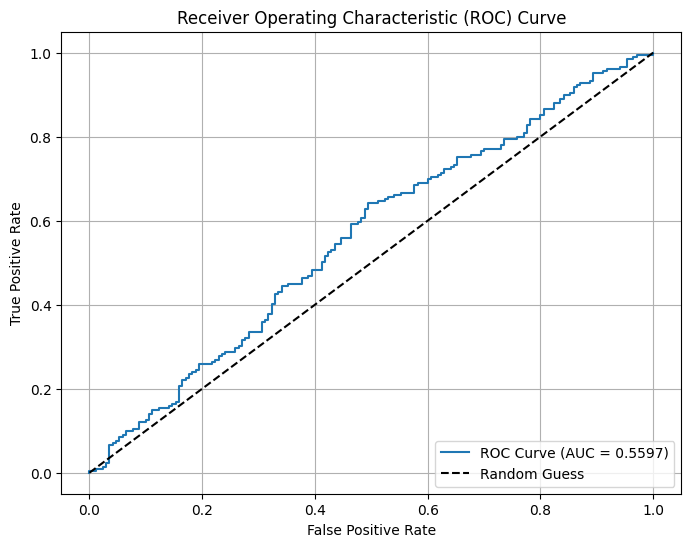

ROC AUC Score: 0.5597


In [73]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

def plot_roc_curve(matchups_df: pd.DataFrame) -> None:
    """
    Plots the ROC Curve and prints the AUC.
    
    Args:
        matchups_df (pd.DataFrame): DataFrame containing 'home_win_prob' and 'res' columns.
    """
    # Convert actual results to binary outcomes for home wins
    y_true = matchups_df['res'].apply(lambda x: 1 if x == 'h' else 0)
    y_prob = matchups_df['home_win_prob']
    
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    auc_score = roc_auc_score(y_true, y_prob)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.4f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

    print(f"ROC AUC Score: {auc_score:.4f}")

# Example usage:
plot_roc_curve(aggregated_matchups)

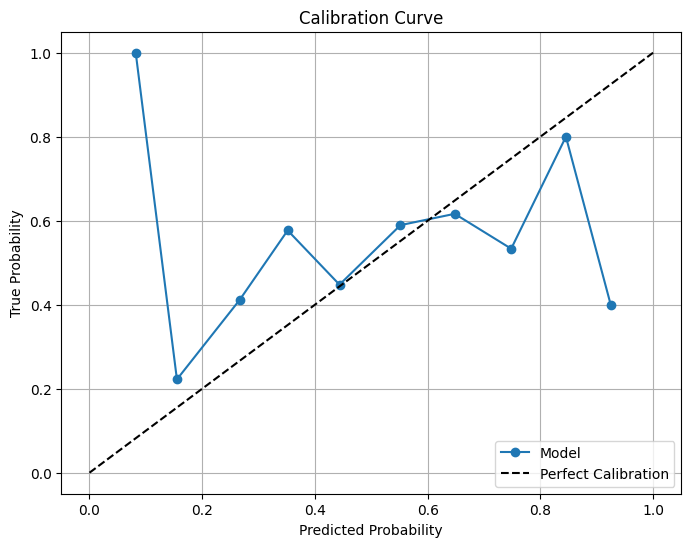

In [74]:
from sklearn.calibration import calibration_curve

def plot_calibration_curve(matchups_df: pd.DataFrame, n_bins: int = 10) -> None:
    """
    Plots the calibration curve of the predicted probabilities.
    
    Args:
        matchups_df (pd.DataFrame): DataFrame containing 'home_win_prob' and 'res' columns.
        n_bins (int): Number of bins to discretize the [0, 1] interval.
    """
    # Convert actual results to binary outcomes for home wins
    y_true = matchups_df['res'].apply(lambda x: 1 if x == 'h' else 0)
    y_prob = matchups_df['home_win_prob']
    
    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=n_bins)
    
    plt.figure(figsize=(8, 6))
    plt.plot(prob_pred, prob_true, marker='o', label='Model')
    plt.plot([0, 1], [0, 1], 'k--', label='Perfect Calibration')
    plt.xlabel('Predicted Probability')
    plt.ylabel('True Probability')
    plt.title('Calibration Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage:
plot_calibration_curve(aggregated_matchups)